# Analysis code for _Intensional Gaps_
# TODO: modify this cell for details about new finite+nonfinite analysis

[Aaron Steven White](http://aaronstevenwhite.io)<br/>
*University of Rochester*<br/>
aaron.white@rochester.edu<br/>
*Last updated*: 8 May 2021

This notebook contains all of the analyses from:

> Kane, Benjamin, William Gantt, and Aaron Steven White. 2021. [Intensional gaps: Relating doxasticity, bouleticity, veridicality, factivity, and neg-raising](https://ling.auf.net/lingbuzz/005930/current.pdf). Accepted to _Semantics and Linguistic Theory_ 31.

If you use any of the code found in this directory, please cite that paper as well as [this repository](https://github.com/MegaAttitude/intensional-gaps.git).

## Notebook Contents

Code relevant to each of the following sections can be jumped to using the links below.

- [Section 3 (Validating a templatic approach)](#Validating-a-templatic-approach)
- [Section 4 (Lexicon-scale data collection)](#Lexicon-scale-data-collection)
- [Section 5 (Discovering inference patterns)](#Discovering-inference-patterns)

These links will not work when viewing this notebook on github.

## Environment Setup

It is strongly recommended that you run this notebook using the docker image it is shipped with. See the README shipped with this notebook for details. The relevant Dockerfile is duplicated below.

```
FROM jupyter/datascience-notebook:r-4.2.3

RUN pip install pyro-ppl==1.8.4 &&\
    R -e "install.packages(c('tidyverse', 'lme4', 'glmmTMB', 'ggrepel'), repos = 'https://cloud.r-project.org')"
```

To run the jupyter notebook server, use:

```bash
docker run -it --rm --user $(id -u):$(id -g) --group-add users -v "$(pwd)":/home/jovyan -p 8888:8888 --name intensional-gaps intensional-gaps
```

Failure to use this docker image could result in minor differences in statistics from the published paper or inability to run the code at all due to API changes.

In [24]:
# base libraries
import os
import re
import json
import pickle

from typing import List, Optional
from warnings import warn
from dataclasses import dataclass
from collections import defaultdict

# numerical computing libraries
import numpy as np
import scipy.stats
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dist
from torch.utils.data import DataLoader

from numpy.linalg import inv
from numpy import logaddexp
from scipy.special import logsumexp
from scipy.stats import multivariate_normal as mvnorm
from scipy.stats import spearmanr

# mixture model
import pyro
import pyro.distributions as pdist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.infer.autoguide.initialization import init_to_uniform
from pyro.infer import MCMC, NUTS

# regression, cross-validation, and PCA
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

# plotting libraries
import seaborn as sns
import rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [25]:
USE_CHECKPOINTS = True
CHECKPOINT_DIR = 'ckpt-passivetest'
if USE_CHECKPOINTS and not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)

All the data needed for the analyses in this notebook are downloaded at run time, so an internet connection is also required.

In [26]:
!mkdir -p data
!mkdir -p plots

In cases where values on $[0, 1]$ must be clipped to $(0, 1)$—e.g. for models that use the Beta distribution—we use the following values.

In [27]:
ZERO = 1e-5
ONE = 1 - ZERO
INF = 1e38

In [28]:
project_href = "http://megaattitude.io/projects/mega-intensionality/"

## Validating a templatic approach

Section 3 of the paper presents a study validating the use of our proposed templatic bleaching method. This study has two components: a norming study and a validation study.

### Norming study

The norming study aims to measure the prior probability that a particular generic belief or desire holds among entities under a description.

In [29]:
# norming_href = project_href + "mega-intensionality-norming-v1/mega-intensionality-norming-v1.tsv"

# norming = pd.read_csv(norming_href, sep='\t')

# norming

The items are designed to induce bimodality in responses to the desire items, which we observe.

In [30]:
# def bootstrap_mean(x, iters=999):
#     bootstrapped_means = [np.mean(np.random.choice(x, size=x.shape[0])) for _ in range(iters)]
#     return np.quantile(bootstrapped_means, [0.025, 0.5, 0.975])

# id_vars = ['verb', 'subject', 'valence', 'consequent']

# norming_mean = norming.groupby(id_vars).response.apply(bootstrap_mean).reset_index()

# norming_mean['cilo'] = norming_mean.response.map(lambda x: x[0])
# norming_mean['med'] = norming_mean.response.map(lambda x: x[1])
# norming_mean['cihi'] = norming_mean.response.map(lambda x: x[2])

# norming_mean = norming_mean.drop(columns='response')

# norming_mean

More generally, we succeed in inducing high variability in the judgments for both _belief_ and _want_ items, which can be seen in Figure 1 of the paper (plotted below).

In [31]:
# %%R -i norming_mean -w 14 -h 8 -u in

# library(tidyverse)

# theme_set(theme_bw())

# norming_mean$item = interaction(norming_mean$subject, 
#                                 norming_mean$verb, 
#                                 norming_mean$valence)

# g <- ggplot(norming_mean, aes(x=fct_reorder(item, med), y=med, ymax=cihi, ymin=cilo, color=valence)) + 
#      geom_errorbar(color="black", width=0.5) + 
#      geom_point(size=2) +
#      facet_grid(consequent~.) +
#      scale_color_manual(name='Valence', values=c("#33658a", "#f26419")) +
#      xlab('Scenario') +
#      ylab('Mean Response') +
#      theme(axis.ticks.x=element_blank(),
#            axis.text.x=element_blank(),
#            strip.text=element_text(face="bold", size=20),
#            axis.title=element_text(face="bold", size=30),
#            axis.text.y=element_text(size=15, color="black"),
#            legend.position="bottom",
#            legend.title=element_text(face="bold", size=25),
#            legend.text=element_text(size=20))

# ggsave('plots/norming_means.png', width=14, height=8)
# ggsave('plots/norming_means.pdf', width=14, height=8)

# g

To obtain a single score for each item that adjusts for annotator differences in scale use, we fit a mixed effects beta regression to the responses, then use this model to predict a judgment for each item, setting the participant random effects to 0 and the predicate random effects to their best linear unbiased predictors. These predictions can be thought of as those that the "average" participant would give. 

Prior to fitting the model, we clip the responses because beta regression cannot handle 0s and 1s. (An alternative is to use 0-1 inflated beta regression, but we do not believe the extra complexity is warranted for current purposes.)

In [32]:
# norming['response_clipped'] = norming.response.clip(ZERO, ONE)

In [33]:
# %%R -i norming

# library(glmmTMB)

# set.seed(403928)

# norming$item = interaction(norming$verb, norming$subject)

# norming$consequent = relevel(as.factor(norming$consequent), 'want')
# norming$valence = relevel(as.factor(norming$valence), 'positive')

# contrasts(norming$valence) = contr.sum(levels(norming$valence))

# m.norming = glmmTMB(response_clipped ~ consequent*valence + (1+consequent|item) + (1+consequent*valence|participant),
#                     data=norming, family=list(family="beta",link="logit"))

We set the participant random effects to 0 (by changing all of the participants identifiers to one that does not exist in the data. The best linear unbiased predictors for the predicate random effects are used by `predict` by default.

In [34]:
# %%R -o norming_normalized

# norming$participant = max(norming$participant) + 1

# norming$response_normalized = predict(m.norming, norming, allow.new.levels=TRUE)

# norming_normalized = norming %>% 
#                      group_by(consequent, valence, verb, subject) %>%
#                      summarise(norm=mean(response_normalized))  

# norming_normalized

In [35]:
# norming_normalized

### Validation Study

The aim of the validation study is to ensure that gathering data using templatic items yields the same information about the inferential properties of the lexical items in the antecedents as an approach that uses contentful items and adjusts for world knowledge.

The responses to the templatic and contentful items are bundled together.

In [36]:
# validation_href = project_href + 'mega-intensionality-validation-v1/mega-intensionality-validation-v1.tsv'

# validation = pd.read_csv(validation_href, sep='\t')

# validation['response_clipped'] = validation.response.clip(ZERO, ONE)

# validation

The templatic items can be identified by a `"neutral"` label for `valence`.

In [37]:
# validation_templatic = validation.query('valence == "neutral"')

# validation_templatic

The contentful items can be identified by a non-`"neutral"` (`"positive"` or `"negative"`) label for `valence`.We merge these contentful judgments with the normalized norming scores in preparation for asking how well normalized templatic scores and normalized norming scores together predict the contentful judgments. 

In [38]:
# validation_contentful = validation.query('valence != "neutral"')
# validation_contentful = pd.merge(validation_contentful, norming_normalized)

# validation_contentful

The distribution of responses for both templatic and contentful items are show in Figure 2 of the paper (plotted below).

In [39]:
# %%R -i validation -w 14 -h 12 -u in

# library(tidyverse)

# theme_set(theme_bw())

# validation$target = ifelse(validation$target == 'subject', 'subj', 'obj')

# validation$polarity_verb_target = paste0(ifelse(validation$polarity == 'negative', '~', ''), 
#                                                  validation$verb, ' (', validation$target, ')')

# ord = c("think (subj)" , "~think (subj)",
#         "doubt (subj)", "~doubt (subj)",
#         "know (subj)", "~know (subj)" ,       
#         "remember (subj)", "~remember (subj)", 
#         "hope (subj)", "~hope (subj)",
#         "fear (subj)", "~fear (subj)",
#         "wish (subj)", "~wish (subj)",
#         "worry (subj)", "~worry (subj)",
#         "like (subj)", "~like (subj)",
#         "love (subj)", "~love (subj)",
#         "hate (subj)", "~hate (subj)",
#         "regret (subj)", "~regret (subj)",
#         "tell (subj)", "~tell (subj)",
#         "notify (subj)", "~notify (subj)",
#         "lie (subj)", "~lie (subj)",
#         "mislead (subj)", "~mislead (subj)",
#         "complain (subj)", "~complain (subj)",
#         "boast (subj)", "~boast (subj)",
#         "convince (obj)", "~convince (obj)",
#         "persuade (obj)", "~persuade (obj)",
#         "dissuade (obj)", "~dissuade (obj)",
#         "disprove (obj)", "~disprove (obj)",
#         "congratulate (obj)", "~congratulate (obj)", 
#         "apologize (obj)", "~apologize (obj)" )

# validation$polarity_verb_target = ordered(validation$polarity_verb_target, 
#                                                   levels=ord)

# validation$tense = ordered(validation$tense, levels=c('past', 'future'))

# g <- ggplot(validation, aes(x=consequent, y=response, fill=valence, linetype=tense)) + 
# geom_boxplot(outlier.size=0.5) +
# xlab('') +
# ylab(paste0('Likelihood that A ___ed ({B, to B}) P ', sprintf('\u21DD'),' {A, B} {believed, wanted} P')) +
# scale_fill_manual(name='Item valence', values=c("#33658a", "grey", "#f26419")) +
# scale_linetype(name='Embedded tense/modal') +
# facet_wrap(~polarity_verb_target, nrow=6) +
# theme(strip.text=element_text(face="bold", size=11),
#      axis.title.y=element_text(face="bold", size=22),
#      axis.text.x=element_text(face="bold", size=20, angle=45, hjust=1, color="black"),
#      axis.text.y=element_text(size=15, color="black"),
#      legend.position="bottom",
#      legend.title=element_text(face="bold", size=25),
#      legend.text=element_text(size=20))

# ggsave('plots/validation_distributions.png', width=14, height=12)
# ggsave('plots/validation_distributions.pdf', width=14, height=12)

# g

To construct normalized scores for the templatic items, we fit a beta mixed effects model.

In [40]:
# %%R -i validation_templatic

# set.seed(403928)

# validation_templatic$consequent = relevel(as.factor(validation_templatic$consequent), 'want')
# validation_templatic$polarity = relevel(as.factor(validation_templatic$polarity), 'positive')
# validation_templatic$tense = relevel(as.factor(validation_templatic$tense), 'future')

# validation_templatic$target = as.factor(paste(validation_templatic$transitivity,
#                                               validation_templatic$target, sep='-'))

# contrasts(validation_templatic$polarity) = contr.sum(levels(validation_templatic$polarity))
# contrasts(validation_templatic$tense) = contr.sum(levels(validation_templatic$tense))

# m = glmmTMB(response_clipped ~ consequent*polarity*tense*target + (1+consequent*polarity*tense|verb) + (1+consequent*polarity*tense*target|participant),
#             data=validation_templatic, family=list(family="beta",link="logit"))

Then, as for the norming data, we set the participant random effects to 0 (by changing all of the participants identifiers to one that does not exist in the data. The best linear unbiased predictors for the predicate random effects are used by `predict` by default.

In [41]:
# %%R -o validation_templatic_normalized

# validation_templatic$participant <- max(validation_templatic$participant) + 1

# validation_templatic$response_normalized <- predict(m, validation_templatic, allow.new.levels=TRUE)

# validation_templatic_normalized <- validation_templatic %>% 
#                                    group_by(consequent, polarity, tense, verb) %>%
#                                    summarise(neutral=mean(response_normalized))  

# validation_templatic_normalized

In [42]:
# validation_templatic_normalized

We merge these scores with the contenful data.

In [43]:
# validation_contentful_templatic = pd.merge(validation_contentful, validation_templatic_normalized)

# validation_contentful_templatic

To assess how well responses to templatic items capture the same information about the inferential properties of the lexical items as an approach that uses contentful items and adjusts for world knowledge, we assess how well the judgments for contentful items can be predicted given just the normalized scores from the norming experiment and the judgments for the templatic items. 

In [44]:
# %%R -i validation_contentful_templatic -o cv_corrs

# set.seed(403928)

# verb.order = unique(validation_contentful_templatic$verb)

# mod.list = c()
# verbs = c()
# corrs = c()

# for (v in verb.order) { 
#     train = filter(validation_contentful_templatic, verb !=v)
#     test = filter(validation_contentful_templatic, verb == v)
    
#     m.norm.by.neutral <- glmmTMB(response_clipped ~ norm*neutral + (1+norm*neutral|verb) + (1+norm*neutral|participant),
#                                    data=train, 
#                                    family=list(family="beta",link="logit"))
    
#     predicted = predict(m.norm.by.neutral, test, allow.new.levels=TRUE)
#     spearman = cor(test$response_clipped, predicted, method="spearman")
    
#     verbs = c(verbs, v)
#     corrs = c(corrs, spearman)
    
#     mod.list = c(mod.list, list(mod=m.norm.by.neutral, excluded=v, predicted=predicted))
# }

# cv_corrs = data.frame(verbs=verbs, corrs=corrs)

# cv_corrs

The result is an average rank correlation of 0.70.

In [45]:
# cv_corrs_stats = np.round(np.quantile([np.mean(np.random.choice(cv_corrs.corrs.values,
#                                                                 cv_corrs.corrs.values.shape[0])) 
#                                        for _ in range(999)], 
#                                       [0.025, 0.5, 0.975]), 2)

# print('$\\\\rho$ = {}, (95\\%CI = [{}, {}])'.format(cv_corrs_stats[1], cv_corrs_stats[0], cv_corrs_stats[2]))

This is reliably better than the interannotator agreement.

In [46]:
# iaa_corrs = []

# for listid, listdf in validation_contentful.groupby('listid'):
#     parts = listdf.participant.unique()
    
#     for p1 in parts:
#         for p2 in parts:
#             if p1 != p2:
#                 merged = pd.merge(listdf[listdf.participant==p1],
#                                   listdf[listdf.participant==p2],
#                                   on=[c for c in listdf.columns 
#                                       if c not in ['participant', 'response', 
#                                                    'response_clipped', 'norm']])
#                 #corr = np.corrcoef(merged.response_x, merged.response_y)[1,0]
#                 corr = spearmanr(merged.response_x, merged.response_y).correlation
                
#                 iaa_corrs.append([listid, p1, p2, corr])
    
# iaa_corrs = pd.DataFrame(iaa_corrs, columns=['listid', 'participant1', 'participant2', 'correlation'])

# iaa_stats = np.round(np.quantile([iaa_corrs.sample(frac=1., replace=True).correlation.mean() 
#                                   for _ in range(999)], [0.025, 0.5, 0.975]), 2)

# print('$\\\\rho$ = {}, (95\\%CI = [{}, {}])'.format(iaa_stats[1], iaa_stats[0], iaa_stats[2]))

## Lexicon-scale data collection

We collect the MegaIntensionality dataset using the templatic methodology validated above.

In [47]:
bulk1_href = project_href  + 'mega-intensionality-v1/mega-intensionality-v1.tsv'
bulk2_href = 'data/mega-intensionality-nonfinite.tsv'

mc1 = pd.read_csv(bulk1_href, sep='\t')
mc1['participant'] = mc1['participant'].astype('str') + '_1'
mc2 = pd.read_csv(bulk2_href, sep='\t')
mc2['participant'] = mc2['participant'].astype('str') + '_2'

mc = pd.concat([mc1, mc2])
mc_cols = list(mc.columns)
mc_cols_reordered = mc_cols[0:mc_cols.index('target')] + ['target', 'control'] + mc_cols[mc_cols.index('target')+1:-1]
mc = mc[mc_cols_reordered]
mc['participant'] = mc['participant'].astype('category').cat.codes
mc['control'] = mc['control'].fillna('na')

mc

,participant,antecedent_verb,antecedent_polarity,target,control,antecedent_frame,consequent_verb,consequent_embedded_tense,antecedent_text,consequent_text,response,sanity
0,506,fess_up,negative,object,na,NP V to NP that S[+future],want,future,A didn't fess up to B that C would happen,B wanted C to happen,0.38,4
1,506,consider,positive,subject,na,NP V that S,want,past,A considered that C happened,A wanted C to have happened,0.78,4
2,506,traumatize,negative,subject,na,NP be V that S[+future],believe,future,A wasn't traumatized that C would happen,A believed that C would happen,0.67,4
3,506,speculate,positive,object,na,NP V to NP that S[+future],believe,future,A speculated to B that C would happen,B believed that C would happen,0.63,4
4,506,blare,positive,subject,na,NP V that S[-tense],want,future,A blared that C happen,A wanted C to happen,0.86,4
...,...,...,...,...,...,...,...,...,...,...,...,...
92635,335,cause,negative,subject,object,NP V NP to VP[+eventive],believe,future,A didn't cause B to do C.,How likely is it that A believed that B would ...,0.29,4
92636,335,perceive,positive,object,object,NP V NP to VP[+eventive],intend,future,A perceived B to do C.,How likely is it that B intended to do C?,0.50,4
92637,335,steer,negative,object,object,NP V NP to VP[+eventive],intend,future,A didn't steer B to do C.,How likely is it that B intended to do C?,0.50,4
92638,335,sign_on,positive,subject,subject,NP V to VP[+eventive],intend,future,A signed on to do C.,How likely is it that A intended to do C?,1.00,4


To visualize these data, we first derive an aggregate score using a beta mixed model-based normalizer.

In [48]:
def hash_column(col: pd.Series) -> np.array:
    col_as_cat = col.astype('category')
    
    values = torch.tensor(col_as_cat.cat.codes.values).type(torch.long)
    categories = col_as_cat.cat.categories
    
    return values, categories

class UnitNormalizer:
    
    required_columns = ['item', 'participant', 'response']
    large_variance = 100.
    
    def __init__(self, seed: int = 42):
        self._seed = seed
    
    def _validate_data(self, data: pd.DataFrame) -> None:
        for col in self.required_columns:
            if col not in data.columns:
                raise ValueError(f'"{col}" column is required in {data.name}_data')
                
    def _prepare_data(self, data: pd.DataFrame) -> None:
        self._raw_data = data
        
        self._validate_data(data)

        for col in self.required_columns:
            if col == 'response':
                setattr(self, col, torch.tensor(data[col].values).type(torch.float))
                setattr(self, f'n_{col}', data.shape[0])

            else:
                values, categories = hash_column(data[col])
                setattr(self, col, values)
                setattr(self, f'{col}_categories', categories)
                setattr(self, f'n_{col}', len(categories))
    
    def _init_loc_fn(self, site):        
        return init_to_uniform(site, radius=1e-3)
    
    def _initialize_model(self):
        
        def model(item, participant, response):
            scale = pyro.sample('scale', pdist.Normal(0., self.large_variance))
            
            # Vector of variances for each of the d variables
            theta = pyro.sample("theta", pdist.HalfCauchy(torch.ones(2)).to_event(1))
            # Lower cholesky factor of a correlation matrix
            L_omega = pyro.sample("L_omega", pdist.LKJCorrCholesky(2, 1.0))
            # Lower cholesky factor of the covariance matrix
            participant_scale = torch.mm(theta.sqrt().diag_embed(), L_omega)
            
            with pyro.plate('item_plate', self.n_item):
                locs = pyro.sample('locs', pdist.Normal(0, self.large_variance))
            
            with pyro.plate('participant_plate', self.n_participant):
                locs_scales_participant = pyro.sample('locs_scales_participant',
                                                      pdist.MultivariateNormal(torch.zeros(2),
                                                                              scale_tril=participant_scale))

            with pyro.plate('response_plate', self.n_response):                
                locs = torch.sigmoid(locs[item] + locs_scales_participant[participant, 1])
                scales = torch.square(scale + locs_scales_participant[participant, 0])
                
                concentration1 = scales*locs
                concentration0 = scales*(1.-locs)

                pyro.sample('obs', 
                            pdist.Beta(concentration1.clamp(min=ZERO),
                                      concentration0.clamp(min=ZERO)), 
                            obs=response)
                
                lp = pdist.Beta(concentration1.clamp(min=ZERO), 
                               concentration0.clamp(min=ZERO)).log_prob(response)
                
                return lp
            
        guide = AutoDelta(model, init_loc_fn=self._init_loc_fn)
        
        return model, guide

    def fit(self, data: pd.DataFrame, lr: float = 0.05, tolerance=0.0005, window_size=100,
            iterations: int=1000, verbosity: int=10) -> 'UnitNormalizer':
        pyro.set_rng_seed(self._seed)
        pyro.clear_param_store()
        
        self._prepare_data(data)
        
        optim = pyro.optim.Adam({'lr': lr})
        self._elbo = Trace_ELBO(max_plate_nesting=1)
        
        self._model, self._guide = self._initialize_model()
        
        svi = SVI(self._model, self._guide, optim, loss=self._elbo)
        
        losses = []
         
        like_hist = []
        prev_like_sum = -np.inf
            
        for i in range(iterations):
            
            loss = svi.step(self.item, self.participant, self.response)
            losses.append(loss)
            
            if i and not i % verbosity:
                print('ELBO:', np.round(loss, 2))
        
        return self
    
    def param(self, param_name):
        return pyro.get_param_store()[f'AutoDelta.{param_name}']

In [49]:
mc['item'] = mc.antecedent_verb + '-' + mc.antecedent_polarity + '-' + mc.antecedent_frame + '-' +\
             mc.target + '-' + mc.control + '-' + mc.consequent_verb + '-' + mc.consequent_embedded_tense

mc['response'] = mc.response.map(lambda x: min(x, ONE)).map(lambda x: max(x, ZERO))

if not os.path.isfile('data/mega-intensionality-v2-normalized.tsv'):

    normalizer_checkpoint = f'{CHECKPOINT_DIR}/unit_normalizer.pickle'
    if USE_CHECKPOINTS and os.path.isfile(normalizer_checkpoint):
        print(f'Loading unit normalizer from checkpoint...')
        with open(normalizer_checkpoint, 'rb') as f:
            normalizer = pickle.load(f)

    else:
        normalizer = UnitNormalizer().fit(mc, iterations=50000, lr=0.1, verbosity=5000)

        if USE_CHECKPOINTS:
            with open(normalizer_checkpoint, 'wb') as f:
                pickle.dump(normalizer, f)

The resulting normalized values are made available [here](http://megaattitude.io/projects/mega-intensionality/mega-intensionality-v1/mega-intensionality-v1-normalized.tsv).

In [50]:
if not os.path.isfile('data/mega-intensionality-v2-normalized.tsv'):
    
    keep_cols = ['item', 'antecedent_verb', 'antecedent_polarity', 'antecedent_frame', 
                 'target', 'control', 'consequent_verb', 'consequent_embedded_tense', 'antecedent_text']

    mc_normalized = pd.merge(mc[keep_cols].drop_duplicates().reset_index(drop=True),
                             pd.DataFrame(list(zip(normalizer.item_categories.values, 
                                                   torch.sigmoid(normalizer.param('locs')).data.numpy())), 
                                          columns=['item', 'response_normalized']))

    mc_normalized = mc_normalized.drop(columns='item')

    mc_normalized.sort_values('response_normalized')

    mc_normalized.to_csv('data/mega-intensionality-v2-normalized.tsv', sep='\t', index=False)
    
else:
    mc_normalized = pd.read_csv('data/mega-intensionality-v2-normalized.tsv', sep='\t')

Figure 3 in the paper plots these normalized values.

For passive frames, we set the target (and control, if any) to "object".

In [51]:
passive_frames = ['NP be V that S[+future]',
                  'NP be V that S[-tense]',
                  'NP be V to VP[-eventive]',
                  'NP be V to VP[+eventive]']
mc_normalized.loc[mc_normalized['antecedent_frame'].isin(passive_frames), 'target'] = 'object'
mc_normalized.loc[(mc_normalized['antecedent_frame'].isin(passive_frames) & ~mc_normalized['control'].str.match('na')), 'control'] = 'object'

mc_normalized[mc_normalized['antecedent_frame'].isin(passive_frames)]

,antecedent_verb,antecedent_polarity,antecedent_frame,target,control,consequent_verb,consequent_embedded_tense,antecedent_text,response_normalized
2,traumatize,negative,NP be V that S[+future],object,na,believe,future,A wasn't traumatized that C would happen,0.689915
8,wager,positive,NP be V that S[+future],object,na,want,future,A was wagered that C would happen,0.641786
14,invigorate,positive,NP be V that S[+future],object,na,believe,future,A was invigorated that C would happen,0.784740
19,trouble,negative,NP be V that S[+future],object,na,want,future,A wasn't troubled that C would happen,0.620065
24,reaffirm,negative,NP be V that S[+future],object,na,believe,future,A wasn't reaffirmed that C would happen,0.382103
...,...,...,...,...,...,...,...,...,...
18519,astonish,positive,NP be V to VP[+eventive],object,object,want,past,A was astonished to do C.,0.465766
18538,commence,negative,NP be V to VP[+eventive],object,object,want,future,A wasn't commenced to do C.,0.350390
18550,suppose,positive,NP be V to VP[+eventive],object,object,believe,future,A was supposed to do C.,0.820552
18551,chronicle,negative,NP be V to VP[+eventive],object,object,want,past,A wasn't chronicled to do C.,0.355348


In [52]:
mc_normalized_cast = mc_normalized.pivot_table(index=['antecedent_verb', 
                                                      'antecedent_frame', 
                                                      'target',
                                                      'control',
                                                      'consequent_verb', 
                                                      'consequent_embedded_tense'],
                                              columns='antecedent_polarity',
                                              values='response_normalized').reset_index()

mc_normalized_cast_f = mc_normalized_cast[mc_normalized_cast['control'] == 'na']

mc_normalized_cast_nf = mc_normalized_cast[mc_normalized_cast['control'] != 'na']
mc_normalized_cast_nf['target_control'] = mc_normalized_cast_nf['target'] + '-' + mc_normalized_cast_nf['control']

mc_normalized_cast

/tmp/ipykernel_106/2875580870.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mc_normalized_cast_nf['target_control'] = mc_normalized_cast_nf['target'] + '-' + mc_normalized_cast_nf['control']


antecedent_polarity,antecedent_verb,antecedent_frame,target,control,consequent_verb,consequent_embedded_tense,negative,positive
0,abhor,NP V VPing,subject,subject,believe,future,0.570860,0.266675
1,abhor,NP V VPing,subject,subject,believe,past,0.588933,0.384438
2,abhor,NP V VPing,subject,subject,intend,future,0.548834,0.159192
3,abhor,NP V VPing,subject,subject,intend,past,0.641596,0.341977
4,abhor,NP V VPing,subject,subject,want,future,0.706612,0.066649
...,...,...,...,...,...,...,...,...
10549,yelp,NP V to NP that S,subject,na,believe,past,0.582569,0.911867
10550,yelp,NP V to NP that S,subject,na,want,past,0.445301,0.504983
10551,yelp,NP V to VP[+eventive],subject,subject,believe,future,NaN,0.601827
10552,yelp,NP V to VP[+eventive],subject,subject,intend,future,0.470776,0.829782


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


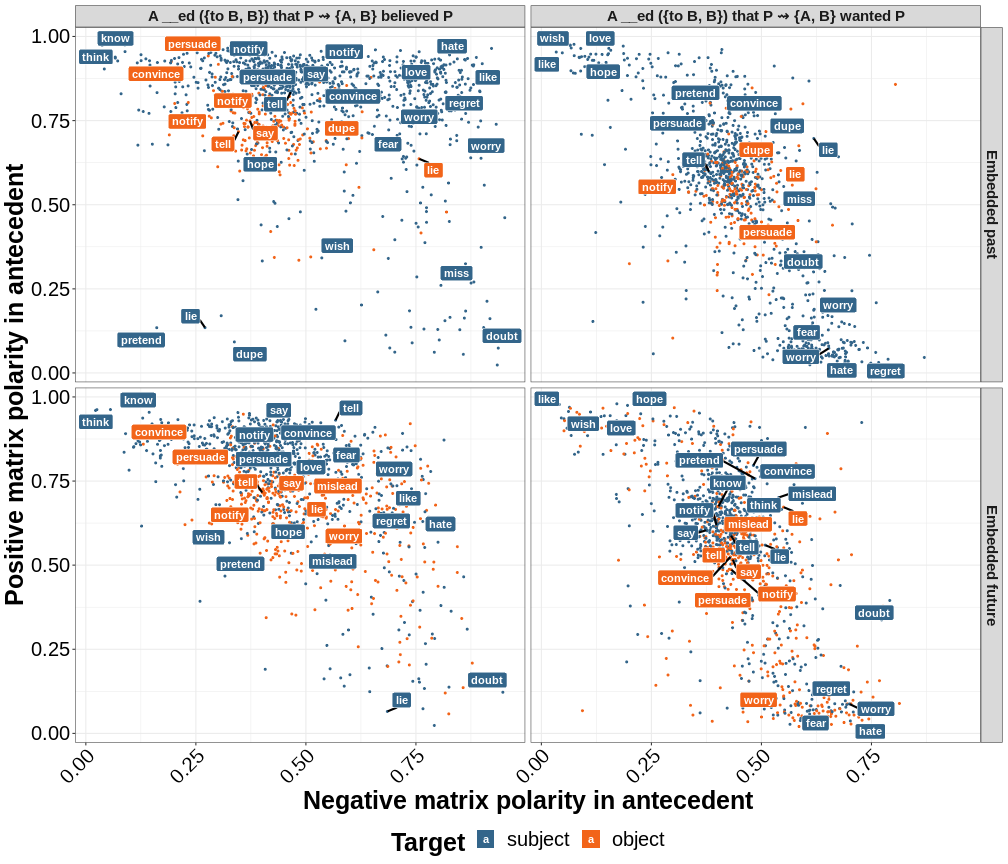

In [53]:
%%R -i mc_normalized_cast_f -w 14 -h 12 -u in

library(tidyverse)
library(ggrepel)

mc_normalized_cast_f$target <- factor(mc_normalized_cast_f$target, levels=c('subject', 'object'))
mc_normalized_cast_f$consequent_embedded_tense <- factor(mc_normalized_cast_f$consequent_embedded_tense, 
                                                       levels=c('past', 'future'))

theme_set(theme_bw())

intransitive_verbs_f = c('think', 'know', 'hope', 'wish', 'worry', 'fear', 'like', 'love', 'hate', 'regret', 'pretend', 'doubt', 'rejected', 'miss')
transitive_verbs_f = c('say', 'tell', 'lie', 'mislead', 'notify', 'convince', 'persuade', 'dupe')

intransitive_frames_f = c('NP V that S', 'NP be V that S', 
                          'NP V that S[+future]', 'NP be V that S[+future]', 
                          'NP V that S[-tense]', 'NP be V that S[-tense]')
transitive_frames_f = c('NP V to NP that S', 'NP V NP that S',
                        'NP V to NP that S[+future]', 'NP V NP that S[+future]',
                        'NP V to NP that S[-tense]', 'NP V NP that S[-tense]')

g <- ggplot(mc_normalized_cast_f, aes(x=negative, y=positive, color=target)) +
geom_point(size=0.75) +
geom_label_repel(data=filter(mc_normalized_cast_f, 
                       (antecedent_verb%in%intransitive_verbs_f & antecedent_frame %in% intransitive_frames_f) | (antecedent_verb%in%transitive_verbs_f & antecedent_frame %in% transitive_frames_f)), 
           aes(label=antecedent_verb, fill=target), 
           color="white", fontface="bold", segment.color="black", segment.size=1) +
scale_color_manual(name='Target', values=c("#33658a", "#f26419")) +
scale_fill_manual(name='Target',  values=c("#33658a", "#f26419")) +
facet_grid(factor(paste('Embedded', consequent_embedded_tense), levels=c('Embedded past', 'Embedded future')) ~ paste('A __ed ({to B, B}) that P', sprintf('\u21DD'), '{A, B}', 
                            ifelse(consequent_verb=='believe', 'believed', 'wanted'), 
                            ifelse(consequent_verb=='believe', 'P', 'P'))) +
xlab('Negative matrix polarity in antecedent') +
ylab('Positive matrix polarity in antecedent') +
theme(strip.text=element_text(face="bold", size=15),
     axis.title=element_text(face="bold", size=25),
     axis.text=element_text(size=20, color="black"),
     axis.text.x=element_text(angle=45, hjust=1),
     legend.position="bottom",
     legend.title=element_text(face="bold", size=25),
     legend.text=element_text(size=20))

ggsave('plots/verb_distributions_finite.png', width=14, height=12)
ggsave('plots/verb_distributions_finite.pdf', width=14, height=12)

g

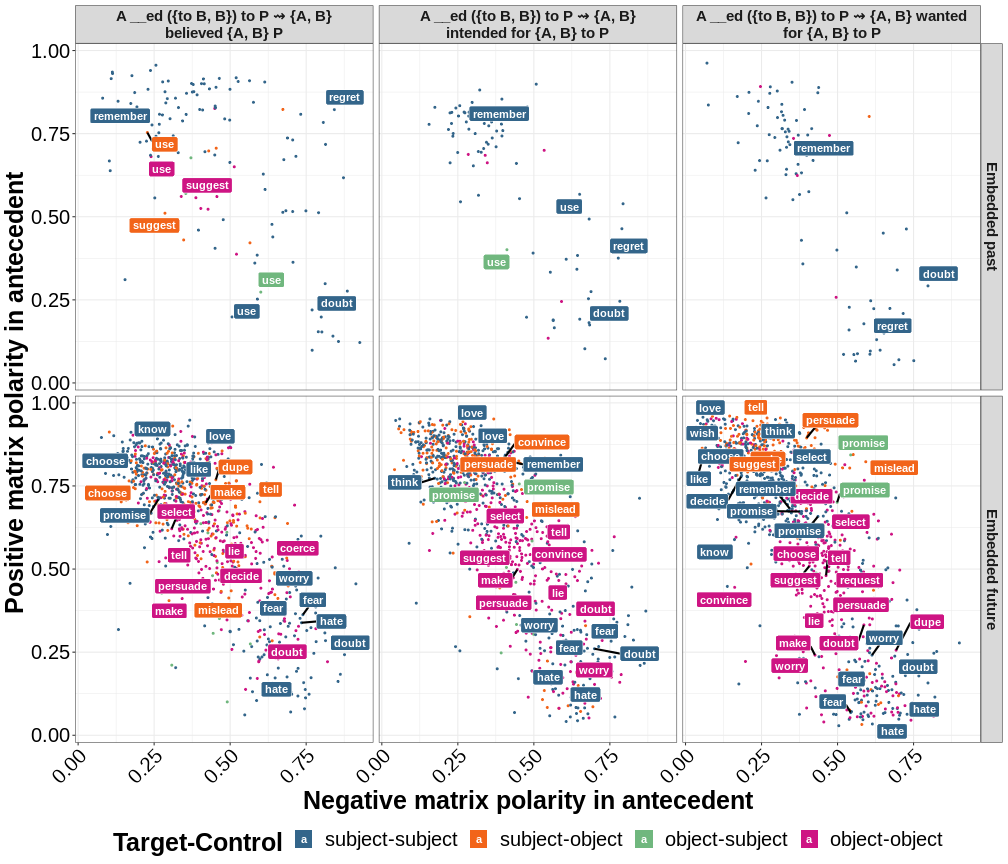

In [54]:
%%R -i mc_normalized_cast_nf -w 14 -h 12 -u in

library(tidyverse)
library(ggrepel)

conditions = c('subject-subject', 'subject-object', 'object-subject', 'object-object')
mc_normalized_cast_nf$target_control <- factor(mc_normalized_cast_nf$target_control, levels=conditions)
mc_normalized_cast_nf$consequent_embedded_tense <- factor(mc_normalized_cast_nf$consequent_embedded_tense, 
                                                       levels=c('past', 'future'))

theme_set(theme_bw())

intransitive_verbs_nf = c('think', 'know', 'hope', 'wish', 'worry', 'fear', 'like', 'love', 'hate', 'regret', 'pretend', 'doubt', 'rejected', 'miss', 'decide', 'choose', 'select', 'remember')
transitive_verbs_nf = c('say', 'tell', 'lie', 'mislead', 'notify', 'convince', 'persuade', 'dupe', 'promise', 'use', 'decide', 'choose', 'select', 'make', 'request', 'suggest', 'coerce')

intransitive_frames_nf = c('NP V to VP[-eventive]', 'NP be V to VP[-eventive]',
                           'NP V to VP[+eventive]', 'NP be V to VP[+eventive]',
                           'NP V VPing')
transitive_frames_nf = c('NP V to NP to VP[-eventive]', 'NP V NP to VP[-eventive]',
                         'NP V to NP to VP[+eventive]', 'NP V NP to VP[+eventive]',
                         'NP V NP VP', 'NP V for NP to VP')

sub <- filter(mc_normalized_cast_nf,
              (antecedent_verb%in%intransitive_verbs_nf & antecedent_frame %in% intransitive_frames_nf) | (antecedent_verb%in%transitive_verbs_nf & antecedent_frame %in% transitive_frames_nf))

g <- ggplot(mc_normalized_cast_nf, aes(x=negative, y=positive, color=target_control)) +
geom_point(size=0.75) +
geom_label_repel(data=sub, 
           aes(label=antecedent_verb, fill=target_control), 
           color="white", fontface="bold", segment.color="black", segment.size=1) +
scale_color_manual(name='Target-Control', values=c("#33658a", "#f26419", "#70B77E", "#CE1483")) +
scale_fill_manual(name='Target-Control',  values=c("#33658a", "#f26419", "#70B77E", "#CE1483")) +
facet_grid(factor(paste('Embedded', consequent_embedded_tense), levels=c('Embedded past', 'Embedded future')) ~ paste('A __ed ({to B, B}) to P', sprintf('\u21DD'), '{A, B}', 
                            ifelse(consequent_verb=='believe', 'believed', ifelse(consequent_verb=='want', 'wanted', 'intended')),
                            ifelse(consequent_verb=='believe', '{A, B} P', ifelse(consequent_verb=='want', 'for {A, B} to P', 'for {A, B} to P'))),
          labeller = label_wrap_gen(width = 40, multi_line = TRUE)) +
xlab('Negative matrix polarity in antecedent') +
ylab('Positive matrix polarity in antecedent') +
theme(strip.text=element_text(face="bold", size=15),
     axis.title=element_text(face="bold", size=25),
     axis.text=element_text(size=20, color="black"),
     axis.text.x=element_text(angle=45, hjust=1),
     legend.position="bottom",
     legend.title=element_text(face="bold", size=25),
     legend.text=element_text(size=20))

ggsave('plots/verb_distributions_nonfinite.png', width=14, height=12)
ggsave('plots/verb_distributions_nonfinite.pdf', width=14, height=12)

g

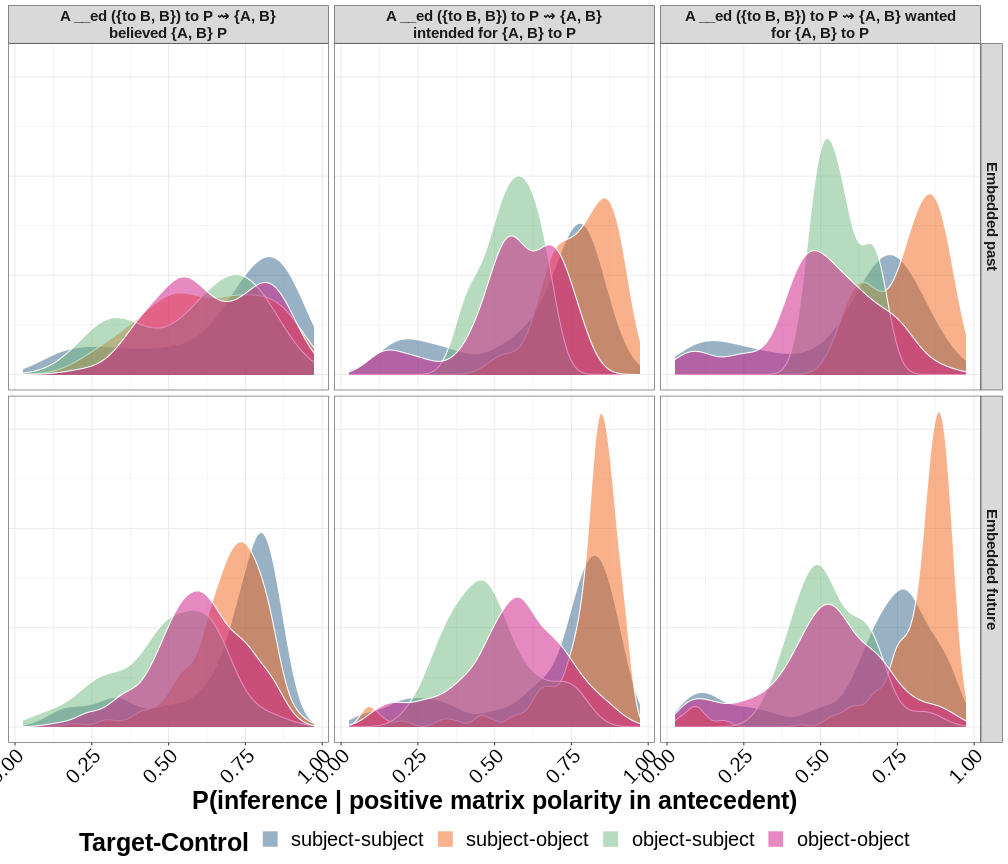

In [55]:
%%R -i mc_normalized_cast_nf -w 14 -h 12 -u in

library(tidyverse)
library(ggrepel)

conditions = c('subject-subject', 'subject-object', 'object-subject', 'object-object')
mc_normalized_cast_nf$target_control <- factor(mc_normalized_cast_nf$target_control, levels=conditions)
mc_normalized_cast_nf$consequent_embedded_tense <- factor(mc_normalized_cast_nf$consequent_embedded_tense, 
                                                       levels=c('past', 'future'))

theme_set(theme_bw())

intransitive_verbs_nf = c('think', 'know', 'hope', 'wish', 'worry', 'fear', 'like', 'love', 'hate', 'regret', 'pretend', 'doubt', 'rejected', 'miss', 'decide', 'choose', 'select', 'remember')
transitive_verbs_nf = c('say', 'tell', 'lie', 'mislead', 'notify', 'convince', 'persuade', 'dupe', 'promise', 'use', 'decide', 'choose', 'select', 'make', 'request', 'suggest', 'coerce')

intransitive_frames_nf = c('NP V to VP[-eventive]', 'NP be V to VP[-eventive]',
                           'NP V to VP[+eventive]', 'NP be V to VP[+eventive]',
                           'NP V VPing')
transitive_frames_nf = c('NP V to NP to VP[-eventive]', 'NP V NP to VP[-eventive]',
                         'NP V to NP to VP[+eventive]', 'NP V NP to VP[+eventive]',
                         'NP V NP VP', 'NP V for NP to VP')

sub <- filter(mc_normalized_cast_nf,
              ((antecedent_verb%in%intransitive_verbs_nf & antecedent_frame %in% intransitive_frames_nf) | (antecedent_verb%in%transitive_verbs_nf & antecedent_frame %in% transitive_frames_nf)))
sub$jit <- runif(nrow(sub), 0.25, 8)

g <- ggplot(mc_normalized_cast_nf, aes(x=positive, color=target_control)) +
geom_density(color="white", aes(fill=target_control), alpha=0.5) +
# geom_hline(yintercept=0) +
# geom_segment(data=sub, aes(x=positive, y=jit, xend=positive, yend=rep(0, length(jit)))) +
# geom_label(data=sub, aes(x=positive, y=jit, label=antecedent_verb, fill=target_control), fontface="bold", color="white") +
scale_color_manual(name='Target-Control', values=c("#33658a", "#f26419", "#70B77E", "#CE1483")) +
scale_fill_manual(name='Target-Control',  values=c("#33658a", "#f26419", "#70B77E", "#CE1483")) +
facet_grid(factor(paste('Embedded', consequent_embedded_tense), levels=c('Embedded past', 'Embedded future')) ~ paste('A __ed ({to B, B}) to P', sprintf('\u21DD'), '{A, B}', 
                            ifelse(consequent_verb=='believe', 'believed', ifelse(consequent_verb=='want', 'wanted', 'intended')),
                            ifelse(consequent_verb=='believe', '{A, B} P', ifelse(consequent_verb=='want', 'for {A, B} to P', 'for {A, B} to P'))),
          labeller = label_wrap_gen(width = 40, multi_line = TRUE)) +
xlab('P(inference | positive matrix polarity in antecedent)') +
theme(strip.text=element_text(face="bold", size=15),
     axis.title=element_text(face="bold", size=25),
     axis.text=element_text(size=20, color="black"),
     axis.text.x=element_text(angle=45, hjust=1),
     axis.title.y = element_blank(),
     axis.text.y = element_blank(),
     axis.ticks.y = element_blank(),
     legend.position="bottom",
     legend.title=element_text(face="bold", size=25),
     legend.text=element_text(size=20))

ggsave('plots/verb_density_nonfinite_positive.png', width=14, height=12)
ggsave('plots/verb_density_nonfinite_positive.pdf', width=14, height=12)

g

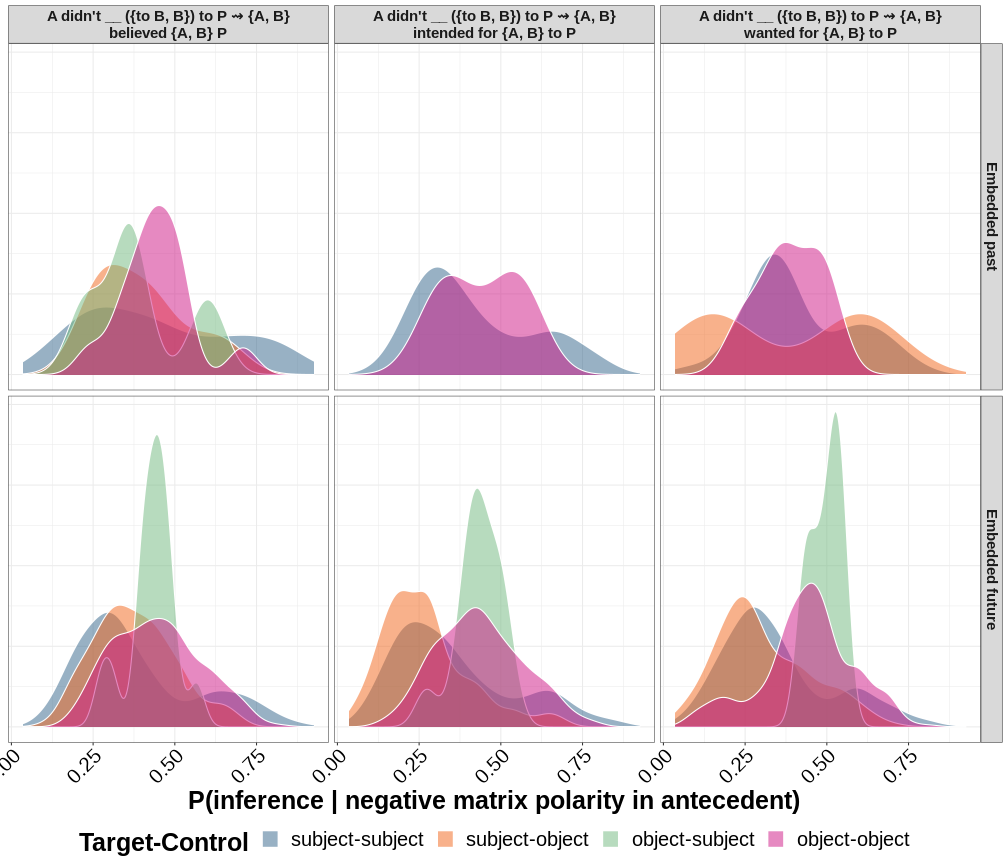

In [56]:
%%R -i mc_normalized_cast_nf -w 14 -h 12 -u in

library(tidyverse)
library(ggrepel)

conditions = c('subject-subject', 'subject-object', 'object-subject', 'object-object')
mc_normalized_cast_nf$target_control <- factor(mc_normalized_cast_nf$target_control, levels=conditions)
mc_normalized_cast_nf$consequent_embedded_tense <- factor(mc_normalized_cast_nf$consequent_embedded_tense, 
                                                       levels=c('past', 'future'))

theme_set(theme_bw())

intransitive_verbs_nf = c('think', 'know', 'hope', 'wish', 'worry', 'fear', 'like', 'love', 'hate', 'regret', 'pretend', 'doubt', 'rejected', 'miss', 'decide', 'choose', 'select', 'remember')
transitive_verbs_nf = c('say', 'tell', 'lie', 'mislead', 'notify', 'convince', 'persuade', 'dupe', 'promise', 'use', 'decide', 'choose', 'select', 'make', 'request', 'suggest', 'coerce')

intransitive_frames_nf = c('NP V to VP[-eventive]', 'NP be V to VP[-eventive]',
                           'NP V to VP[+eventive]', 'NP be V to VP[+eventive]',
                           'NP V VPing')
transitive_frames_nf = c('NP V to NP to VP[-eventive]', 'NP V NP to VP[-eventive]',
                         'NP V to NP to VP[+eventive]', 'NP V NP to VP[+eventive]',
                         'NP V NP VP', 'NP V for NP to VP')

sub <- filter(mc_normalized_cast_nf,
              ((antecedent_verb%in%intransitive_verbs_nf & antecedent_frame %in% intransitive_frames_nf) | (antecedent_verb%in%transitive_verbs_nf & antecedent_frame %in% transitive_frames_nf)))
sub$jit <- runif(nrow(sub), 0.25, 8)

g <- ggplot(mc_normalized_cast_nf, aes(x=negative, color=target_control)) +
geom_density(color="white", aes(fill=target_control), alpha=0.5) +
# geom_hline(yintercept=0) +
# geom_segment(data=sub, aes(x=negative, y=jit, xend=negative, yend=rep(0, length(jit)))) +
# geom_label(data=sub, aes(x=negative, y=jit, label=antecedent_verb, fill=target_control), fontface="bold", color="white") +
scale_color_manual(name='Target-Control', values=c("#33658a", "#f26419", "#70B77E", "#CE1483")) +
scale_fill_manual(name='Target-Control',  values=c("#33658a", "#f26419", "#70B77E", "#CE1483")) +
facet_grid(factor(paste('Embedded', consequent_embedded_tense), levels=c('Embedded past', 'Embedded future')) ~ paste('A didn\'t __ ({to B, B}) to P', sprintf('\u21DD'), '{A, B}', 
                            ifelse(consequent_verb=='believe', 'believed', ifelse(consequent_verb=='want', 'wanted', 'intended')),
                            ifelse(consequent_verb=='believe', '{A, B} P', ifelse(consequent_verb=='want', 'for {A, B} to P', 'for {A, B} to P'))),
          labeller = label_wrap_gen(width = 40, multi_line = TRUE)) +
xlab('P(inference | negative matrix polarity in antecedent)') +
theme(strip.text=element_text(face="bold", size=15),
     axis.title=element_text(face="bold", size=25),
     axis.text=element_text(size=20, color="black"),
     axis.text.x=element_text(angle=45, hjust=1),
     axis.title.y = element_blank(),
     axis.text.y = element_blank(),
     axis.ticks.y = element_blank(),
     legend.position="bottom",
     legend.title=element_text(face="bold", size=25),
     legend.text=element_text(size=20))

ggsave('plots/verb_density_nonfinite_negative.png', width=14, height=12)
ggsave('plots/verb_density_nonfinite_negative.pdf', width=14, height=12)

g

## Discovering inference patterns

Section 5 in the paper applies a multiview mixed effects mixture model to MegaIntensionality as well as two other datasets simultaneously. For each dataset, we define a `verbframe` column, which gives the verb-frame pairs to be clustered, and an `item` column, which gives the dimensions of the cluster centers.

For passive frames, we again set target (and control, if any) to object

In [57]:
mc.loc[mc['antecedent_frame'].isin(passive_frames), 'target'] = 'object'
mc.loc[(mc['antecedent_frame'].isin(passive_frames) & ~mc['control'].str.match('na')), 'control'] = 'object'

mc[mc['antecedent_frame'].isin(passive_frames)]

,participant,antecedent_verb,antecedent_polarity,target,control,antecedent_frame,consequent_verb,consequent_embedded_tense,antecedent_text,consequent_text,response,sanity,item
2,506,traumatize,negative,object,na,NP be V that S[+future],believe,future,A wasn't traumatized that C would happen,A believed that C would happen,0.67000,4,traumatize-negative-NP be V that S[+future]-su...
8,506,wager,positive,object,na,NP be V that S[+future],want,future,A was wagered that C would happen,A wanted C to happen,0.71000,4,wager-positive-NP be V that S[+future]-subject...
14,506,invigorate,positive,object,na,NP be V that S[+future],believe,future,A was invigorated that C would happen,A believed that C would happen,0.83000,4,invigorate-positive-NP be V that S[+future]-su...
19,506,trouble,negative,object,na,NP be V that S[+future],want,future,A wasn't troubled that C would happen,A wanted C to happen,0.50000,4,trouble-negative-NP be V that S[+future]-subje...
24,506,reaffirm,negative,object,na,NP be V that S[+future],believe,future,A wasn't reaffirmed that C would happen,A believed that C would happen,0.34000,4,reaffirm-negative-NP be V that S[+future]-subj...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
92616,335,suppose,positive,object,object,NP be V to VP[+eventive],believe,future,A was supposed to do C.,How likely is it that A believed that A would ...,0.79000,4,suppose-positive-NP be V to VP[+eventive]-subj...
92617,335,intrigue,negative,object,object,NP be V to VP[+eventive],want,future,A wasn't intrigued to do C.,How likely is it that A wanted to do C?,0.99999,4,intrigue-negative-NP be V to VP[+eventive]-sub...
92630,335,decree,positive,object,object,NP be V to VP[+eventive],want,future,A was decreed to do C.,How likely is it that A wanted to do C?,0.52000,4,decree-positive-NP be V to VP[+eventive]-subje...
92632,335,aim,positive,object,object,NP be V to VP[+eventive],believe,future,A was aimed to do C.,How likely is it that A believed that A would ...,0.93000,4,aim-positive-NP be V to VP[+eventive]-subject-...


In [58]:
mc['verbframe'] = mc.antecedent_verb + '-' + mc.antecedent_frame

mc['item'] = (mc.antecedent_polarity + '-' +
              mc.target + '-' +
              mc.control + '-' +
              mc.consequent_verb)

In addition to MegaIntensionality, we use [MegaVeridicality](http://megaattitude.io/projects/mega-veridicality/), which captures veridicality inferences using 3-way ordinal judgments (_yes_, _maybe or maybe not_, _no_)...

In [59]:
mv = pd.read_csv('http://megaattitude.io/projects/mega-veridicality/mega-veridicality-v2/mega-veridicality-v2.csv')

mv = mv[mv.veridicality.notna()]
mv = mv[mv.nativeenglish]
mv = mv[~mv.conditional]

mv['frame'] = mv.frame + '-' + mv.voice
mv['frame'] = mv.frame.map({'that_S-active': 'NP V that S',
                            'that_S-passive': 'NP be V that S',
                            'to_VPeventive-active': 'NP V to VP[+eventive]',
                            'NP_to_VPeventive-active': 'NP V NP to VP[+eventive]',
                            'to_VPstative-active': 'NP V to VP[-eventive]',
                            'NP_to_VPstative-active': 'NP V NP to VP[-eventive]',
                            'to_VPeventive-passive': 'NP be V to VP[+eventive]',
                            'to_VPstative-passive': 'NP be V to VP[-eventive]',
                            'for_NP_to_VP-active': 'NP V for NP to VP'})

mv['verbframe'] = mv.verb + '-' + mv.frame

mv['item'] = mv.polarity

mv['response'] = mv.veridicality.astype(pd.CategoricalDtype(categories=['no', 'maybe', 'yes'])).cat.codes

mv

,participant,list,presentationorder,verb,frame,voice,polarity,conditional,sentence,veridicality,acceptability,nativeenglish,exclude,verbframe,item,response
0,487,0,1,surmise,NP V that S,active,positive,False,Someone surmised that a particular thing happened,maybe,6,True,False,surmise-NP V that S,positive,1
1,487,0,2,update,NP V that S,active,positive,False,Someone updated that a particular thing happened,yes,2,True,False,update-NP V that S,positive,2
2,487,0,3,disregard,NP V that S,active,negative,False,Someone didn\'t disregard that a particular th...,maybe,4,True,False,disregard-NP V that S,negative,1
3,487,0,4,agree,NP V that S,active,positive,False,Someone agreed that a particular thing happened,yes,4,True,False,agree-NP V that S,positive,2
4,487,0,5,surmise,NP V that S,active,negative,False,Someone didn\'t surmise that a particular thin...,maybe,3,True,False,surmise-NP V that S,negative,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50255,127,81,53,compel,NP V NP to VP[-eventive],active,negative,False,Someone didn\'t compel a particular person to ...,maybe,5,True,False,compel-NP V NP to VP[-eventive],negative,1
50256,127,81,54,decline,NP V to VP[-eventive],active,negative,False,A particular person didn\'t decline to have a ...,yes,6,True,False,decline-NP V to VP[-eventive],negative,2
50257,127,81,55,advise,NP V NP to VP[+eventive],active,positive,False,Someone advised a particular person to do a pa...,maybe,7,True,False,advise-NP V NP to VP[+eventive],positive,1
50258,127,81,56,approve,NP be V to VP[-eventive],passive,positive,False,A particular person was approved to have a par...,yes,7,True,False,approve-NP be V to VP[-eventive],positive,2


...and [MegaNegRaising](http://megaattitude.io/projects/mega-negraising), which captures neg-raising inferences using a [0, 1] slider (like MegaIntensionality).

In [60]:
mn = pd.read_csv('http://megaattitude.io/projects/mega-negraising/mega-negraising-v1/mega-negraising-v1.tsv', sep='\t')

mn = mn[mn.nativeenglish]

mn['verbframe'] = mn.verb + '-' + mn.frame

mn['item'] = mn.subject + '-' + mn.tense

mn['response'] = mn.negraising.map(lambda x: min(x, ONE)).map(lambda x: max(x, ZERO))

mn

,participant,list,presentationorder,verb,frame,tense,subject,sentence1,sentence2,negraising,acceptability,nativeenglish,verbframe,item,response
0,229,81,8,abhor,NP V that S,past,first,I didn't abhor that a particular thing happened.,I abhorred that that thing didn't happen.,0.30,0.97,True,abhor-NP V that S,first-past,0.30000
1,259,81,15,abhor,NP V that S,past,first,I didn't abhor that a particular thing happened.,I abhorred that that thing didn't happen.,0.09,0.34,True,abhor-NP V that S,first-past,0.09000
2,883,81,14,abhor,NP V that S,past,first,I didn't abhor that a particular thing happened.,I abhorred that that thing didn't happen.,0.50,0.71,True,abhor-NP V that S,first-past,0.50000
3,665,81,22,abhor,NP V that S,past,first,I didn't abhor that a particular thing happened.,I abhorred that that thing didn't happen.,0.00,0.87,True,abhor-NP V that S,first-past,0.00001
4,901,81,12,abhor,NP V that S,past,first,I didn't abhor that a particular thing happened.,I abhorred that that thing didn't happen.,0.33,0.61,True,abhor-NP V that S,first-past,0.33000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79355,723,45,9,yelp,NP V to VP[+eventive],past,third,A particular person didn't yelp to do a partic...,That person yelped not to do that thing.,0.23,0.35,True,yelp-NP V to VP[+eventive],third-past,0.23000
79356,416,45,2,yelp,NP V to VP[+eventive],past,third,A particular person didn't yelp to do a partic...,That person yelped not to do that thing.,0.26,0.00,True,yelp-NP V to VP[+eventive],third-past,0.26000
79357,314,45,30,yelp,NP V to VP[+eventive],past,third,A particular person didn't yelp to do a partic...,That person yelped not to do that thing.,0.25,0.41,True,yelp-NP V to VP[+eventive],third-past,0.25000
79358,939,45,32,yelp,NP V to VP[+eventive],past,third,A particular person didn't yelp to do a partic...,That person yelped not to do that thing.,0.82,0.77,True,yelp-NP V to VP[+eventive],third-past,0.82000


### Combining the datasets

To make passing multiple datasets (with metadata) to the mixture model we define below, we use a lightweight dataclass.

In [61]:
@dataclass
class Data:
    dataframe: pd.DataFrame
    name: str
    datatype: str
        
data = [Data(mc, 'belief_desire', 'unit'), 
        Data(mv, 'veridicality', 'ordinal'),
        Data(mn, 'negraising', 'unit')]

### Multiview Mixed Effects Mixture Model

We define the multiview mixture model, which is initialized using a variant of $k$-means clustering that allows for missing data.

In [62]:
class KMeansWithMissingData:
    """K-Means for data with values missing
    
    Parameters
    ----------
    n_clusters
        The number of clusters.
    init
        How to initialize the model. Must be either "random" (default) 
        or "kmeans++".
    fuzzy_impute
        Whether to use hard (default) or fuzzy imputation when imputing 
        missing values during cluster center updates.
    random_state
        The random seed.
    """
    
    def __init__(self, n_clusters: int = 2, init: str="random", 
                 fuzzy_impute: bool = False, random_state: int = 42):
        self.n_clusters = n_clusters
        self.init_method = init
        self.fuzzy_impute = fuzzy_impute
        self.random_state = random_state
    
    def _initialize_cluster_centers(self):
        self.missing_patterns_, self.pattern_assignments_ = np.unique(self.missing_, 
                                                                      return_inverse=True,
                                                                      axis=0)
        self.observed_patterns_ = ~self.missing_patterns_
        
        self.X_binned_ = [self.X_[self.pattern_assignments_ == i] 
                          for i in range(self.missing_patterns_.shape[0])]
        
        X_synthesized = np.array([np.nanmean([b[np.random.choice(b.shape[0])]
                                              for b in self.X_binned_], axis=0) 
                                  for _ in range(self.X_.shape[0])])
        
        if self.init_method == "kmeans++":
            cluster_centers = np.array([X_synthesized[0]])

            for _ in range(self.n_clusters-1):
                dist = np.square(cluster_centers[:,None,:] -
                                 X_synthesized[None,:,:]).sum(axis=2)
                mindist = dist.min(axis=0)
                prob = mindist/mindist.sum()

                center = X_synthesized[np.random.choice(prob.shape[0], p=prob)]

                cluster_centers = np.concatenate([cluster_centers, [center]], axis=0)
                
        else:
            cluster_centers = X_synthesized[:self.n_clusters]

        self.cluster_centers_ = cluster_centers
    
    def _compute_cluster_assignments(self, X=None, cluster_centers=None):
        self.sqdist_to_center_ = self._compute_distances(X=X,
                                                         cluster_centers=cluster_centers)
        self.cluster_assignments_ = np.argmin(self.sqdist_to_center_, axis=0)
    
    def _compute_distances(self, X=None, cluster_centers=None):
        if X is None:
            X = self.X_
        
        if cluster_centers is None:
            cluster_centers = self.cluster_centers_
        
        return np.nansum(np.square(cluster_centers[:,None,:] - X[None,:,:]), 
                         axis=2)
    
    def _impute(self):
        if self.fuzzy_impute:
            weight = np.exp(-self.sqdist_to_center_)/\
                     np.exp(-self.sqdist_to_center_).sum(axis=0)[None,:]
            
            return np.where(self.missing_, 
                            np.sum(weight[:,:,None]*
                                   self.cluster_centers_[:,None,:], 
                                   axis=0), 
                            self.X_)
        else:
            return np.where(self.missing_, 
                            self.cluster_centers_[self.cluster_assignments_], 
                            self.X_)    
    
    def fit(self, X: np.array, maxiter=1000):
        """Computes a modified version of Lloyd's algorithm

        The main difference between the standard version of Lloyd's algorithm 
        and the one computed here is that, when computing the distance between 
        a point and a cluster center, only the observed values for the point 
        are used; and when updating cluster centers, the missing values for 
        a point are first imputed based either on the current cluster assignment 
        (hard imputation) or as a weighted mean over a softmax on the negative 
        distances.

        Parameters
        ----------
        X
            The points to cluster
        maxiter
            The maximum number of EM iterations
        """
        self.X_ = X
        self.n_samples_, self.n_features_ = self.X_.shape
        
        # find the missing values
        self.missing_ = np.isnan(self.X_)
        self.observed_ = ~self.missing_
        
        # initialize cluster centers
        np.random.seed(self.random_state)
        self._initialize_cluster_centers()
        
        # initialize cluster assignments
        self._compute_cluster_assignments()
        
        for _ in range(maxiter):
            previous_cluster_assignments = self.cluster_assignments_

            # impute missing values based on current assignments
            Ximputed = self._impute()
            
            # update cluster centers
            for i in np.arange(self.n_clusters):
                Ximputed_i = Ximputed[self.cluster_assignments_ == i]
                self.cluster_centers_[i] = np.mean(Ximputed_i, axis=0)
                
            # update cluster assignments
            self._compute_cluster_assignments()
            
            # test change in cluster assignments
            cluster_assignment_unchanged = (previous_cluster_assignments ==
                                            self.cluster_assignments_)

            if cluster_assignment_unchanged.all():
                break
            
        else:
            warn(f'KMeansWithMissingData({self.n_clusters}) did not converge'
                 f' after {maxiter} iterations')
        
        return self
    
    def distances(self, X):
        return self._compute_distances(X=X)
    
    def sse(self, X):
        agg = 0.
        distances = self.distances(X)
        assignments = self.cluster_assignments_
        for c in range(self.n_clusters):
            dc = distances[c][np.where(assignments == c)]
            agg += np.sum(np.square(dc))
        return agg
    
    
def compute_kmeans_best_fit(X: np.array, n_clusters: int = 2,
                            init: str="random", fuzzy_impute: bool = False, random_state: int = 42,
                            maxiter=1000, num_trials=1, verbosity=20):
    """Attempts to fit K-Means `num_trials` times, returning the result with the lowest squared error."""
    min_kmeans = None
    min_sse = np.inf
    np.random.seed(random_state)
    seeds = np.random.randint(0, 10000, size=num_trials)
    for trial in range(num_trials):
        if trial % verbosity == 0:
            print(f'Computing KMeans initialization with minimum squared error; current minimum: {min_sse}')
        kmeans = KMeansWithMissingData(n_clusters=n_clusters, init=init, fuzzy_impute=fuzzy_impute, random_state=seeds[trial])
        kmeans.fit(X, maxiter=maxiter)
        sse = kmeans.sse(X)
        if min_kmeans is None or sse < min_sse:
            min_kmeans = kmeans
            min_sse = sse
    return min_kmeans

TODO: add descriptions for unit and ordinal models

In [63]:
def truncated_normal_log_prob(x, mu, sigma, a, b):
    """Compute the log-likelihood of `x` from a truncated normal distribution."""
    normal = dist.Normal(mu, sigma)
    return normal.log_prob(x) - torch.log(normal.cdf(torch.tensor(b)) - normal.cdf(torch.tensor(a)))
    

class UnitMixedEffectsModel(torch.nn.Module):
    """TBC"""
    
    def __init__(self, name, n_components, n_verbframe, n_item, n_participant, locs_init=None,
                 large_variance=100, location_variance=1.):
        super(UnitMixedEffectsModel, self).__init__()
        
        self.name = name
        self.n_components = n_components
        self.n_verbframe = n_verbframe
        self.n_item = n_item
        self.n_participant = n_participant
        
        self.location_variance = location_variance
        self.large_variance = large_variance

        # hyperparameters
        self.locs_variance = nn.Parameter(torch.empty(1))
        self.locs_participant_variance = nn.Parameter(torch.empty(1))
        
        # parameters
        self.theta = nn.Parameter(torch.empty(3, self.n_components, self.n_item))
        self.theta_participant = nn.Parameter(torch.empty(3, self.n_participant))
        self.locs = nn.Parameter(torch.empty(self.n_components, self.n_item))
        self.locs_participant = nn.Parameter(torch.empty(self.n_participant))

        # initialization
        self._init_uniform(self.locs_variance)
        self._init_uniform(self.locs_participant_variance)
        self._init_uniform(self.theta)
        self._init_uniform(self.theta_participant)
        if locs_init is not None:
            self.locs.data = torch.tensor(locs_init).type(torch.float)
        else:
            self._init_uniform(self.locs)
        self._init_uniform(self.locs_participant)
        
        self.softmax = torch.nn.Softmax(dim=0)
        self.logsoftmax = torch.nn.LogSoftmax(dim=0)
        
    def _init_uniform(self, param, radius=1e-3):
        nn.init.uniform_(param, -radius, radius)
        
    def forward(self, verbframe, item, participant, response):
        return self._likelihood(verbframe, item, participant, response) + self._prior()
    
    def _likelihood(self, verbframe, item, participant, response):        
        # (3, n_components, n_response)
        theta = self.logsoftmax(self.theta[:, :, item] + self.theta_participant[:, participant].unsqueeze(1))
        
        # (n_components, n_response)
        locs = torch.sigmoid(self.locs[:, item] + self.locs_participant[participant])
        
        ones = torch.ones((self.n_components, len(response)))
        zeros = torch.zeros((self.n_components, len(response)))
        
        # (n_components, n_response)
        llike_1 = truncated_normal_log_prob(response, ones, self.location_variance, 0, 1)
        llike_0 = truncated_normal_log_prob(response, zeros, self.location_variance, 0, 1)
        llike_prior = truncated_normal_log_prob(response, locs, self.location_variance, 0, 1)
        
        # (3, n_components, n_response)
        llike_parts = torch.stack((llike_1, llike_0, llike_prior))
        
        # (n_components, n_response)
        lp = torch.logsumexp(theta + llike_parts, dim=0)
        
        return lp
    
    def _prior(self):
        lp_locs_variance = dist.LogNormal(np.log(self.location_variance), self.large_variance).log_prob(self.locs_variance.exp().clamp(max=INF))
        lp_locs_participant_variance = dist.LogNormal(0., self.large_variance).log_prob(self.locs_participant_variance.exp().clamp(max=INF))
        
        lp_locs = dist.MultivariateNormal(torch.zeros(self.n_item), self.locs_variance.exp().clamp(max=INF)*torch.eye(self.n_item)).log_prob(self.locs).sum()
        lp_locs_participant = dist.Normal(0., self.locs_participant_variance.exp().clamp(max=INF)).log_prob(self.locs_participant).sum()
        
        lp = lp_locs_variance + lp_locs_participant_variance + lp_locs + lp_locs_participant

        return lp
    
    def _locs(self):
        return torch.sigmoid(self.locs)
    
    def _theta(self):
        return self.softmax(self.theta)
    
    
class OrdMixedEffectsModel(torch.nn.Module):
    """TBC"""
    
    def __init__(self, name, n_components, n_verbframe, n_item, n_participant, n_response_types, locs_init=None,
                 large_variance=100, location_variance=1.):
        super(OrdMixedEffectsModel, self).__init__()

        self.name = name
        self.n_components = n_components
        self.n_verbframe = n_verbframe
        self.n_item = n_item
        self.n_participant = n_participant
        self.n_response_types = n_response_types
        
        self.location_variance = location_variance
        self.large_variance = large_variance
        
        # hyperparameters
        self.shift = nn.Parameter(torch.empty(1))
        self.locs_variance = nn.Parameter(torch.empty(1))

        # parameters
        self.locs = nn.Parameter(torch.empty(self.n_components, self.n_item))
        self.jumps_participant = nn.Parameter(torch.empty(self.n_participant, self.n_response_types-1))

        # initialization
        self._init_uniform(self.shift)
        self._init_uniform(self.locs_variance)
        if locs_init is not None:
            self.locs.data = torch.tensor(locs_init).type(torch.float)
        else:
            self._init_uniform(self.locs)
        self._init_uniform(self.jumps_participant)
        
    def _init_uniform(self, param, radius=1e-3):
        nn.init.uniform_(param, -radius, radius)
        
    def forward(self, verbframe, item, participant, response):
        return self._likelihood(verbframe, item, participant, response) + self._prior()
    
    def _likelihood(self, verbframe, item, participant, response):
        cuts_participant = torch.cumsum(torch.exp(self.jumps_participant), axis=1)
        cuts_participant = cuts_participant - torch.mean(cuts_participant)
        
        values = torch.cat((self.n_response_types - 1)*[self.locs[:,item].unsqueeze(-1)], axis=-1)
        
        cdf = torch.sigmoid(cuts_participant[participant] - values)
        cdf_pad_shape = list(cdf.shape[:-1])+[1]
        cdf_high = torch.cat([cdf, torch.ones(cdf_pad_shape)], axis=-1)
        cdf_low = torch.cat([torch.zeros(cdf_pad_shape), cdf], axis=-1)
        
        pmf = cdf_high - cdf_low
        
        # (n_components, n_response)
        lp = dist.Categorical(probs=pmf).log_prob(response)
        
        return lp
    
    def _prior(self):
        lp_shift = dist.Normal(0., self.large_variance).log_prob(self.shift)
        
        lp_locs_variance = dist.LogNormal(np.log(self.location_variance), self.large_variance).log_prob(self.locs_variance.exp().clamp(max=INF))
        lp_locs = dist.MultivariateNormal(torch.zeros(self.n_item), self.locs_variance.exp().clamp(max=INF)*torch.eye(self.n_item)).log_prob(self.locs).sum()

        lp_jumps_participant = dist.MultivariateNormal(torch.zeros(self.n_response_types - 1),
                                                       self.large_variance*torch.eye(self.n_response_types - 1)).log_prob(self.jumps_participant).sum()
        
        lp = lp_shift + lp_locs_variance + lp_locs + lp_jumps_participant
        
        return lp
    
    def _locs(self):
        return self.locs
    
    def _jumps_participant(self):
        return self.jumps_participant

TODO: add back description for LDA-like model

In [64]:
class MultiviewLDAModel(torch.nn.Module):
    """TBC"""
    
    def __init__(self, n_components, n_verbframe, datatypes, categories, initialization={},
                     infer_weight_component_dispersion=True, infer_weight_mean=True,
                     large_variance=100, component_dispersion=1., location_variance=1.,
                     weight_regularization=.1):
        super(MultiviewLDAModel, self).__init__()

        self.n_components = n_components
        self.n_verbframe = n_verbframe

        self.infer_weight_component_dispersion = infer_weight_component_dispersion
        self.infer_weight_mean = infer_weight_mean

        self.component_dispersion = component_dispersion
        self.location_variance = location_variance
        self.large_variance = large_variance
        
        self.weight_regularization = weight_regularization

        # hyperparameters
        if self.infer_weight_component_dispersion:
            self.weight_component_dispersion = nn.Parameter(torch.empty(1))
        if self.infer_weight_mean:
            self.weight_mean = nn.Parameter(torch.empty(self.n_components))

        # parameters
        self.weights = nn.Parameter(torch.empty(self.n_verbframe, self.n_components))

        # initialization
        if self.infer_weight_component_dispersion:
            self._init_uniform(self.weight_component_dispersion)
        if self.infer_weight_mean:
            self._init_uniform(self.weight_mean)
        if 'weights' in initialization:
            self.weights.data = torch.tensor(initialization['weights']).type(torch.float)
        else:
            self._init_uniform(self.weights)
                
        self.softmax = torch.nn.Softmax(dim=-1)
        
        # mixed effects models
        model_dict = {}
        for name in categories:
            locs_init = initialization[f'{name}_locs'] if f'{name}_locs' in initialization else None
            
            n_item = len(categories[name]['item'])
            n_participant = len(categories[name]['participant'])
            
            if datatypes[name] == 'unit':
                model_dict[name] = UnitMixedEffectsModel(name, self.n_components, self.n_verbframe, n_item, n_participant, locs_init=locs_init,
                                                         location_variance=self.location_variance)
                
            elif datatypes[name] == 'ordinal':
                n_response_types = len(categories[name]['response'])
                model_dict[name] = OrdMixedEffectsModel(name, self.n_components, self.n_verbframe, n_item, n_participant, n_response_types, locs_init=locs_init,
                                                        location_variance=self.location_variance)
        self.model_dict = nn.ModuleDict(model_dict)
        
    def _init_uniform(self, param, radius=1e-3):
        nn.init.uniform_(param, -radius, radius)
    
    def forward(self, data):
        return -(self._likelihood(data) + self._prior())
    
    def _likelihood(self, data):
        lp = torch.tensor(0.)
        
        for name, d in data.items():
            # (n_components, n_response)
            lp_response = self.model_dict[name]._likelihood(d['verbframe'], d['item'], d['participant'], d['response'])
            
            lp.add_((self.softmax(self.weights[d['verbframe']]) * lp_response.T).sum())
        
        return lp
    
    def _prior(self):
        lp_weight_component_dispersion = 0.
        if self.infer_weight_component_dispersion:
            weight_component_dispersion = self.weight_component_dispersion.exp().clamp(max=INF)
            lp_weight_component_dispersion = dist.LogNormal(np.log(self.component_dispersion), self.large_variance).log_prob(weight_component_dispersion)
        else:
            weight_component_dispersion = self.component_dispersion
        
        lp_weight_mean = 0.
        if self.infer_weight_mean:
            weight_mean = self.softmax(self.weight_mean)
            lp_weight_mean = dist.Dirichlet(torch.ones(self.n_components)).log_prob(weight_mean)
            theta = self.n_components * weight_mean
        else:
            theta = torch.ones(self.n_components)
        
        lp_weights_l2 = self.weight_regularization * dist.Normal(0, 1).log_prob(self.weights).sum()
        lp_weights = dist.Dirichlet(weight_component_dispersion*theta).log_prob(self.softmax(self.weights).clamp(min=1.0000e-30, max=1.0000e+00)).sum()
        
        lp = lp_weight_component_dispersion + lp_weight_mean + lp_weights + lp_weights_l2
        for model in self.model_dict.values():
            lp += model._prior().reshape(())
        
        return lp
    
    def _membership_probabilities(self, data):
        return self.softmax(self.weights)

Our multiview mixture model makes the following distributional assumptions:

$$\begin{align*}
\boldsymbol\theta &\sim \mathrm{Dirichlet}\left(\gamma \mathbf{1}_K\right) \\
z_{\langle v, f \rangle} &\sim \mathrm{Categorical}\left(\boldsymbol\theta\right) \\
\boldsymbol\beta_{\left\langle\mathrm{view}(i),\;z_{\langle \mathrm{verb}(i), \mathrm{frame}(i) \rangle}\right\rangle} & \sim \mathcal{N}(\mathbf{0}, 100\mathbf{I}) \\
y_i &\sim f_{\mathrm{view}(i)}\left(\boldsymbol\beta_{\left\langle\mathrm{view}(i),\;z_{\langle \mathrm{verb}(i), \mathrm{frame}(i) \rangle}\right\rangle} \cdot \mathbf{x}_i, \boldsymbol\rho_{\mathrm{participant}(i)}\right) \\
\end{align*}$$

where $f_{\mathrm{view}(i)}$ is an ordinal mixed effects model for MegaVeridicality and a beta mixed effects model for MegaNegRaising and MegaIntensionality responses.

We fit the model using MAP estimation. The posterior is as follows:

$$
\begin{align}
P(\boldsymbol\theta, \boldsymbol\phi, \boldsymbol\psi \mid \mathbf{r}) \propto P(\mathbf{r} \mid \boldsymbol\theta, \boldsymbol\phi, \boldsymbol\psi) P(\boldsymbol\theta) P(\boldsymbol\phi) P(\boldsymbol\psi) &= P(\boldsymbol\theta) P(\boldsymbol\phi) P(\boldsymbol\psi) \prod_{\langle v, f \rangle} P(\mathbf{r}_{\langle v, f \rangle} \mid \boldsymbol\theta, \boldsymbol\phi, \boldsymbol\psi) \\
  &= P(\boldsymbol\theta) P(\boldsymbol\phi) P(\boldsymbol\psi) \prod_{\langle v, f \rangle} \sum_{c} P(z_{\langle v, f \rangle} = c \mid \boldsymbol\theta) P(\mathbf{r}_{\langle v, f \rangle} \mid z_{\langle v, f \rangle} = c, \boldsymbol\phi, \boldsymbol\psi) \\
  &= P(\boldsymbol\theta) P(\boldsymbol\phi) P(\boldsymbol\psi) \prod_{\langle v, f \rangle} \sum_{c} P(z_{\langle v, f \rangle} = c \mid \boldsymbol\theta) \prod_{d} \prod_{\{n | \mathrm{verbframe}(n) = \langle v, f\rangle\}} f_{d}\left( r_{n}^{(d)} \mid \boldsymbol\phi_{c}^{(d)}, \boldsymbol\psi_{\mathrm{participant}(n)}^{(d)} \right) \\
  &= P(\boldsymbol\theta) P(\boldsymbol\phi) P(\boldsymbol\psi) \prod_{\langle v, f \rangle} \sum_{c} \theta_c \prod_{d} \prod_{\{n | \mathrm{verbframe}(n) = \langle v, f\rangle\}} f_{d}\left( r_{n}^{(d)} \mid \boldsymbol\phi_{c}^{(d)}, \boldsymbol\psi_{\mathrm{participant}(n)}^{(d)} \right)
\end{align}
$$

Computing the loss function for MAP:

$$
\begin{align}
\mathcal{L} &= - \log P(\mathbf{r} \mid \boldsymbol\theta, \boldsymbol\phi, \boldsymbol\psi) P(\boldsymbol\theta) P(\boldsymbol\phi) P(\boldsymbol\psi) \\
   &= -\left[ P(\boldsymbol\theta) + \sum_{d} \left(P(\boldsymbol\phi^{(d)}) + P(\boldsymbol\psi^{(d)}) \right) + \log \prod_{\langle v, f \rangle} \sum_{c} \theta_c \prod_{d} \prod_{\{n | \mathrm{verbframe}(n) = \langle v, f\rangle\}} f_{d}\left( r_{n}^{(d)} \mid \boldsymbol\phi_{c}^{(d)}, \boldsymbol\psi_{\mathrm{participant}(n)}^{(d)} \right) \right] \\
   &= -\left[ P(\boldsymbol\theta) + \sum_{d} \left(P(\boldsymbol\phi^{(d)}) + P(\boldsymbol\psi^{(d)}) \right) + \sum_{\langle v, f \rangle} \log \sum_{c} \theta_c \prod_{d} \prod_{\{n | \mathrm{verbframe}(n) = \langle v, f\rangle\}} f_{d}\left( r_{n}^{(d)} \mid \boldsymbol\phi_{c}^{(d)}, \boldsymbol\psi_{\mathrm{participant}(n)}^{(d)} \right) \right] \\
   &= -\left[ P(\boldsymbol\theta) + \sum_{d} \left(P(\boldsymbol\phi^{(d)}) + P(\boldsymbol\psi^{(d)}) \right) + \sum_{\langle v, f \rangle} \log \sum_{c} e^{\log \left(\theta_c \prod_{d} \prod_{\{n | \mathrm{verbframe}(n) = \langle v, f\rangle\}} f_{d}\left( r_{n}^{(d)} \mid \boldsymbol\phi_{c}^{(d)}, \boldsymbol\psi_{\mathrm{participant}(n)}^{(d)} \right)\right)} \right] \\
   &= -\left[ P(\boldsymbol\theta) + \sum_{d} \left(P(\boldsymbol\phi^{(d)}) + P(\boldsymbol\psi^{(d)}) \right) + \sum_{\langle v, f \rangle} \underset{c}{\mathrm{logsumexp}} \left[ \log(\theta_c) + \log \prod_{d} \prod_{\{n | \mathrm{verbframe}(n) = \langle v, f\rangle\}} f_{d}\left( r_{n}^{(d)} \mid \boldsymbol\phi_{c}^{(d)}, \boldsymbol\psi_{\mathrm{participant}(n)}^{(d)} \right) \right] \right] \\
   &= -\left[ P(\boldsymbol\theta) + \sum_{d} \left(P(\boldsymbol\phi^{(d)}) + P(\boldsymbol\psi^{(d)}) \right) + \sum_{\langle v, f \rangle} \underset{c}{\mathrm{logsumexp}} \left[ \log(\theta_c) + \sum_{d} \sum_{\{n | \mathrm{verbframe}(n) = \langle v, f\rangle\}} \log f_{d}\left( r_{n}^{(d)} \mid \boldsymbol\phi_{c}^{(d)}, \boldsymbol\psi_{\mathrm{participant}(n)}^{(d)} \right) \right] \right] \\
\end{align}
$$

In [65]:
class MultiviewMixtureModel(torch.nn.Module):
    """TBC"""
    
    def __init__(self, n_components, n_verbframe, datatypes, categories, initialization={},
                 large_variance=100, component_dispersion=1., location_variance=1.):
        super(MultiviewMixtureModel, self).__init__()
        
        self.n_components = n_components
        self.n_verbframe = n_verbframe
        
        self.component_dispersion = component_dispersion
        self.location_variance = location_variance
        self.large_variance = large_variance
        
        # parameters
        self.weights = nn.Parameter(torch.empty(self.n_components))
        
        # initialization
        if 'weights' in initialization:
            self.weights.data = torch.tensor(initialization['weights']).type(torch.float)
        else:
            self._init_uniform(self.weights)
        
        self.softmax = torch.nn.Softmax(dim=0)
        
        # mixed effects models
        model_dict = {}
        for name in categories:
            locs_init = initialization[f'{name}_locs'] if f'{name}_locs' in initialization else None
            
            n_item = len(categories[name]['item'])
            n_participant = len(categories[name]['participant'])
            
            if datatypes[name] == 'unit':
                model_dict[name] = UnitMixedEffectsModel(name, self.n_components, self.n_verbframe, n_item, n_participant, locs_init=locs_init,
                                                         location_variance=self.location_variance)
                
            elif datatypes[name] == 'ordinal':
                n_response_types = len(categories[name]['response'])
                model_dict[name] = OrdMixedEffectsModel(name, self.n_components, self.n_verbframe, n_item, n_participant, n_response_types, locs_init=locs_init,
                                                        location_variance=self.location_variance)
        self.model_dict = nn.ModuleDict(model_dict)
        
    def _init_uniform(self, param, radius=1e-3):
        nn.init.uniform_(param, -radius, radius)
    
    def forward(self, data):
        return -(self._likelihood(data) + self._prior())
    
    def _likelihood(self, data):
        # (n_components, n_verbframe)
        lp_vf = torch.zeros((self.n_components, self.n_verbframe))
        
        for name, d in data.items():
            # (n_components, n_response)
            lp_response = self.model_dict[name]._likelihood(d['verbframe'], d['item'], d['participant'], d['response'])
            
            # (n_components, n_verbframe)
            lp_vf.index_add_(1, d['verbframe'], lp_response)
            
        # (n_components,)
        lp_c = dist.Categorical(self.softmax(self.weights)).log_prob(torch.arange(self.n_components))
        
        # (n_components, n_verbframe)
        lp = lp_c.unsqueeze(1) + lp_vf
        
        # (n_verbframe,)
        lp = lp.logsumexp(dim=0)
        
        return lp.sum()
    
    def _prior(self):
        lp = dist.Dirichlet(self.component_dispersion*torch.ones(self.n_components)).log_prob(self.softmax(self.weights))
        for model in self.model_dict.values():
            lp += model._prior().reshape(())
        
        return lp
    
    def _membership_probabilities(self, data):
        lp_vf = torch.zeros((self.n_components, self.n_verbframe))
        for name, d in data.items():
            lp_vf += self.model_dict[name]._likelihood(d['verbframe'], d['item'], d['participant'], d['response'])
        
        lp_c = dist.Categorical(self.softmax(self.weights)).log_prob(torch.arange(self.n_components))
        
        lp = lp_c.unsqueeze(1) + lp_vf
        
        norm = lp.logsumexp(dim=0)
        
        # (n_verbframe, n_components)
        return torch.exp(lp - norm).T

In [66]:
def hash_column(col: pd.Series, categories: Optional[List]=None) -> np.array:
    if categories is None:
        return torch.tensor(col.astype('category').cat.codes.values).type(torch.long)
    else:
        return torch.tensor(col.astype(pd.CategoricalDtype(categories=categories)).cat.codes.values).type(torch.long)
    
    
class MultiviewMixedEffectsMixture:
    """TBC"""
    required_columns = ['verbframe', 'item', 'participant', 'response']
    large_variance = 100.
    
    def __init__(self, data: List[Data], n_components: int, use_lda: bool = True,
                 use_kmeans_initialization: bool = True, num_kmeans_trials: int = 1,
                 infer_weight_component_dispersion: bool = True, infer_weight_mean: bool = True,
                 component_dispersion: float = 1., location_precision: float = 1., weight_regularization: float = .1,
                 seed: int = 42):
        self._n_components = n_components
        self._use_lda = use_lda
        self._location_variance = 1/location_precision
        self._component_dispersion = component_dispersion
        
        self._seed = seed
        
        self._infer_weight_component_dispersion = infer_weight_component_dispersion
        self._infer_weight_mean = infer_weight_mean
        self._weight_regularization = weight_regularization
        
        self._data = {'train': {}, 'test': {}}
        
        for d in data:
            self._validate_data(d)
        
        self._get_datatypes(data)
        self._get_categories(data)
        
        self._initialization = {}
        if use_kmeans_initialization:
            self._construct_initialization(data, num_kmeans_trials)
        
        if self._use_lda:
            self.model = MultiviewLDAModel(self._n_components, self._n_verbframe, self._datatypes, self._categories,
                                           initialization=self._initialization,
                                           infer_weight_component_dispersion=self._infer_weight_component_dispersion,
                                           infer_weight_mean=self._infer_weight_mean, 
                                           component_dispersion=self._component_dispersion,
                                           location_variance=self._location_variance,
                                           weight_regularization=self._weight_regularization)
        else:
            self.model = MultiviewMixtureModel(self._n_components, self._n_verbframe, self._datatypes, self._categories,
                                               initialization=self._initialization, component_dispersion=self._component_dispersion,
                                               location_variance=self._location_variance)
        
    def _validate_data(self, data: Data) -> None:
        for col in self.required_columns:
            if col not in data.dataframe.columns:
                raise ValueError(f'"{col}" column is required in {data.name}_data')
              
    def _get_verbframe(self, data: List[Data]) -> None:
        self._verbframe = set()
        
        for d in data:
            self._verbframe |= set(d.dataframe.verbframe.unique())
        
        self._verbframe = sorted(self._verbframe)
        self._n_verbframe = len(self._verbframe)
        
    def _get_categories(self, data):
        self._get_verbframe(data)
        
        self._categories = {d.name: {col: sorted(d.dataframe[col].unique()) 
                                     for col in self.required_columns 
                                     if col != 'response' or d.datatype in ['nominal', 'ordinal']} 
                            for d in data}
        
    def _get_datatypes(self, data):
        self._datatypes = {}
        for d in data:
            self._datatypes[d.name] = d.datatype
        
    def _prepare_data(self, data: List[Data], split: str='train') -> None:
        self._raw_data = data
        
        for d in data:
            self._validate_data(d)            
        
        for d in data:
            columns = self._data[split][d.name] = {}
            
            for col in self.required_columns:
                if col == 'response':
                    columns[col] = torch.tensor(d.dataframe[col].values).type(torch.float)
                    
                elif col == 'verbframe':
                    columns[col] = hash_column(d.dataframe[col], self._verbframe)
                    
                else:
                    columns[col] = hash_column(d.dataframe[col], self._categories[d.name][col])
                   
    def _construct_initialization(self, data, num_kmeans_trials=1):
        colcounts = {}
        
        for i, d in enumerate(data):
            if d.datatype == 'ordinal':
                mid = np.median(self._categories[d.name]['response'])
            elif d.datatype == 'unit':
                mid = 0.5
            
            dm = d.dataframe.pivot_table(index='verbframe',
                                         columns='item',
                                         values='response')
            
            if d.datatype == 'ordinal':
                # center values
                dm = dm - mid
            elif d.datatype == 'unit':
                dm = np.log(dm.clip(ZERO, ONE)) - np.log(1-dm.clip(ZERO, ONE))
            
            colcounts[d.name] = len(dm.columns)
            
            if i:
                data_means = pd.merge(data_means, dm, 
                                      left_index=True, right_index=True, 
                                      how='outer')

            else:
                data_means = dm
        
        kmeans = compute_kmeans_best_fit(data_means.loc[self._verbframe].values, self._n_components,
                                         init='kmeans++', random_state=self._seed,
                                         num_trials=num_kmeans_trials)
        
        if self._use_lda:
            self._initialization['weights'] = (np.exp(-kmeans.sqdist_to_center_)/
                                               np.exp(-kmeans.sqdist_to_center_).sum(axis=0)[None,:]).T
            self._initialization['weights'] = (self._initialization['weights'] + ZERO)/\
                                              (self._initialization['weights'] + ZERO).sum(axis=1)[:,None]
            self._initialization['weights'] = np.log(self._initialization['weights'])
        else:
            self._initialization['weights'] = np.exp(-kmeans.sqdist_to_center_).sum(axis=1)
            self._initialization['weights'] = (self._initialization['weights'] + ZERO)/\
                                              (self._initialization['weights'] + ZERO).sum()
            self._initialization['weights'] = np.log(self._initialization['weights'])
        
        left_col_idx = 0
        
        for d in data:
            right_col_idx = left_col_idx + colcounts[d.name]
            self._initialization[f'{d.name}_locs'] = kmeans.cluster_centers_[:, left_col_idx:right_col_idx]
            left_col_idx = right_col_idx
            
    def _batch_data(self, data, batch_size, shuffle=True):
        data_batched = {}
        for name, dataset in data.items():
            n = round(batch_size * len(list(dataset.values())[0]))
            dataset_batched = {}
            for c, d in dataset.items():
                dataset_batched[c] = torch.split(d, n)
            data_batched[name] = dataset_batched
        
        batch = []
        for idx in range(len(list(list(data_batched.values())[0].values())[0])):
            batch_data = {}
            for name, dataset in data.items():
                batch_dataset = {}
                for c in dataset.keys():
                    batch_dataset[c] = data_batched[name][c][idx]
                batch_data[name] = batch_dataset
            batch.append(batch_data)
            
        return batch
            
    def fit(self, data: List[Data], lr: float = 0.05, tolerance: float = 0.0005, window_size: int = 100,
            n_epochs: int = 10000, batch_size: float = 0.1, patience: int = 1000, verbosity: int = 100,
            clip_gradients: bool = False, clip_value: float = 1.):
        torch.manual_seed(self._seed)
        
        self._prepare_data(data, split='train')
                
        train_batched = self._batch_data(self._data['train'], batch_size=batch_size)
        
        optimizer = optim.Adam(self.model.parameters(), lr=lr)
    
        losses = []
        loss_hist = []
        prev_loss = -np.inf
        
        for epoch in range(n_epochs):
            
            loss_val = self.model(self._data['train']).detach().numpy()
            losses.append(loss_val)
            
            # batch_losses = []
            for idx, batch in enumerate(train_batched):
                optimizer.zero_grad()
            
                loss = self.model(batch)
                # loss_val = loss.detach().numpy()
                # batch_losses.append(loss_val)
            
                loss.backward()

                if clip_gradients:
                    torch.nn.utils.clip_grad_value_(self.model.parameters(), clip_value)
            
                optimizer.step()
                
            # losses.append(sum(batch_losses))
            
            # loss_val = losses[-1]
            loss_hist = loss_hist[1:] if len(loss_hist) > window_size else loss_hist
            
            if epoch:
                loss_hist.append((loss_val - prev_loss)/abs(loss_val))
                
                if np.mean(loss_hist) < -tolerance:
                    prev_loss = loss_val
                elif epoch > patience:
                    # print('stopping early:')
                    print(f'epoch {epoch}: {loss_val}')
                    # print(np.mean(loss_hist))
                    break
                
            if not epoch % verbosity:
                print(f'epoch {epoch}: {loss_val}')
                print()
                
            prev_loss = loss_val
                
        return self, epoch, losses
    
    def get_model(self, model_name=None):
        if model_name is not None:
            return self.model.model_dict[model_name]
        else:
            return self.model
    
    def param(self, param_name, model_name=None):
        if model_name is not None:
            return getattr(self.model.model_dict[model_name], param_name)
        else:
            return getattr(self.model, param_name)
        
    def membership_probabilities(self, data):
        self._prepare_data(data, split='test')
        with torch.no_grad():
            return self.model._membership_probabilities(self._data['test'])

We fit this model with numbers of clusters between 2 and 20.

In [67]:
models = {}
losses = {}
parameters = {}

for n_components in range(15, 23):
    print()
    pickle_name = f'{CHECKPOINT_DIR}/{n_components}.pickle'
    print()
    
    if USE_CHECKPOINTS and os.path.isfile(pickle_name):
        print(f'Loading model with {n_components} components from checkpoint...')
        with open(pickle_name, 'rb') as f:
            models[n_components] = pickle.load(f)
    
    else:
        print(f'Fitting model with {n_components} components...')
        models[n_components] = MultiviewMixedEffectsMixture(data, n_components, num_kmeans_trials=1, seed=403921, weight_regularization=.2)
        _, _, losses[n_components] = models[n_components].fit(data, lr=0.001, tolerance=1e-7, n_epochs=10000, batch_size=0.05, patience=1000, verbosity=100)
        
        if USE_CHECKPOINTS:
            with open(pickle_name, 'wb') as f:
                pickle.dump(models[n_components], f)
    
    
    parameters[n_components] = {'weights': models[n_components].param('weights').data.numpy(),
                                'membership_probs': pd.DataFrame(models[n_components].membership_probabilities(data).data.numpy(), 
                                                        index=models[n_components]._verbframe),
                                'belief_desire_locs': pd.DataFrame(models[n_components].get_model('belief_desire')._locs().data.numpy(),
                                                                   columns=mc.item.astype('category').cat.categories).T,
                                'veridicality_locs': pd.DataFrame(models[n_components].get_model('veridicality')._locs().data.numpy(),
                                                                  columns=mv.item.astype('category').cat.categories).T,
                                'negraising_locs': pd.DataFrame(models[n_components].get_model('negraising')._locs().data.numpy(),
                                                                  columns=mn.item.astype('category').cat.categories).T,
                                'belief_desire_theta_1': pd.DataFrame(models[n_components].get_model('belief_desire')._theta()[0].data.numpy(),
                                                                      columns=mc.item.astype('category').cat.categories).T,
                                'belief_desire_theta_0': pd.DataFrame(models[n_components].get_model('belief_desire')._theta()[1].data.numpy(),
                                                                      columns=mc.item.astype('category').cat.categories).T,
                                'belief_desire_theta_prior': pd.DataFrame(models[n_components].get_model('belief_desire')._theta()[2].data.numpy(),
                                                                      columns=mc.item.astype('category').cat.categories).T,
                                'veridicality_jumps_participant': models[n_components].get_model('veridicality')._jumps_participant().data.numpy(),
                                'negraising_theta_1': pd.DataFrame(models[n_components].get_model('negraising')._theta()[0].data.numpy(),
                                                                   columns=mn.item.astype('category').cat.categories).T,
                                'negraising_theta_0': pd.DataFrame(models[n_components].get_model('negraising')._theta()[1].data.numpy(),
                                                                   columns=mn.item.astype('category').cat.categories).T,
                                'negraising_theta_prior': pd.DataFrame(models[n_components].get_model('negraising')._theta()[2].data.numpy(),
                                                                   columns=mn.item.astype('category').cat.categories).T
                               }
    
    print()
    print('=====================================================================================')



Loading model with 15 components from checkpoint...



Loading model with 16 components from checkpoint...



Loading model with 17 components from checkpoint...



Loading model with 18 components from checkpoint...



Loading model with 19 components from checkpoint...



Loading model with 20 components from checkpoint...



Loading model with 21 components from checkpoint...



Loading model with 22 components from checkpoint...



In [68]:
import matplotlib.pyplot as plt

if losses and all([i in losses for i in [2,6,16,20]]):
    test1 = losses[2][:5000]
    test2 = losses[6][:5000]
    test3 = losses[16][:5000]
    test4 = losses[20][:5000]
    ylim_min = min([l for t in [test1, test2, test3, test4] for l in t])
    ylim_max = max([l for t in [test1, test2, test3, test4] for l in t])
    plt.ylim((ylim_min, ylim_max))
    plt.plot(test1, label='2 components')
    plt.plot(test2, label='4 components')
    plt.plot(test3, label='16 components')
    plt.plot(test4, label='20 components')
    plt.legend()

In [69]:
if losses and all([i in losses for i in [2,6,16,20]]):
    final_losses = [np.mean(l[-200:]) for l in losses.values()]
    plt.ylim((min(final_losses),max(final_losses)))
    plt.plot(range(1,len(losses)+1), final_losses)
    plt.xticks(range(1, len(losses)+1))
    plt.show()

We use the component membership probabilities $\boldsymbol\theta$ of each verbframe from our multiview mixed effects mixture model to predict verbs' distributions. Specifically, for verbframe $\langle v, f \rangle$, the membership probability for component $c$ is:

$$
\theta_{\langle v, f\rangle, c} \equiv P\left(z_{\langle v, f \rangle} = c \mid \mathbf{r}_{\langle v, f \rangle}\right) = \frac{P\left(\mathbf{r}_{\langle v, f \rangle} \mid z_{\langle v, f \rangle} = c\right) P\left(z_{\langle v, f \rangle} = c\right)}{\sum_{c} P\left(\mathbf{r}_{\langle v, f \rangle} \mid z_{\langle v, f \rangle} = c\right) P\left(z_{\langle v, f \rangle} = c\right)}
$$

We then aggregate membership probabilities across frames for each verb, i.e., for each verb $v$, we use $\boldsymbol\phi_v$ such that $\phi_{v, c} = 1 - \prod_f 1 - \theta_{\langle v, f\rangle, c}$. 

In [70]:
for n_components, ps in parameters.items():

    component_probs = ps['membership_probs']
    component_probs = component_probs.reset_index()
    component_probs = component_probs.rename(columns = {'index':'verbframe'})
    component_probs[['verb', 'frame']] = component_probs['verbframe'].str.split('-', n=1, expand=True)
    component_probs = component_probs.drop(columns=['verbframe'])

    ps['component_probs'] = component_probs

    component_probs_any = component_probs.pivot_table(index='verb', 
                                                      values=list(range(n_components)),
                                                      aggfunc=lambda x: 1-np.prod(1-x))

    ps['component_probs_any'] = component_probs_any
    
parameters[16]['component_probs_any']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
verb,,,,,,,,,,,,,,,,
abhor,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
absolve,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
accept,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
acclaim,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
accredit,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wow,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
write,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
yearn,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


As our measure of syntactic distribution, we use the normalized version of the [MegaAcceptability](http://megaattitude.io/projects/mega-acceptability/) dataset.

In [71]:
ma = pd.read_csv('http://megaattitude.io/projects/mega-acceptability/mega-acceptability-v1/mega-acceptability-v1-normalized.tsv', sep='\t')

ma

,verb,verbform,frame,sentence,responsenorm,responsevar
0,abhor,abhorred,NP Ved,Someone abhorred .,0.937020,-2.288458
1,abhor,abhorred,NP Ved NP,Someone abhorred something .,1.757018,-1.554375
2,abhor,abhorred,NP Ved NP VP,Someone abhorred someone do something .,-1.728826,-1.018119
3,abhor,abhorred,NP Ved NP VPing,Someone abhorred someone doing something .,1.018668,-1.245996
4,abhor,abhorred,NP Ved NP that S,Someone abhorred someone that something happen...,-0.595499,-0.585704
...,...,...,...,...,...,...
50345,refuse,refused,NP was Ved whether S[+future],Someone was refused whether something would ha...,-0.840208,-1.110817
50346,refuse,refused,NP was Ved whether to VP,Someone was refused whether to do something .,-0.522459,-1.057192
50347,refuse,refused,NP was Ved whichNP S,Someone was refused which thing happened .,-1.826966,-0.228580
50348,refuse,refused,NP was Ved whichNP to VP,Someone was refused which thing to do .,-0.682572,-1.059557


In [72]:
ma_cast = ma.pivot_table(index='verb', columns='frame', values='responsenorm')

ma_cast

frame,NP Ved,NP Ved NP,NP Ved NP VP,NP Ved NP VPing,NP Ved NP that S,NP Ved NP that S[+future],NP Ved NP that S[-tense],NP Ved NP to NP,NP Ved NP to VP[+eventive],NP Ved NP to VP[-eventive],...,NP was Ved that S[+future],NP was Ved that S[-tense],NP was Ved to VP[+eventive],NP was Ved to VP[-eventive],NP was Ved whether S,NP was Ved whether S[+future],NP was Ved whether to VP,NP was Ved whichNP S,NP was Ved whichNP to VP,"S, I V"
verb,,,,,,,,,,,,,,,,,,,,,
abhor,0.937020,1.757018,-1.728826,1.018668,-0.595499,-1.710499,-1.373725,-0.151609,-0.970789,-0.575904,...,0.164902,0.284888,0.482186,0.197919,-0.195694,0.337812,0.177505,0.362723,-0.967037,0.135286
absolve,-0.663034,1.145783,-0.666244,-0.186460,-0.113224,-1.373725,-0.096106,-0.640620,-0.300382,-0.155661,...,-0.036710,-0.172364,-0.325584,-0.754879,0.214287,-0.175035,-0.354602,-0.802287,-0.942693,-0.574568
accept,3.408551,2.302293,-0.177098,2.355586,-1.155363,-1.335952,-0.889221,-0.434964,0.722037,0.292264,...,-0.229893,-0.342262,0.718703,0.448758,-0.278486,-0.917158,-0.041599,-0.371269,-0.221968,1.196415
acclaim,0.787558,1.534969,-1.524099,0.749058,-1.574656,-0.819817,-1.679829,1.100519,-0.715073,-0.767939,...,-0.649803,-0.836003,-0.044266,0.803186,-0.600169,-1.289758,-0.567637,-0.471043,-1.909964,-0.218731
accredit,-0.146072,1.021509,-0.688883,0.177532,-1.242959,0.572064,-1.255702,2.689353,-1.051199,0.737418,...,-0.691179,-0.777956,0.756213,0.934650,-0.211424,-0.628762,-0.363196,-0.981960,-1.089276,-0.087709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
write,1.127889,3.158144,1.066073,0.627767,1.993645,1.405902,0.723277,4.265943,0.146673,0.975779,...,-0.972520,-1.075251,-0.019699,0.346763,-0.696586,-0.591181,-0.758885,-2.308244,-0.936538,1.746800
yawn,2.273459,-0.017889,-0.849888,-1.790265,-1.649073,-1.239552,-1.253520,-0.097707,-1.065610,-2.483755,...,-1.120533,-1.761810,-2.628754,-1.628078,-1.822994,-2.293340,-1.727873,-1.553524,-0.717280,0.399846
yearn,1.925214,0.634190,-0.560154,-0.556584,-1.267911,-1.938627,-1.348493,-0.569622,0.695818,-0.860978,...,-0.993025,-0.326606,-1.532523,-1.632808,-1.161706,-1.158492,-0.716224,-1.462843,-1.845160,0.375853


We regress the normalized acceptability for each predicate $v$ in MegaAcceptability on $\boldsymbol\phi_v$s using multivariate ridge regression. To evaluate the performance of this regression on data the model hasn't seen before, we use a separate outer 10-fold cross-validation. We then compute the by-item squared errors.

In [73]:
np.random.seed(2039486)

errors = defaultdict(list)

ma_cast = ma_cast.sort_values('NP Ved')
ma_cast = ma_cast.sample(frac=1, replace=False)

for i, (n_components, ps) in enumerate(parameters.items()):
    print(f'Fitting models with {n_components} components...')
    
    shared_index = ma_cast.index.intersection(ps['component_probs_any'].index)
    
    X = ps['component_probs_any'].loc[shared_index]
    Y = ma_cast.loc[shared_index]

    total_variance = Y.values.var()
    
    kf = KFold(n_splits=10, shuffle=False)
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
        
        mod = RidgeCV(alphas=[0.001, 0.1, 0.2, 0.5, 1., 2., 5., 10.], cv=5).fit(X_train, Y_train)
        Y_test_pred = mod.predict(X_test)
    
        e = np.square(Y_test.to_numpy() - Y_test_pred)
        errors[n_components].append(e.tolist())
    
    errors[n_components] = np.concatenate(errors[n_components], axis=0)
    
    ci = np.quantile([np.mean(np.random.choice(errors[n_components].flatten(), 
                                               size=len(errors[n_components].flatten()), 
                                               replace=True))
                      for _ in range(999)], [0.025/(i+1), 0.5, 1.-0.025/(i+1)])
    
    r2 = np.round(1-ci/total_variance, 3)
    
    print()
    print(f'R2: {r2[1]}, 95%CI = [{r2[2]}, {r2[0]}]')
    print()

Fitting models with 15 components...

R2: 0.341, 95%CI = [0.332, 0.351]

Fitting models with 16 components...

R2: 0.338, 95%CI = [0.327, 0.348]

Fitting models with 17 components...

R2: 0.337, 95%CI = [0.326, 0.349]

Fitting models with 18 components...

R2: 0.351, 95%CI = [0.34, 0.364]

Fitting models with 19 components...

R2: 0.352, 95%CI = [0.341, 0.366]

Fitting models with 20 components...

R2: 0.359, 95%CI = [0.347, 0.37]

Fitting models with 21 components...

R2: 0.354, 95%CI = [0.342, 0.366]

Fitting models with 22 components...

R2: 0.353, 95%CI = [0.339, 0.364]



We then choose the optimal number of clusters as the minimal number of clusters such that no model with a greater number of clusters performs reliably better in terms of by-item squared error.

In [74]:
curr_n_components = min(errors)
curr_best = True
n_tests = 0

while True:
    for n_components in range(curr_n_components+1, max(errors)+1):
    #for n_components in range(curr_n_components+1, 21):
        diff_mse = errors[n_components] - errors[curr_n_components]

        alpha = 0.025/(n_tests+1)
        
        ci = np.quantile([np.mean(np.random.choice(diff_mse.flatten(), 
                                                   size=len(diff_mse.flatten()),
                                                   replace=True))
                          for _ in range(999)], [alpha, 0.5, 1.-alpha])

        n_tests += 1

        if ci[2] < 0:
            ci = np.round(ci, 3)
            print(f'Model with {n_components} components outperforms '
                  f'model with {curr_n_components} components')
            print(f'Difference in MSE: {ci[1]}, 95%CI=[{ci[0]}, {ci[2]}], alpha={np.round(alpha, 5)}')
            print()
            curr_n_components += 1
            break

    else:
        print()
        print(f'The model with {curr_n_components} components is the optimal model.')
        
        best_n_components = curr_n_components
        best_model = parameters[curr_n_components]
        break      

Model with 18 components outperforms model with 15 components
Difference in MSE: -0.016, 95%CI=[-0.025, -0.008], alpha=0.00833

Model with 18 components outperforms model with 16 components
Difference in MSE: -0.02, 95%CI=[-0.029, -0.012], alpha=0.005

Model with 18 components outperforms model with 17 components
Difference in MSE: -0.023, 95%CI=[-0.032, -0.014], alpha=0.00417

Model with 20 components outperforms model with 18 components
Difference in MSE: -0.012, 95%CI=[-0.021, -0.002], alpha=0.00312

Model with 20 components outperforms model with 19 components
Difference in MSE: -0.009, 95%CI=[-0.017, -0.002], alpha=0.00278


The model with 20 components is the optimal model.


To investigate the verb-frame pairs that fall into each cluster, we look at pairs that have probability 1 for that cluster. 

In [75]:
for i in range(best_n_components):
    print(f'Verbs with highest weight for component {i}')
    print(best_model['membership_probs'][best_model['membership_probs'][i]>=0.9].index)
    print()
    
best_model['membership_probs'].round(decimals=3)

Verbs with highest weight for component 0
Index(['accept-NP V that S', 'accept-NP V to VP[-eventive]',
       'accept-NP be V to VP[-eventive]', 'admit-NP V to VP[+eventive]',
       'admit-NP be V to VP[-eventive]', 'advise-NP V to VP[-eventive]',
       'advise-NP be V to VP[-eventive]', 'advocate-NP V for NP to VP',
       'advocate-NP be V to VP[+eventive]', 'affirm-NP V for NP to VP',
       ...
       'trust-NP V that S', 'trust-NP V that S[+future]',
       'undertake-NP V to VP[+eventive]', 'uphold-NP V that S',
       'use-NP V to VP[+eventive]', 'use-NP be V to VP[+eventive]',
       'view-NP V that S', 'wager-NP V that S[+future]',
       'warrant-NP be V to VP[-eventive]', 'wish-NP be V to VP[+eventive]'],
      dtype='object', length=232)

Verbs with highest weight for component 1
Index(['aggravate-NP be V that S', 'aggravate-NP be V to VP[-eventive]',
       'agonize-NP V that S', 'agonize-NP V that S[+future]',
       'agonize-NP be V that S', 'alarm-NP be V that S[+futu

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
abhor-NP V VPing,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
abhor-NP V that S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abhor-NP V that S[+future],0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abhor-NP be V that S,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abhor-NP be V to VP[+eventive],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yelp-NP V for NP to VP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
yelp-NP V that S,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yelp-NP V that S[+future],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yelp-NP V to NP that S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
# Representationals
# testitems = ['accept-NP V that S', 'accept-NP V that S[+future]',
#        'agree-NP V that S', 'assess-NP V that S[+future]',
#        'believe-NP V NP that S', 'believe-NP V NP that S[+future]',
#        'believe-NP V that S', 'believe-NP V that S[+future]',
#        'calculate-NP V that S[+future]', 'conclude-NP V that S[+future]',
#        'concur-NP V that S[+future]', 'deduce-NP V that S[+future]',
#        'determine-NP V that S[+future]', 'envision-NP V that S[+future]',
#        'estimate-NP V that S[+future]', 'expect-NP V that S[+future]',
#        'experience-NP V that S', 'feel-NP V that S', 'find-NP V that S',
#        'picture-NP V that S[+future]', 'predict-NP V to NP that S[+future]',
#        'reckon-NP V that S', 'reckon-NP V that S[+future]',
#        'suppose-NP V that S', 'suspect-NP V that S',
#        'suspect-NP V that S[+future]', 'think-NP V that S',
#        'think-NP V that S[+future]', 'trust-NP V that S[+future]',
#        'wager-NP V that S[+future]']

# Speculatives
# testitems = ['add-NP V that S[+future]', 'allege-NP V that S',
#        'allege-NP be V that S', 'applaud-NP be V that S[-tense]',
#        'argue-NP V that S[+future]', 'assure-NP be V that S',
#        'authorize-NP be V that S[+future]', 'catch-NP V that S',
#        'charge-NP be V that S[+future]', 'clarify-NP be V that S',
#        'comprehend-NP be V that S[-tense]', 'concur-NP be V that S',
#        'connect-NP V that S[+future]', 'connect-NP V that S[-tense]',
#        'consider-NP V that S', 'consider-NP V that S[+future]',
#        'contemplate-NP V that S[+future]', 'contrive-NP V that S',
#        'counsel-NP be V that S[+future]', 'dare-NP V that S[+future]',
#        'dare-NP V that S[-tense]', 'define-NP V that S',
#        'delineate-NP V that S[+future]', 'detect-NP V that S[+future]',
#        'entreat-NP V that S[-tense]', 'entreat-NP be V that S',
#        'explore-NP V that S', 'expose-NP be V that S[+future]',
#        'file-NP V that S[+future]', 'generalize-NP V that S',
#        'gossip-NP V that S', 'guess-NP V that S', 'guide-NP be V that S',
#        'hint-NP be V that S[+future]', 'imagine-NP V that S',
#        'induce-NP V that S', 'inquire-NP V that S', 'inspect-NP V that S',
#        'intercept-NP V that S[+future]', 'intimate-NP V that S[+future]',
#        'mail-NP V that S', 'make_out-NP V that S',
#        'marvel-NP V that S[+future]', 'misinform-NP be V that S',
#        'murmur-NP V that S[+future]', 'narrate-NP be V that S',
#        'observe-NP V that S[+future]', 'offer-NP V that S',
#        'overhear-NP V that S[+future]', 'phone-NP be V that S[+future]',
#        'ponder-NP V that S', 'ponder-NP V that S[+future]',
#        'predict-NP V that S', 'prejudge-NP V that S', 'promise-NP be V that S',
#        'propose-NP be V that S[-tense]', 'quip-NP V that S[+future]',
#        'sense-NP V that S[+future]', 'signal-NP be V that S[+future]',
#        'simulate-NP V that S', 'simulate-NP be V that S',
#        'speculate-NP V that S', 'spellbind-NP be V that S[+future]',
#        'splutter-NP V that S', 'spot-NP V that S[+future]',
#        'survey-NP be V that S[+future]', 'teach-NP be V that S',
#        'tease-NP V that S[+future]', 'test-NP V that S',
#        'test-NP V that S[+future]', 'track-NP V that S',
#        'trick-NP be V that S', 'understand-NP V that S[+future]',
#        'urge-NP be V that S', 'urge-NP be V that S[+future]',
#        'venture-NP V that S', 'visualize-NP V that S[+future]',
#        'wager-NP V that S', 'wager-NP be V that S[+future]']

# Future commitment
# testitems = ['admit-NP V that S[+future]', 'advocate-NP V that S',
#        'affirm-NP be V that S', 'agree-NP V that S[+future]',
#        'agree-NP V to NP that S[+future]', 'agree-NP be V that S[+future]',
#        'anticipate-NP V that S[+future]', 'ascertain-NP V that S',
#        'ascertain-NP V that S[+future]', 'assume-NP V that S',
#        'speculate-NP V that S[+future]', 'submit-NP V that S[+future]',
#        'suppose-NP V that S[+future]', 'swear-NP be V that S',
#        'theorize-NP V that S', 'theorize-NP V that S[+future]',
#        'trust-NP be V that S', 'uphold-NP V that S[+future]',
#        'vow-NP V that S', 'warrant-NP V that S']

# Discourse commitment
# testitems = ['acknowledge-NP V that S', 'address-NP V that S',
#        'address-NP V that S[+future]', 'admit-NP V that S',
#        'advise-NP V that S[+future]', 'affirm-NP V that S',
#        'affirm-NP V that S[+future]', 'answer-NP be V that S',
#        'argue-NP V to NP that S[+future]', 'assert-NP V that S[+future]',
#        'uphold-NP V that S', 'urge-NP V that S',
#        'verify-NP be V that S[-tense]', 'voice-NP V that S[+future]',
#        'volunteer-NP V that S', 'vow-NP be V that S[-tense]',
#        'wager-NP V to NP that S[+future]', 'watch-NP V that S',
#        'witness-NP V that S', 'write-NP V that S[+future]']

# Strong communicatives
# testitems = ['acknowledge-NP V to NP that S', 'add-NP V that S',
#        'advertise-NP V that S', 'advertise-NP V that S[+future]',
#        'affirm-NP V to NP that S', 'alarm-NP V that S', 'annotate-NP V that S',
#        'announce-NP V that S', 'announce-NP V that S[+future]',
#        'announce-NP V to NP that S',
#        'verify-NP V to NP that S', 'videotape-NP V that S',
#        'voice-NP V that S', 'voice-NP V to NP that S[+future]',
#        'vow-NP V that S[+future]', 'vow-NP V to NP that S',
#        'write-NP V NP that S', 'yell-NP V that S', 'yell-NP V to NP that S',
#        'yelp-NP V to NP that S']

# Weak communicatives
# testitems = ['acknowledge-NP V that S[+future]', 'address-NP be V that S',
#        'admit-NP V to NP that S', 'admit-NP V to NP that S[+future]',
#        'advertise-NP V to NP that S', 'advertise-NP V to NP that S[+future]',
#        'advise-NP V NP that S[+future]', 'advise-NP V that S',
#        'advise-NP V to NP that S[+future]', 'allege-NP V that S[+future]',
#        'watch-NP V that S[+future]', 'wheeze-NP V to NP that S[+future]',
#        'whisper-NP V that S[+future]', 'whisper-NP V to NP that S',
#        'whisper-NP V to NP that S[+future]', 'write-NP V that S',
#        'write-NP V to NP that S', 'write-NP V to NP that S[+future]',
#        'yell-NP V that S[+future]', 'yelp-NP V that S[+future]']

# Deceptives
# testitems = ['amaze-NP be V that S[+future]', 'bluff-NP V to NP that S',
#        'bullshit-NP V NP that S[+future]',
#        'bullshit-NP V to NP that S[+future]', 'bullshit-NP be V that S',
#        'caution-NP be V that S', 'contrive-NP be V that S[-tense]',
#        'correct-NP be V that S[+future]', 'dare-NP be V that S',
#        'debate-NP V that S[+future]', 'demystify-NP be V that S[+future]',
#        'deny-NP be V that S[+future]', 'deny-NP be V that S[-tense]',
#        'dupe-NP V NP that S', 'fabricate-NP V that S',
#        'fabricate-NP V to NP that S[+future]', 'fake-NP V that S',
#        'fake-NP V that S[+future]', 'feign-NP V that S',
#        'feign-NP V that S[+future]', 'fume-NP V that S', 'gall-NP V that S',
#        'gurgle-NP V that S[+future]', 'jest-NP V that S',
#        'jest-NP V that S[+future]', 'jest-NP be V that S', 'joke-NP V that S',
#        'joke-NP V that S[+future]', 'joke-NP V to NP that S',
#        'joke-NP V to NP that S[+future]', 'kid-NP V that S',
#        'kid-NP V that S[+future]', 'kid-NP be V that S',
#        'kid-NP be V that S[+future]', 'lie-NP V that S',
#        'lie-NP V that S[+future]', 'lie-NP V to NP that S',
#        'misinform-NP V that S', 'misinform-NP V that S[+future]',
#        'mislead-NP V NP that S[+future]', 'mislead-NP V that S[+future]',
#        'press-NP be V that S[+future]', 'pretend-NP V that S',
#        'pretend-NP V to NP that S', 'pretend-NP V to NP that S[+future]',
#        'query-NP V that S', 'query-NP be V that S',
#        'query-NP be V that S[+future]', 'question-NP be V that S[+future]',
#        'reconsider-NP V that S', 'ridicule-NP be V that S[+future]',
#        'slander-NP be V that S[-tense]', 'stutter-NP V to NP that S[-tense]',
#        'tease-NP V NP that S', 'tease-NP V NP that S[+future]',
#        'test-NP be V that S[+future]', 'trick-NP V NP that S',
#        'wonder-NP V that S', 'wonder-NP V that S[+future]']

# Miratives and Antidoxastics
# testitems = ['astonish-NP be V that S[+future]', 'astound-NP be V that S[+future]',
#        'baffle-NP V that S[-tense]', 'befuddle-NP be V that S[+future]',
#        'bewilder-NP be V that S[+future]', 'boggle-NP be V that S[+future]',
#        'challenge-NP V that S', 'decline-NP V that S',
#        'decline-NP V that S[+future]', 'denounce-NP V that S',
#        'deny-NP V that S', 'deny-NP V that S[+future]',
#        'deny-NP V to NP that S', 'deny-NP V to NP that S[+future]',
#        'disagree-NP V that S', 'disagree-NP V that S[+future]',
#        'disbelieve-NP V that S', 'disbelieve-NP V that S[+future]',
#        'disbelieve-NP be V that S[+future]', 'dismiss-NP V that S',
#        'dismiss-NP V that S[+future]', 'dispel-NP V that S',
#        'dispel-NP V that S[+future]', 'disprove-NP V that S[+future]',
#        'dispute-NP V that S', 'dispute-NP V that S[+future]',
#        'disregard-NP V that S', 'disregard-NP V that S[+future]',
#        'distrust-NP V NP that S', 'distrust-NP V that S',
#        'distrust-NP be V that S[+future]', 'doubt-NP V that S',
#        'doubt-NP V that S[+future]', 'forget-NP V that S',
#        'forget-NP V that S[+future]', 'hesitate-NP V that S',
#        'hush_up-NP V that S[+future]', 'ignore-NP V that S[+future]',
#        'miss-NP V that S', 'mistrust-NP V that S',
#        'mistrust-NP V that S[+future]', 'mystify-NP be V that S[+future]',
#        'object-NP V to NP that S[+future]', 'oppose-NP V that S',
#        'overlook-NP V that S', 'overlook-NP V that S[+future]',
#        'perplex-NP be V that S[+future]', 'puzzle-NP V that S',
#        'puzzle-NP be V that S', 'puzzle-NP be V that S[+future]',
#        'question-NP V that S', 'question-NP V that S[+future]',
#        'rebuke-NP V that S', 'rebuke-NP V that S[+future]',
#        'rebuke-NP be V that S[+future]', 'refuse-NP V that S',
#        'refuse-NP V that S[+future]', 'reject-NP V that S',
#        'reject-NP V that S[+future]', 'repress-NP V that S[-tense]',
#        'retract-NP V that S', 'retract-NP V that S[+future]',
#        'scoff-NP V that S[+future]', 'shock-NP be V that S[+future]',
#        'startle-NP be V that S[+future]', 'stump-NP be V that S[+future]',
#        'stun-NP be V that S[+future]', 'surprise-NP be V that S[+future]',
#        'underestimate-NP V that S[+future]']

# Preferentials
# testitems = ['acclaim-NP V that S', 'advocate-NP V that S[+future]',
#        'advocate-NP V that S[-tense]', 'applaud-NP V that S[+future]',
#        'approve-NP be V that S[-tense]', 'arrange-NP V that S',
#        'arrange-NP V that S[+future]', 'beam-NP V that S[+future]',
#        'believe-NP be V that S', 'bet-NP V to NP that S',
#        'type-NP V that S', 'vote-NP V that S', 'vote-NP V that S[+future]',
#        'vow-NP V to NP that S[+future]', 'will-NP V that S',
#        'will-NP V that S[+future]', 'wish-NP V that S', 'yearn-NP V that S',
#        'yearn-NP V that S[+future]', 'yearn-NP V that S[-tense]']

# Negative emotive communicatives
# testitems = ['admonish-NP V that S', 'advise-NP be V that S', 'alarm-NP V NP that S',
#        'alert-NP V NP that S', 'alert-NP V NP that S[+future]',
#        'alert-NP V to NP that S', 'alert-NP V to NP that S[+future]',
#        'allege-NP V to NP that S', 'bark-NP V to NP that S',
#        'bicker-NP V that S',
#        'uncover-NP V that S[+future]', 'uncover-NP V to NP that S',
#        'utter-NP V that S', 'warn-NP V NP that S',
#        'warn-NP V NP that S[+future]', 'warn-NP V that S',
#        'warn-NP V that S[+future]', 'wheeze-NP V that S',
#        'whisper-NP V that S', 'yell-NP V to NP that S[+future]']

# Negative emotive miratives
# testitems = ['admonish-NP be V that S', 'agonize-NP be V that S[+future]',
#        'alarm-NP be V that S[+future]', 'alert-NP be V that S',
#        'apologize-NP V to NP that S', 'astonish-NP be V that S',
#        'baffle-NP be V that S', 'befuddle-NP be V that S',
#        'bellow-NP V that S', 'blame-NP be V that S', 'boggle-NP be V that S',
#        'caution-NP V NP that S', 'chastise-NP be V that S', 'chat-NP V that S',
#        'chide-NP be V that S', 'conceal-NP V that S',
#        'conceal-NP V that S[+future]', 'concern-NP V that S[+future]',
#        'concern-NP be V that S[+future]', 'confound-NP be V that S',
#        'confuse-NP be V that S', 'confuse-NP be V that S[+future]',
#        'croak-NP V that S', 'daunt-NP be V that S[+future]',
#        'daze-NP be V that S', 'deplore-NP V that S[+future]',
#        'detail-NP V that S', 'discourage-NP be V that S[+future]',
#        'disillusion-NP be V that S', 'dispel-NP be V that S',
#        'disprove-NP be V that S[-tense]', 'distress-NP V that S[-tense]',
#        'faze-NP be V that S', 'faze-NP be V that S[+future]',
#        'floor-NP be V that S', 'fluster-NP be V that S[+future]',
#        'forgive-NP V that S', 'freak_out-NP be V that S[+future]',
#        'fuss-NP V that S', 'gasp-NP V that S[+future]',
#        'growl-NP V that S[+future]', 'grunt-NP V that S[+future]',
#        'hush_up-NP V that S', 'hush_up-NP be V that S',
#        'hush_up-NP be V that S[+future]', 'ignore-NP V that S',
#        'intimidate-NP be V that S', 'intimidate-NP be V that S[+future]',
#        'jade-NP be V that S', 'jar-NP be V that S', 'madden-NP be V that S',
#        'misjudge-NP V that S', 'mock-NP be V that S', 'nonplus-NP be V that S',
#        'omit-NP V that S[+future]', 'overwhelm-NP be V that S',
#        'overwhelm-NP be V that S[+future]', 'perplex-NP be V that S',
#        'pester-NP be V that S[+future]', 'publicize-NP V that S',
#        'quibble-NP V that S', 'repress-NP V that S[+future]',
#        'shock-NP be V that S', 'sigh-NP V that S', 'sputter-NP V that S',
#        'sputter-NP V that S[-tense]', 'stagger-NP be V that S',
#        'stagger-NP be V that S[+future]', 'stump-NP be V that S',
#        'stun-NP be V that S', 'stupefy-NP be V that S', 'stutter-NP V that S',
#        'surprise-NP be V that S', 'sweat-NP V that S',
#        'underestimate-NP V that S', 'unnerve-NP be V that S[+future]',
#        'unsettle-NP be V that S', 'vex-NP V that S']

# Negative external emotives
# testitems = ['abhor-NP V that S[+future]', 'abhor-NP be V that S',
#        'aggravate-NP be V that S[+future]', 'agitate-NP be V that S',
#        'agitate-NP be V that S[+future]', 'agonize-NP V that S',
#        'anger-NP be V that S[+future]', 'anguish-NP V that S[+future]',
#        'anguish-NP be V that S', 'anguish-NP be V that S[+future]',
#        'whimper-NP V that S[+future]', 'whimper-NP V to NP that S',
#        'whimper-NP V to NP that S[+future]', 'whine-NP V that S',
#        'whine-NP V that S[+future]', 'whine-NP V to NP that S',
#        'worry-NP V that S', 'worry-NP V that S[+future]',
#        'worry-NP be V that S', 'worry-NP be V that S[+future]']

# Negative internal emotives
# testitems = ['aggravate-NP be V that S', 'agonize-NP V that S[+future]',
#        'alarm-NP be V that S', 'alert-NP V that S', 'anger-NP be V that S',
#        'anguish-NP V that S', 'annoy-NP be V that S', 'apologize-NP V that S',
#        'bitch-NP V to NP that S', 'complain-NP V to NP that S',
#        'crush-NP be V that S', 'cry-NP V that S', 'cry-NP V to NP that S',
#        'curse-NP V that S', 'curse-NP V to NP that S', 'daunt-NP be V that S',
#        'depress-NP be V that S', 'depress-NP be V that S[+future]',
#        'despise-NP V that S', 'detest-NP V that S[+future]',
#        'devastate-NP be V that S', 'devastate-NP be V that S[+future]',
#        'disappoint-NP V that S', 'discourage-NP be V that S',
#        'disgrace-NP be V that S', 'disgrace-NP be V that S[+future]',
#        'disgust-NP be V that S', 'disgust-NP be V that S[+future]',
#        'dislike-NP V that S', 'displease-NP be V that S',
#        'dissatisfy-NP be V that S', 'distress-NP be V that S',
#        'disturb-NP be V that S', 'email-NP be V that S',
#        'embarrass-NP be V that S', 'enrage-NP be V that S',
#        'enrage-NP be V that S[+future]', 'fancy-NP be V that S',
#        'fight-NP V that S', 'freak_out-NP V that S', 'frighten-NP be V that S',
#        'fume-NP V that S[-tense]', 'grieve-NP V that S[+future]',
#        'grieve-NP be V that S', 'groan-NP V that S', 'hate-NP V that S',
#        'hate-NP V that S[+future]', 'horrify-NP be V that S[+future]',
#        'inform-NP be V that S', 'infuriate-NP be V that S',
#        'irritate-NP be V that S', 'irritate-NP be V that S[+future]',
#        'loathe-NP V that S', 'miff-NP be V that S', 'moan-NP V to NP that S',
#        'mortify-NP be V that S', 'mortify-NP be V that S[+future]',
#        'mourn-NP V that S', 'notify-NP V that S',
#        'outrage-NP be V that S[+future]', 'pain-NP be V that S',
#        'panic-NP be V that S', 'perturb-NP be V that S', 'rant-NP V that S',
#        'regret-NP V that S', 'revolt-NP be V that S', 'sadden-NP be V that S',
#        'shame-NP be V that S', 'sicken-NP be V that S', 'sob-NP V that S',
#        'sob-NP V to NP that S', 'squawk-NP V that S', 'stress-NP be V that S',
#        'sulk-NP V that S', 'terrify-NP V that S',
#        'terrify-NP be V that S[+future]', 'torment-NP be V that S',
#        'torture-NP be V that S', 'traumatize-NP be V that S',
#        'unnerve-NP be V that S', 'update-NP be V that S',
#        'upset-NP be V that S[+future]', 'warn-NP be V that S']

# Positive external emotives
# testitems = ['amuse-NP be V that S', 'amuse-NP be V that S[+future]',
#        'arouse-NP be V that S', 'bless-NP be V that S', 'bluff-NP V that S',
#        'congratulate-NP be V that S', 'console-NP be V that S',
#        'content-NP be V that S', 'electrify-NP be V that S',
#        'fascinate-NP be V that S', 'fight-NP V that S[+future]',
#        'impress-NP be V that S', 'marvel-NP V that S', 'marvel-NP be V that S',
#        'monitor-NP V that S', 'praise-NP V that S', 'relax-NP be V that S',
#        'relay-NP V that S', 'tease-NP be V that S', 'yelp-NP V that S']

# Positive internal emotives
testitems = ['admire-NP V that S', 'adore-NP V that S', 'adore-NP V that S[+future]',
       'adore-NP be V that S', 'applaud-NP V that S', 'appreciate-NP V that S',
       'approve-NP V that S[+future]', 'boast-NP V that S',
       'brag-NP V to NP that S', 'celebrate-NP V that S',
       'celebrate-NP V that S[+future]', 'charm-NP be V that S',
       'charm-NP be V that S[+future]', 'cheer-NP V that S',
       'cheer-NP V that S[+future]', 'cheer-NP be V that S',
       'comfort-NP be V that S', 'delight-NP V that S',
       'delight-NP V that S[+future]', 'delight-NP be V that S',
       'delight-NP be V that S[+future]', 'desire-NP V that S',
       'desire-NP V that S[+future]', 'educate-NP be V that S',
       'elate-NP be V that S', 'elate-NP be V that S[+future]',
       'enchant-NP be V that S', 'encourage-NP be V that S',
       'energize-NP be V that S', 'enjoy-NP V that S',
       'enjoy-NP V that S[+future]', 'enthrall-NP be V that S',
       'enthuse-NP be V that S', 'enthuse-NP be V that S[+future]',
       'excite-NP be V that S', 'excite-NP be V that S[+future]',
       'exhilarate-NP be V that S', 'exhilarate-NP be V that S[+future]',
       'flatter-NP be V that S', 'gladden-NP be V that S',
       'gladden-NP be V that S[+future]', 'gratify-NP be V that S',
       'grin-NP V that S', 'hearten-NP be V that S',
       'invigorate-NP be V that S', 'invigorate-NP be V that S[+future]',
       'like-NP V that S', 'like-NP V that S[+future]',
       'long-NP V that S[+future]', 'love-NP V that S',
       'love-NP V that S[+future]', 'please-NP V that S',
       'please-NP be V that S', 'please-NP be V that S[+future]',
       'relieve-NP be V that S', 'relish-NP V that S', 'soothe-NP be V that S',
       'stimulate-NP be V that S', 'thrill-NP be V that S',
       'thrill-NP be V that S[+future]', 'tickle-NP be V that S',
       'welcome-NP V that S', 'welcome-NP V that S[+future]']



testprobs = best_model['membership_probs'].loc[testitems].round(decimals=3)

testprobs.head(50)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
admire-NP V that S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
adore-NP V that S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
adore-NP V that S[+future],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
adore-NP be V that S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
applaud-NP V that S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
appreciate-NP V that S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
approve-NP V that S[+future],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
boast-NP V that S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
brag-NP V to NP that S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
celebrate-NP V that S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


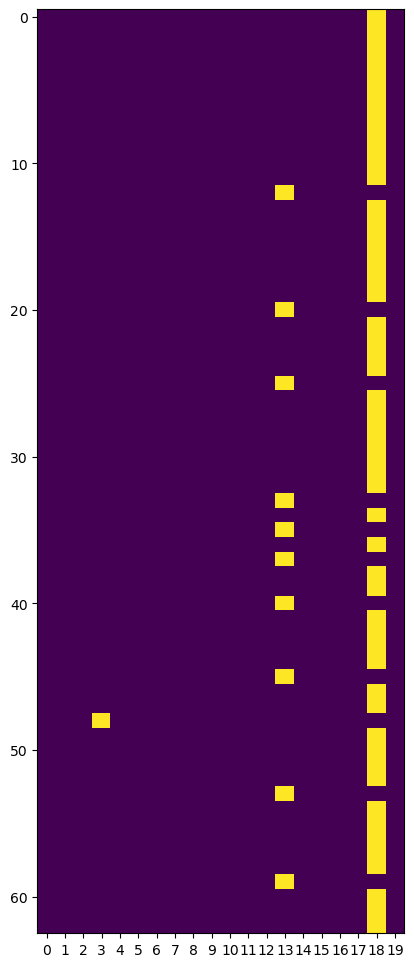

In [77]:
fig=plt.figure(figsize=(12,12), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(testprobs, aspect=0.8)
plt.xticks(testprobs.columns)
plt.show()

In [78]:
[x for x in best_model['membership_probs'][best_model['membership_probs'][10]>=0.9].index if 'to VP' in x]

['advertise-NP V to NP to VP[+eventive]',
 'affect-NP be V to VP[+eventive]',
 'agree-NP V to NP to VP[+eventive]',
 'bother-NP V to VP[+eventive]',
 'change-NP V to VP[+eventive]',
 'conjecture-NP V to VP[+eventive]',
 'consider-NP V to VP[+eventive]',
 'debate-NP V to VP[-eventive]',
 'deliberate-NP V for NP to VP',
 'discover-NP V to VP[-eventive]',
 'endure-NP V to VP[-eventive]',
 'ensure-NP be V to VP[-eventive]',
 'infer-NP V to VP[+eventive]',
 'instruct-NP V to VP[+eventive]',
 'keep-NP be V to VP[+eventive]',
 'murmur-NP V to VP[+eventive]',
 'observe-NP be V to VP[+eventive]',
 'ponder-NP V to VP[+eventive]',
 'query-NP be V to VP[+eventive]',
 'reason-NP V to VP[+eventive]',
 'remain-NP V for NP to VP',
 'renegotiate-NP V for NP to VP',
 'teach-NP V to VP[+eventive]',
 'tout-NP V to NP to VP[-eventive]',
 'trigger-NP V to VP[+eventive]']

We label these clusters on the basis of the verb-frame pairs that fall into them and the inference patterns associated with them.

In [79]:
# Notes
# -----
# The following observations arise from looking at the clusters of verb-frames we found in the previous finite analysis, and checking which clusters those finite
# verb-frames are allocated to in the new analysis. I then look at the non-finite items
#
#
# Representationals got split between 3 and 12. 3 seems to be more focused around belief/agreement, whereas 12 is more focused around discovery/learning?
# 3 also seems to contain expectations/desires about others, such as "NP want NP to have something". 12 is similar but again seems to be more oriented around belief
# formation, and also triggers inferences about the beliefs/desires of the subject, unlike 3.

# Speculatives generally seem to map to 13.
# 13 doesn't seem to contain many nonfinite, but generally seems to be focused around forbidding/discouraging another person to do something (this is the only cluster
# where "A intend/want B" consequents are false in positive polarity).

# Many Future Commitment items get mapped to 12. A few (such as "NP advocated that S") get mapped to 9.

# Discourse Commitment items are fairly evenly split between 4, 5, and 10. The ones in 4 seem to be related to addressing/answering, whereas 5 seems to be
# more future-oriented, with items related to acknowledging/addressing. The ones in 10 seem to be stronger, e.g. assert/vow.
# In terms of nonfinite items:
# * the ones in 4 seem to focus on commitment + desire of the subject (e.g. "NP asked to VP", "NP demanded to VP"), though there are a couple command/compel verbs interspersed.
# * the ones in 5 seem to focus more on commitment + anti-desire of the subject, such as "was commanded" and "was coerced".
# * 10 seems to contain a variety of communicatives but is a bit more unclear to me.

# Strong Communicatives get split between mostly 5 and 10.

# Weak Communicatives are mostly split between 13 and 15, but are a bit all over the place.

# Nearly all Deceptives get mapped to 11. This also seems to contain nonfinite predicates such as "decline", "deny", and "disallow".

# Miratives and Antidoxastics get mostly mapped to 14, but many are mapped to 2. The miratives seem to get mapped to 14, and the antidoxastics to 2.
# I couldn't find much sense in the nonfinite items in either 14 or 2, but perhaps I need to scrutinize them more.

# Preferentials get mostly mapped to 16. The nonfinite items in 16 also appear to be preferential.

# Negative Emotive Communicatives seem to get split all over; primarily 4 and 7. The negative emotive items seem to go primarily to 7.
# The nonfinite items in 7 also seem to be vaguely negative emotives, but are a bit all over the place.

# Negative Emotive Miratives seem to get split between 0 and 2. The more negative emotive items seem to go mostly to 0, whereas the more mirative items
# seem to go mostly to 2.
# The nonfinite items in 0 seem to be mostly negative emotives as well.

# Negative External Emotives are nearly all mapped to 0.

# Negative Internal Emotives are nearly all mapped to 8.
# The nonfinite items in 8 seem to be mostly negative internal emotives as well.

# Positive External Emotives seem to get scattered all over. Ones like "NP bluffed that S" and "NP was congratulated that S" are mapped to 0, ones like 
# "NP was consoled that S" and "NP was fascinated that S" are mapped to 4, and "NP was blessed/content/impressed that S" are mapped to 6.

# Positive Internal Emotives are nearly all mapped to 6.
# The nonfinite items in 6 also seem to be generally positive emotives, though they're a bit all over the place.



# -----


# TODO vvvvvvvvv

# cluster_labels = {0: 'Negative External Emotives',
#                   1: 'Weak Preferentials (?)',
#                   2: 'Antidoxastics',
#                   3: 'Representationals',
#                   4: 'Positive Discourse Commitment',
#                   5: 'Negative (?) Discourse Commitment',
#                   6: 'Positive Emotives',
#                   7: 'Negative Emotive Communicatives',
#                   8: 'Negative Internal Emotives',
#                   9: 'Future Commitment',
#                   10: 'Strong Communicatives',
#                   11: 'Deceptives',
#                   12: 'Discovery',
#                   13: 'Speculatives',
#                   14: 'Miratives',
#                   15: 'Weak Communicatives',
#                   16: 'Strong Preferentials'}
# cluster_labels_inv = { v:k for k,v in cluster_labels.items() }
# cluster_order = [cluster_labels[i] for i in [3, 13, 12, 4, 5, 9, 10, 15, 11, 14, 2, 16, 1, 7, 0, 8, 6]]

cluster_labels = {i: str(i) for i in range(best_n_components)}
cluster_order = [cluster_labels[i] for i in list(cluster_labels.keys())]

cluster_order

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19']

Figures 4-6 of the paper plot the means for each cluster relative to each view.

In [80]:
best_model['belief_desire_value'] = (1 * best_model['belief_desire_theta_1']
                                     + 0 * best_model['belief_desire_theta_0']
                                     + best_model['belief_desire_locs'] * best_model['belief_desire_theta_prior'])

best_model['belief_desire_value']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
negative-object-na-believe,5.438659e-01,9.766078e-01,1.000000e+00,2.314264e-09,1.807635e-14,1.000000e+00,5.239731e-02,1.000000e+00,3.433331e-08,1.569220e-10,1.610819e-07,1.000000e+00,2.143021e-09,9.987727e-01,9.858161e-04,5.248958e-03,2.090690e-01,1.000000e+00,1.832264e-07,8.979124e-08
negative-object-na-want,9.608988e-01,9.999994e-01,9.999999e-01,3.671359e-02,6.523817e-07,1.000000e+00,1.255464e-15,1.000000e+00,8.248288e-08,1.252050e-06,2.038284e-02,1.000000e+00,2.864104e-07,3.970998e-15,3.835756e-01,2.209841e-06,3.852078e-01,1.000000e+00,6.904900e-08,8.549358e-07
negative-object-object-believe,5.865900e-08,4.777005e-03,1.473075e-04,8.795358e-10,4.994235e-01,9.999998e-01,9.999998e-01,9.997275e-01,1.000000e+00,4.993553e-01,2.911576e-12,9.999882e-01,4.804895e-01,4.090225e-07,9.332522e-07,5.801709e-15,1.463342e-01,5.420009e-08,4.996734e-01,1.078529e-01
negative-object-object-intend,7.746553e-11,1.560115e-01,2.467690e-07,1.020334e-07,6.064264e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.983187e-01,7.170375e-08,3.544240e-02,4.999673e-01,2.042660e-04,2.964794e-07,3.175373e-13,4.717870e-01,3.355007e-08,4.983218e-01,3.333566e-04
negative-object-object-want,6.726284e-02,5.008988e-12,1.101392e-03,1.604781e-08,9.998087e-01,9.999906e-01,1.000000e+00,1.000000e+00,9.990290e-01,4.997104e-01,1.198055e-10,4.999997e-01,4.999940e-01,1.298605e-04,3.507998e-06,1.590726e-02,4.999981e-01,3.200531e-10,4.056761e-01,2.444663e-04
negative-object-subject-believe,2.630227e-01,2.565135e-01,4.496968e-10,2.885598e-01,2.757944e-01,1.733170e-01,4.970620e-01,8.898335e-09,4.503544e-02,9.708758e-10,3.930603e-10,2.792134e-01,2.361358e-01,9.999899e-01,2.600694e-06,3.119428e-01,3.124860e-02,2.208692e-01,3.195504e-08,4.434895e-09
negative-object-subject-intend,3.542407e-01,3.279818e-01,4.758262e-01,4.334361e-01,3.596409e-01,2.480887e-01,6.118489e-08,4.999511e-01,2.614251e-01,8.662946e-02,1.941035e-01,5.615985e-01,5.415177e-01,4.977266e-01,2.039643e-02,5.938723e-01,5.655058e-02,2.144698e-02,4.408462e-05,2.517735e-01
negative-object-subject-want,3.162926e-01,3.586792e-01,3.408905e-01,3.941338e-01,4.085665e-01,2.398855e-01,3.249713e-01,5.000045e-01,3.832437e-01,7.716152e-01,2.035871e-01,3.445033e-01,3.757599e-01,9.995093e-01,4.394578e-04,4.373439e-01,3.072526e-01,3.914686e-01,4.675366e-10,3.987168e-01
negative-subject-na-believe,3.188527e-16,1.000000e+00,2.388198e-08,2.106449e-05,1.000000e+00,1.000000e+00,2.481293e-10,1.000000e+00,2.808435e-01,1.206753e-01,4.211894e-06,4.503591e-08,1.470630e-04,9.931338e-01,7.082974e-01,4.558789e-01,2.759774e-08,9.675598e-01,9.990176e-01,5.271740e-06
negative-subject-na-want,2.493057e-07,1.000000e+00,9.193913e-09,5.301736e-16,1.000000e+00,1.000000e+00,8.474185e-05,1.000000e+00,4.105902e-08,1.910980e-07,1.025951e-08,4.289580e-08,6.598036e-07,4.999643e-01,4.991243e-01,4.919768e-01,4.530834e-08,4.298631e-08,7.410849e-17,2.004646e-07


In [81]:
best_belief_desire_locs = best_model['belief_desire_value']

factors = np.array([np.array(x) for x 
                    in best_belief_desire_locs.index.str.split('-', expand=True).values])
best_belief_desire_locs[['polarity', 'target', 'control', 'consequent_verb']] = factors

best_belief_desire_locs['template'] = best_belief_desire_locs.polarity.map({'positive': 'A __ ((to) B)',
                                                                          'negative': 'A not __ ((to) B)'}) + ' ' +\
                                      best_belief_desire_locs.control.map({'subject': 'to VP', 'object': 'to VP',
                                                                           'na': 'that S'}) + ' ~> ' +\
                                      best_belief_desire_locs.target.map({'subject': 'A',
                                                                          'object': 'B'}) + ' ' +\
                                      best_belief_desire_locs.consequent_verb + 's ' +\
                                      best_belief_desire_locs.control.map({'subject': 'A ',
                                                                          'object': 'B ',
                                                                          'na':''}) +\
                                      best_belief_desire_locs.control.map({'subject': 'VP', 'object': 'VP',
                                                                           'na': 'S'})

best_belief_desire_locs_melt = pd.melt(best_belief_desire_locs.drop(columns=['target', 'control', 'consequent_verb']), 
                                       id_vars=['polarity', 'template'])

best_belief_desire_locs_melt = best_belief_desire_locs_melt.drop(columns='polarity')

best_belief_desire_locs_melt['label'] = best_belief_desire_locs_melt.variable.map(cluster_labels)
best_belief_desire_locs_melt['inferencetype'] = best_belief_desire_locs_melt.template.map(lambda x: 'doxastic' if 'believe' in x else 'bouletic' if 'want' in x else 'intention')

best_belief_desire_locs_melt

,template,variable,value,label,inferencetype
0,A not __ ((to) B) that S ~> B believes S,0,5.438659e-01,0,doxastic
1,A not __ ((to) B) that S ~> B wants S,0,9.608988e-01,0,bouletic
2,A not __ ((to) B) to VP ~> B believes B VP,0,5.865900e-08,0,doxastic
3,A not __ ((to) B) to VP ~> B intends B VP,0,7.746553e-11,0,intention
4,A not __ ((to) B) to VP ~> B wants B VP,0,6.726284e-02,0,bouletic
...,...,...,...,...,...
635,A __ ((to) B) to VP ~> A intends B VP,19,1.000000e+00,19,intention
636,A __ ((to) B) to VP ~> A wants B VP,19,1.000000e+00,19,bouletic
637,A __ ((to) B) to VP ~> A believes A VP,19,1.000000e+00,19,doxastic
638,A __ ((to) B) to VP ~> A intends A VP,19,1.000000e+00,19,intention


In [82]:
best_veridicality_locs = best_model['veridicality_locs']

factors = np.array([np.array(x) for x 
                    in best_veridicality_locs.index.str.split('-', expand=True).values])

best_veridicality_locs['polarity'] = factors
best_veridicality_locs = best_veridicality_locs.explode('polarity')

best_veridicality_locs['template'] = best_veridicality_locs.polarity.map({'positive': 'A __ that/to S/VP',
                                                                         'negative': 'A not __ that/to S/VP'}) + ' ~> S/VP'

best_veridicality_locs_melt = pd.melt(best_veridicality_locs, 
                                       id_vars=['polarity', 'template'])

best_veridicality_locs_melt = best_veridicality_locs_melt.drop(columns="polarity")

veridicality_jumps = parameters[best_n_components]['veridicality_jumps_participant']
veridicality_cuts = veridicality_jumps.cumsum(axis=1) - veridicality_jumps.cumsum(axis=1).mean()

veridicality_cuts_mean = veridicality_cuts.mean(axis=0)

cumprobs = 1/(1+np.exp(-(veridicality_cuts_mean[None,:] - np.array(best_veridicality_locs_melt.value)[:,None])))
probs = np.concatenate([cumprobs[:,[0]], cumprobs[:,[1]] - cumprobs[:,[0]], 1-cumprobs[:,[1]]], axis=1)

best_veridicality_locs_melt['value'] = np.sum(probs*np.array([[0, 0.5, 1.]]), axis=1)
best_veridicality_locs_melt['label'] = best_veridicality_locs_melt.variable.map(cluster_labels)
best_veridicality_locs_melt['inferencetype'] = 'veridicality'

best_veridicality_locs_melt

,template,variable,value,label,inferencetype
0,A not __ that/to S/VP ~> S/VP,0,0.155219,0,veridicality
1,A __ that/to S/VP ~> S/VP,0,0.755122,0,veridicality
2,A not __ that/to S/VP ~> S/VP,1,0.803666,1,veridicality
3,A __ that/to S/VP ~> S/VP,1,0.887432,1,veridicality
4,A not __ that/to S/VP ~> S/VP,2,0.187110,2,veridicality
5,A __ that/to S/VP ~> S/VP,2,0.562291,2,veridicality
6,A not __ that/to S/VP ~> S/VP,3,0.172383,3,veridicality
7,A __ that/to S/VP ~> S/VP,3,0.702716,3,veridicality
8,A not __ that/to S/VP ~> S/VP,4,0.179731,4,veridicality
9,A __ that/to S/VP ~> S/VP,4,0.665589,4,veridicality


In [83]:
best_model['negraising_value'] = (1 * best_model['negraising_theta_1']
                                  + 0 * best_model['negraising_theta_0']
                                  + best_model['negraising_locs'] * best_model['negraising_theta_prior'])

best_model['negraising_value']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
first-past,0.981716,0.005196,0.999999,0.573529,0.009196,3.264807e-10,0.000518,1.377645e-08,0.076911,9.499433e-09,0.499998,0.215766,0.000117,7.987031e-05,1.009435e-05,0.000060,0.999908,0.493765,0.000663,0.000021
first-present,0.995313,0.000022,1.000000,0.489642,0.002331,4.992870e-01,0.307179,4.288388e-02,0.002197,1.903938e-06,0.491862,0.998386,0.186823,1.930420e-08,1.651014e-13,0.000368,0.999997,0.179239,0.111154,0.026451
third-past,0.999932,0.000026,1.000000,0.112889,0.000110,6.834413e-03,0.000006,5.297663e-05,0.010577,9.770382e-06,0.011394,0.828965,0.007827,8.907773e-02,3.967826e-02,0.000001,0.993566,0.007640,0.020494,0.000077
third-present,0.999628,0.000482,1.000000,0.897756,0.000002,2.050212e-01,0.001597,3.356167e-04,0.000265,2.014575e-05,0.697752,0.665112,0.500424,8.225033e-07,5.022887e-03,0.000027,0.998907,0.039483,0.000302,0.030900


In [84]:
best_negraising_locs = best_model['negraising_value']

factors = np.array([np.array(x) for x 
                    in best_negraising_locs.index.str.split('-', expand=True).values])
best_negraising_locs[['person', 'tense']] = factors

best_negraising_locs['template'] = best_negraising_locs.person.map({'first': 'A[1s]', 'third': 'A[3s]'}) + ' not ' +\
                                   best_negraising_locs.tense.map({'past': '__[past]', 'present': '__[pres]'}) + ' ' +\
                                   'S ~> ' +\
                                   best_negraising_locs.person.map({'first': 'A[1s]', 'third': 'A[3s]'}) + ' ' +\
                                   best_negraising_locs.tense.map({'past': '__[past]', 'present': '__[pres]'}) + ' ' +\
                                   'not S'

best_negraising_locs_melt = pd.melt(best_negraising_locs.drop(columns=['person', 'tense']), 
                                       id_vars='template')

best_negraising_locs_melt['label'] = best_negraising_locs_melt.variable.map(cluster_labels)

best_negraising_locs_melt['inferencetype'] = 'negraising'

best_negraising_locs_melt

,template,variable,value,label,inferencetype
0,A[1s] not __[past] S ~> A[1s] __[past] not S,0,0.981716,0,negraising
1,A[1s] not __[pres] S ~> A[1s] __[pres] not S,0,0.995313,0,negraising
2,A[3s] not __[past] S ~> A[3s] __[past] not S,0,0.999932,0,negraising
3,A[3s] not __[pres] S ~> A[3s] __[pres] not S,0,0.999628,0,negraising
4,A[1s] not __[past] S ~> A[1s] __[past] not S,1,0.005196,1,negraising
...,...,...,...,...,...
75,A[3s] not __[pres] S ~> A[3s] __[pres] not S,18,0.000302,18,negraising
76,A[1s] not __[past] S ~> A[1s] __[past] not S,19,0.000021,19,negraising
77,A[1s] not __[pres] S ~> A[1s] __[pres] not S,19,0.026451,19,negraising
78,A[3s] not __[past] S ~> A[3s] __[past] not S,19,0.000077,19,negraising


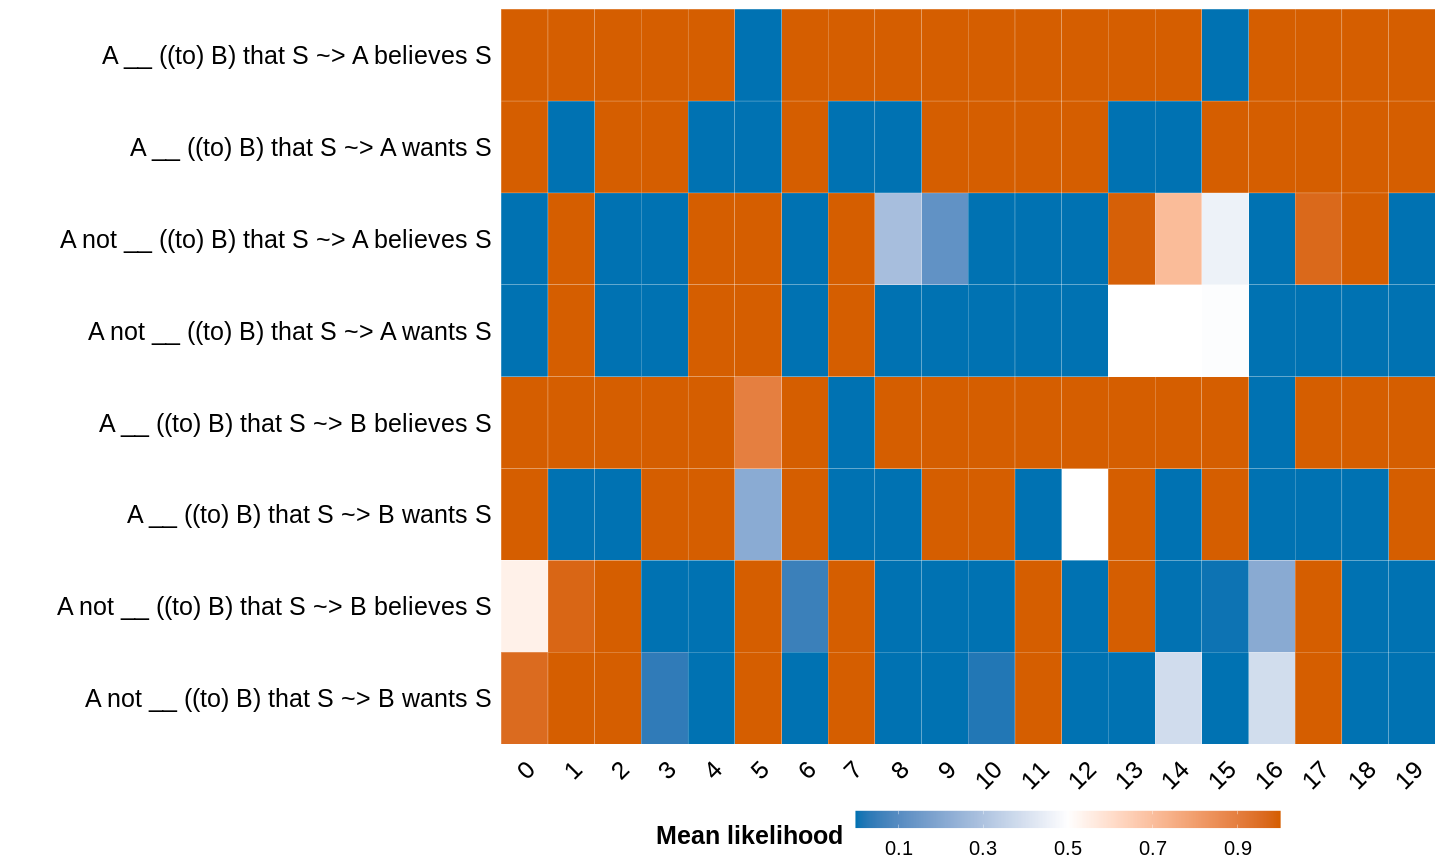

In [85]:
%%R -i best_belief_desire_locs_melt -i cluster_order -w 20 -h 12 -u in

library(tidyverse)

theme_set(theme_bw())

belief_desire_template_order_f = rev(c('A __ ((to) B) that S ~> A believes S',
                                       'A __ ((to) B) that S ~> A wants S',
                                       'A not __ ((to) B) that S ~> A believes S',
                                       'A not __ ((to) B) that S ~> A wants S',
                                       'A __ ((to) B) that S ~> B believes S',
                                       'A __ ((to) B) that S ~> B wants S',
                                       'A not __ ((to) B) that S ~> B believes S',
                                       'A not __ ((to) B) that S ~> B wants S'))

best_belief_desire_locs_melt <- filter(best_belief_desire_locs_melt, template%in%belief_desire_template_order_f)
best_belief_desire_locs_melt$template <- ordered(best_belief_desire_locs_melt$template,
                                                levels=belief_desire_template_order_f)

# cluster_order = c('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19')

best_belief_desire_locs_melt$label <- ordered(best_belief_desire_locs_melt$label,
                                                levels=cluster_order)


g = ggplot(best_belief_desire_locs_melt, aes(y=template, x=label, fill=value-0.5)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00", 
                     breaks=c(-0.4, -0.2, 0, 0.2, 0.4),
                     labels=c(-0.4, -0.2, 0, 0.2, 0.4)+0.5) +
theme(axis.text=element_text(size=25, color="black"),
      axis.text.x=element_text(angle=45, hjust=1),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=25, face="bold"),
      legend.text=element_text(size=20), 
      legend.key.width=unit(3, "cm"),
      legend.position="bottom",
      panel.background=element_blank(),
      panel.border=element_blank(),
      panel.grid.major=element_blank(),
      panel.grid.minor=element_blank(),
      plot.background=element_blank(),
     strip.background=element_rect(fill="white", color="white"),
     strip.text=element_text(size=25, face="bold"),
     plot.margin=unit(c(0,0,0,2),"cm"))



ggsave('plots/finite_belief_desire-loadings-15.pdf', width=20, height=12)
ggsave('plots/finite_belief_desire-loadings-15.png', width=20, height=12)

g

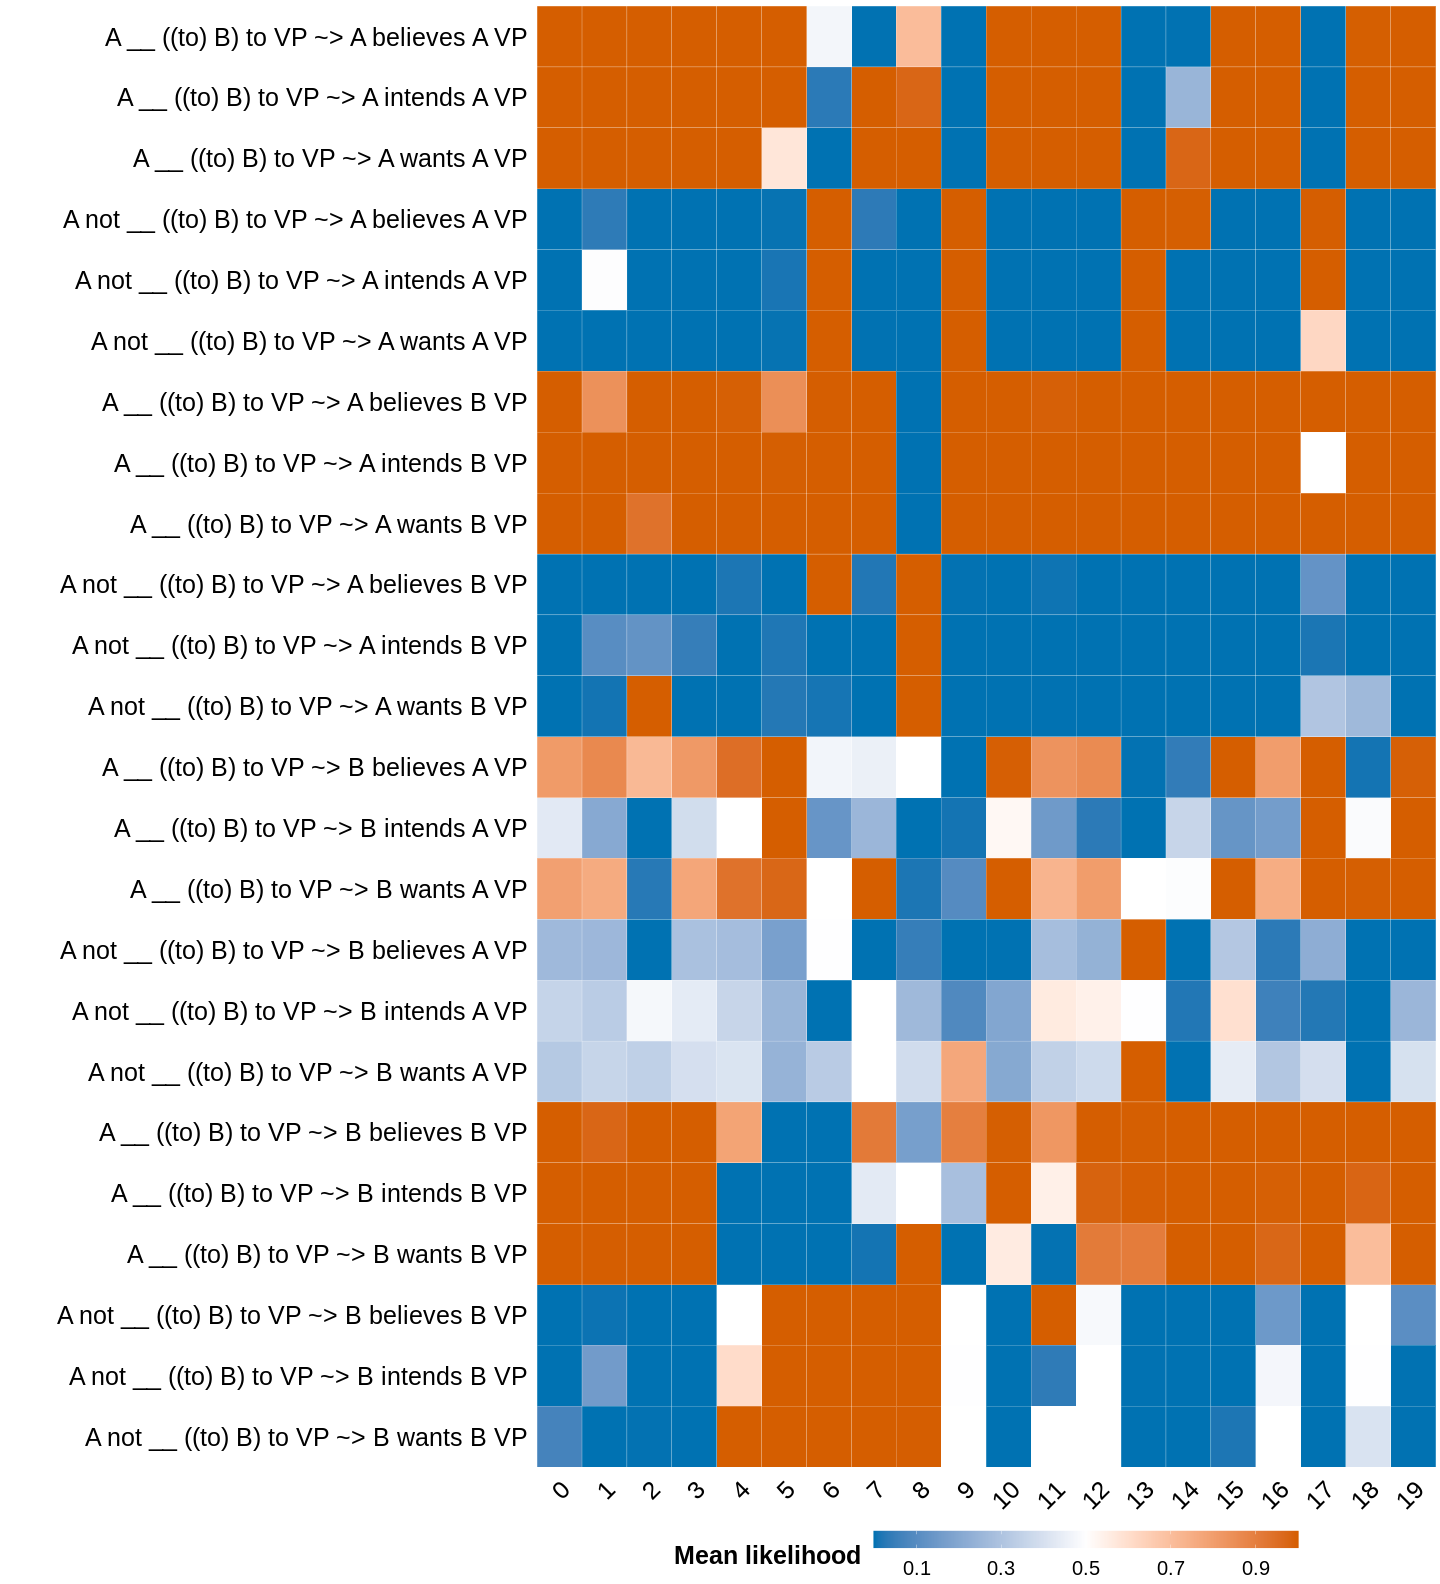

In [86]:
%%R -i best_belief_desire_locs_melt -i cluster_order -w 20 -h 22 -u in

library(tidyverse)

theme_set(theme_bw())

belief_desire_template_order_nf = rev(c('A __ ((to) B) to VP ~> A believes A VP',
                                        'A __ ((to) B) to VP ~> A intends A VP',
                                        'A __ ((to) B) to VP ~> A wants A VP',
                                        'A not __ ((to) B) to VP ~> A believes A VP',
                                        'A not __ ((to) B) to VP ~> A intends A VP',
                                        'A not __ ((to) B) to VP ~> A wants A VP',
                                        'A __ ((to) B) to VP ~> A believes B VP',
                                        'A __ ((to) B) to VP ~> A intends B VP',
                                        'A __ ((to) B) to VP ~> A wants B VP',
                                        'A not __ ((to) B) to VP ~> A believes B VP',
                                        'A not __ ((to) B) to VP ~> A intends B VP',
                                        'A not __ ((to) B) to VP ~> A wants B VP',
                                        'A __ ((to) B) to VP ~> B believes A VP',
                                        'A __ ((to) B) to VP ~> B intends A VP',
                                        'A __ ((to) B) to VP ~> B wants A VP',
                                        'A not __ ((to) B) to VP ~> B believes A VP',
                                        'A not __ ((to) B) to VP ~> B intends A VP',
                                        'A not __ ((to) B) to VP ~> B wants A VP',
                                        'A __ ((to) B) to VP ~> B believes B VP',
                                        'A __ ((to) B) to VP ~> B intends B VP',
                                        'A __ ((to) B) to VP ~> B wants B VP',
                                        'A not __ ((to) B) to VP ~> B believes B VP',
                                        'A not __ ((to) B) to VP ~> B intends B VP',
                                        'A not __ ((to) B) to VP ~> B wants B VP'))

best_belief_desire_locs_melt <- filter(best_belief_desire_locs_melt, template%in%belief_desire_template_order_nf)
best_belief_desire_locs_melt$template <- ordered(best_belief_desire_locs_melt$template,
                                                levels=belief_desire_template_order_nf)

best_belief_desire_locs_melt$label <- ordered(best_belief_desire_locs_melt$label,
                                                levels=cluster_order)


g = ggplot(best_belief_desire_locs_melt, aes(y=template, x=label, fill=value-0.5)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00", 
                     breaks=c(-0.4, -0.2, 0, 0.2, 0.4),
                     labels=c(-0.4, -0.2, 0, 0.2, 0.4)+0.5) +
theme(axis.text=element_text(size=25, color="black"),
      axis.text.x=element_text(angle=45, hjust=1),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=25, face="bold"),
      legend.text=element_text(size=20), 
      legend.key.width=unit(3, "cm"),
      legend.position="bottom",
      panel.background=element_blank(),
      panel.border=element_blank(),
      panel.grid.major=element_blank(),
      panel.grid.minor=element_blank(),
      plot.background=element_blank(),
     strip.background=element_rect(fill="white", color="white"),
     strip.text=element_text(size=25, face="bold"),
     plot.margin=unit(c(0,0,0,2),"cm"))



ggsave('plots/nonfinite_belief_desire-loadings-15.pdf', width=20, height=22)
ggsave('plots/nonfinite_belief_desire-loadings-15.png', width=20, height=22)

g

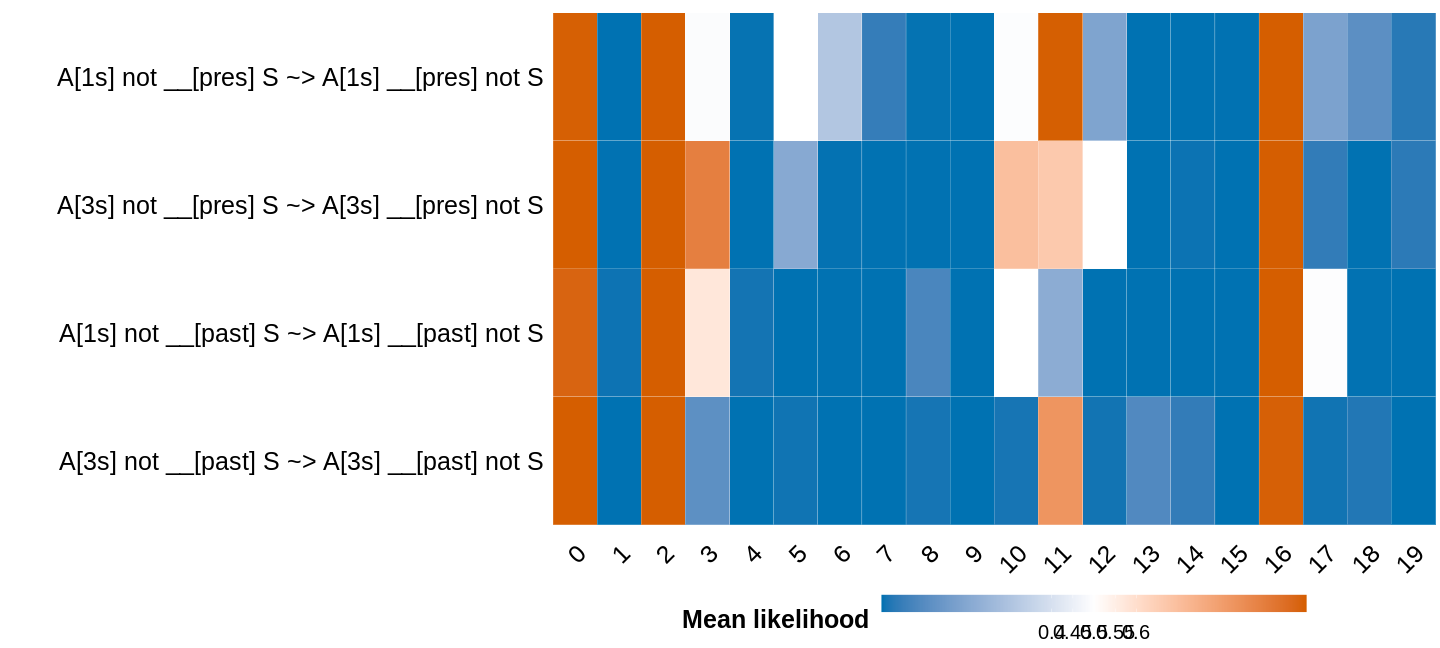

In [87]:
%%R -i best_negraising_locs_melt -i cluster_order -w 20 -h 9 -u in

library(tidyverse)

theme_set(theme_bw())

negraising_template_order = rev(c('A[1s] not __[pres] S ~> A[1s] __[pres] not S',
                                  'A[3s] not __[pres] S ~> A[3s] __[pres] not S',
                                  'A[1s] not __[past] S ~> A[1s] __[past] not S',
                                  'A[3s] not __[past] S ~> A[3s] __[past] not S'))

best_negraising_locs_melt$template <- ordered(best_negraising_locs_melt$template,
                                              levels=negraising_template_order)

best_negraising_locs_melt$label <- ordered(best_negraising_locs_melt$label,
                                           levels=cluster_order)

g = ggplot(best_negraising_locs_melt, aes(y=template, x=label, fill=value-0.5)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00", 
                     breaks=c(-0.1, -0.05, 0, 0.05, 0.1),
                     labels=c(-0.1, -0.05, 0, 0.05, 0.1)+0.5) +
theme(axis.text=element_text(size=25, color="black"),
      axis.text.x=element_text(angle=45, hjust=1),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=25, face="bold"),
      legend.text=element_text(size=20), 
      legend.key.width=unit(3, "cm"),
      legend.position="bottom",
      panel.background=element_blank(),
      panel.border=element_blank(),
      panel.grid.major=element_blank(),
      panel.grid.minor=element_blank(),
      plot.background=element_blank(),
     strip.background=element_rect(fill="white", color="white"),
     strip.text=element_text(size=25, face="bold"),
     plot.margin=unit(c(0,0,0,2),"cm"))

ggsave('plots/negraising-loadings-15.pdf', width=20, height=9)
ggsave('plots/negraising-loadings-15.png', width=20, height=9)

g

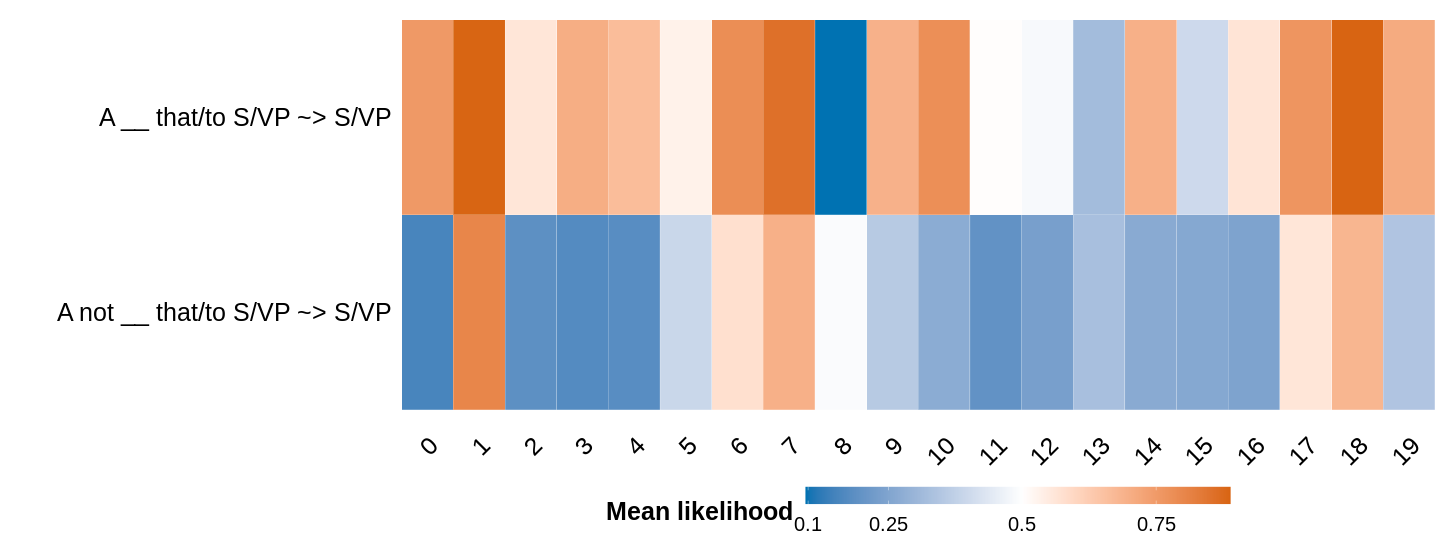

In [88]:
%%R -i best_veridicality_locs_melt -i cluster_order -w 20 -h 7.5 -u in

library(tidyverse)

theme_set(theme_bw())

veridicality_template_order = rev(c('A __ that/to S/VP ~> S/VP', 'A not __ that/to S/VP ~> S/VP'))

best_veridicality_locs_melt$template <- ordered(best_veridicality_locs_melt$template, 
                                                 levels=veridicality_template_order)

best_veridicality_locs_melt$label <- ordered(best_veridicality_locs_melt$label,
                                             levels=cluster_order)

g = ggplot(best_veridicality_locs_melt, aes(y=template, x=label, fill=value-0.5)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00", 
                     breaks=c(-0.4, -0.25, 0, 0.25, 0.4),
                     labels=c(-0.4, -0.25, 0, 0.25, 0.4)+0.5) +
theme(axis.text=element_text(size=25, color="black"),
      axis.text.x=element_text(angle=45, hjust=1),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=25, face="bold"),
      legend.text=element_text(size=20), 
      legend.key.width=unit(3, "cm"),
      legend.position="bottom",
      panel.background=element_blank(),
      panel.border=element_blank(),
      panel.grid.major=element_blank(),
      panel.grid.minor=element_blank(),
      plot.background=element_blank(),
     strip.background=element_rect(fill="white", color="white"),
     strip.text=element_text(size=25, face="bold"),
     plot.margin=unit(c(0,0,0,2),"cm"))

ggsave('plots/veridicality-loadings-15.png', width=20, height=7.5)
ggsave('plots/veridicality-loadings-15.pdf', width=20, height=7.5)

g

To determine a set of generalizations about these clusters, we apply principal component analysis (PCA) to the parameters of the property-specific probability distributions for each cluster.

In [89]:
all_locs_melt = pd.concat([best_veridicality_locs_melt,
                           best_negraising_locs_melt,
                           best_belief_desire_locs_melt])

all_locs = all_locs_melt.pivot_table(index='label', columns='template', values='value')

all_locs

template,A __ ((to) B) that S ~> A believes S,A __ ((to) B) that S ~> A wants S,A __ ((to) B) that S ~> B believes S,A __ ((to) B) that S ~> B wants S,A __ ((to) B) to VP ~> A believes A VP,A __ ((to) B) to VP ~> A believes B VP,A __ ((to) B) to VP ~> A intends A VP,A __ ((to) B) to VP ~> A intends B VP,A __ ((to) B) to VP ~> A wants A VP,A __ ((to) B) to VP ~> A wants B VP,...,A not __ ((to) B) to VP ~> B believes B VP,A not __ ((to) B) to VP ~> B intends A VP,A not __ ((to) B) to VP ~> B intends B VP,A not __ ((to) B) to VP ~> B wants A VP,A not __ ((to) B) to VP ~> B wants B VP,A not __ that/to S/VP ~> S/VP,A[1s] not __[past] S ~> A[1s] __[past] not S,A[1s] not __[pres] S ~> A[1s] __[pres] not S,A[3s] not __[past] S ~> A[3s] __[past] not S,A[3s] not __[pres] S ~> A[3s] __[pres] not S
label,,,,,,,,,,,,,,,,,,,,,
0,1.000000e+00,1.000000e+00,9.999998e-01,1.000000e+00,1.000000e+00,1.000000,9.999999e-01,1.000000e+00,9.999992e-01,1.000000e+00,...,5.865900e-08,3.542407e-01,7.746553e-11,3.162926e-01,6.726284e-02,0.155219,9.817159e-01,9.953125e-01,0.999932,9.996278e-01
1,9.999882e-01,4.968344e-16,9.999894e-01,6.133657e-09,9.999982e-01,0.842227,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,4.777005e-03,3.279818e-01,1.560115e-01,3.586792e-01,5.008988e-12,0.803666,5.196214e-03,2.215818e-05,0.000026,4.818239e-04
10,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.999998e-01,0.999982,9.999993e-01,1.000000e+00,1.000000e+00,1.000000e+00,...,2.911576e-12,1.941035e-01,7.170375e-08,2.035871e-01,1.198055e-10,0.269616,4.999981e-01,4.918619e-01,0.011394,6.977518e-01
11,1.000000e+00,1.000000e+00,9.999989e-01,8.194403e-16,1.000000e+00,0.992973,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,9.999882e-01,5.615985e-01,3.544240e-02,3.445033e-01,4.999997e-01,0.195388,2.157663e-01,9.983863e-01,0.828965,6.651120e-01
12,1.000000e+00,1.000000e+00,1.000000e+00,5.000069e-01,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,4.804895e-01,5.415177e-01,4.999673e-01,3.757599e-01,4.999940e-01,0.234449,1.171832e-04,1.868229e-01,0.007827,5.004243e-01
13,9.999541e-01,1.481229e-09,1.000000e+00,1.000000e+00,3.720825e-05,1.000000,2.074179e-10,1.000000e+00,1.702746e-08,1.000000e+00,...,4.090225e-07,4.977266e-01,2.042660e-04,9.995093e-01,1.298605e-04,0.325022,7.987031e-05,1.930420e-08,0.089078,8.225033e-07
14,9.999999e-01,6.167365e-14,9.999997e-01,5.250798e-10,3.999332e-04,0.999998,2.464371e-01,1.000000e+00,9.756455e-01,1.000000e+00,...,9.332522e-07,2.039643e-02,2.964794e-07,4.394578e-04,3.507998e-06,0.265620,1.009435e-05,1.651014e-13,0.039678,5.022887e-03
15,9.217679e-13,9.999983e-01,9.999969e-01,9.999999e-01,1.000000e+00,1.000000,1.000000e+00,9.999978e-01,1.000000e+00,1.000000e+00,...,5.801709e-15,5.938723e-01,3.175373e-13,4.373439e-01,1.590726e-02,0.258118,6.026640e-05,3.675919e-04,0.000001,2.745869e-05
16,1.000000e+00,1.000000e+00,2.783281e-07,2.873083e-10,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.463342e-01,5.655058e-02,4.717870e-01,3.072526e-01,4.999981e-01,0.244303,9.999084e-01,9.999970e-01,0.993566,9.989070e-01


In [90]:
pca_patterns = PCA().fit(all_locs.apply(lambda x: (x-x.mean())/x.std(), axis=0))

pca_patterns_components = pd.DataFrame(pca_patterns.components_, columns=all_locs.columns)

pca_patterns_components_melt = pd.melt(pca_patterns_components.T.reset_index(), id_vars="template")

pca_patterns_components_melt

,template,variable,value
0,A __ ((to) B) that S ~> A believes S,0,-0.005199
1,A __ ((to) B) that S ~> A wants S,0,-0.169313
2,A __ ((to) B) that S ~> B believes S,0,0.028827
3,A __ ((to) B) that S ~> B wants S,0,-0.001783
4,A __ ((to) B) to VP ~> A believes A VP,0,-0.213867
...,...,...,...
755,A not __ that/to S/VP ~> S/VP,19,-0.212940
756,A[1s] not __[past] S ~> A[1s] __[past] not S,19,-0.066984
757,A[1s] not __[pres] S ~> A[1s] __[pres] not S,19,0.120270
758,A[3s] not __[past] S ~> A[3s] __[past] not S,19,-0.186257


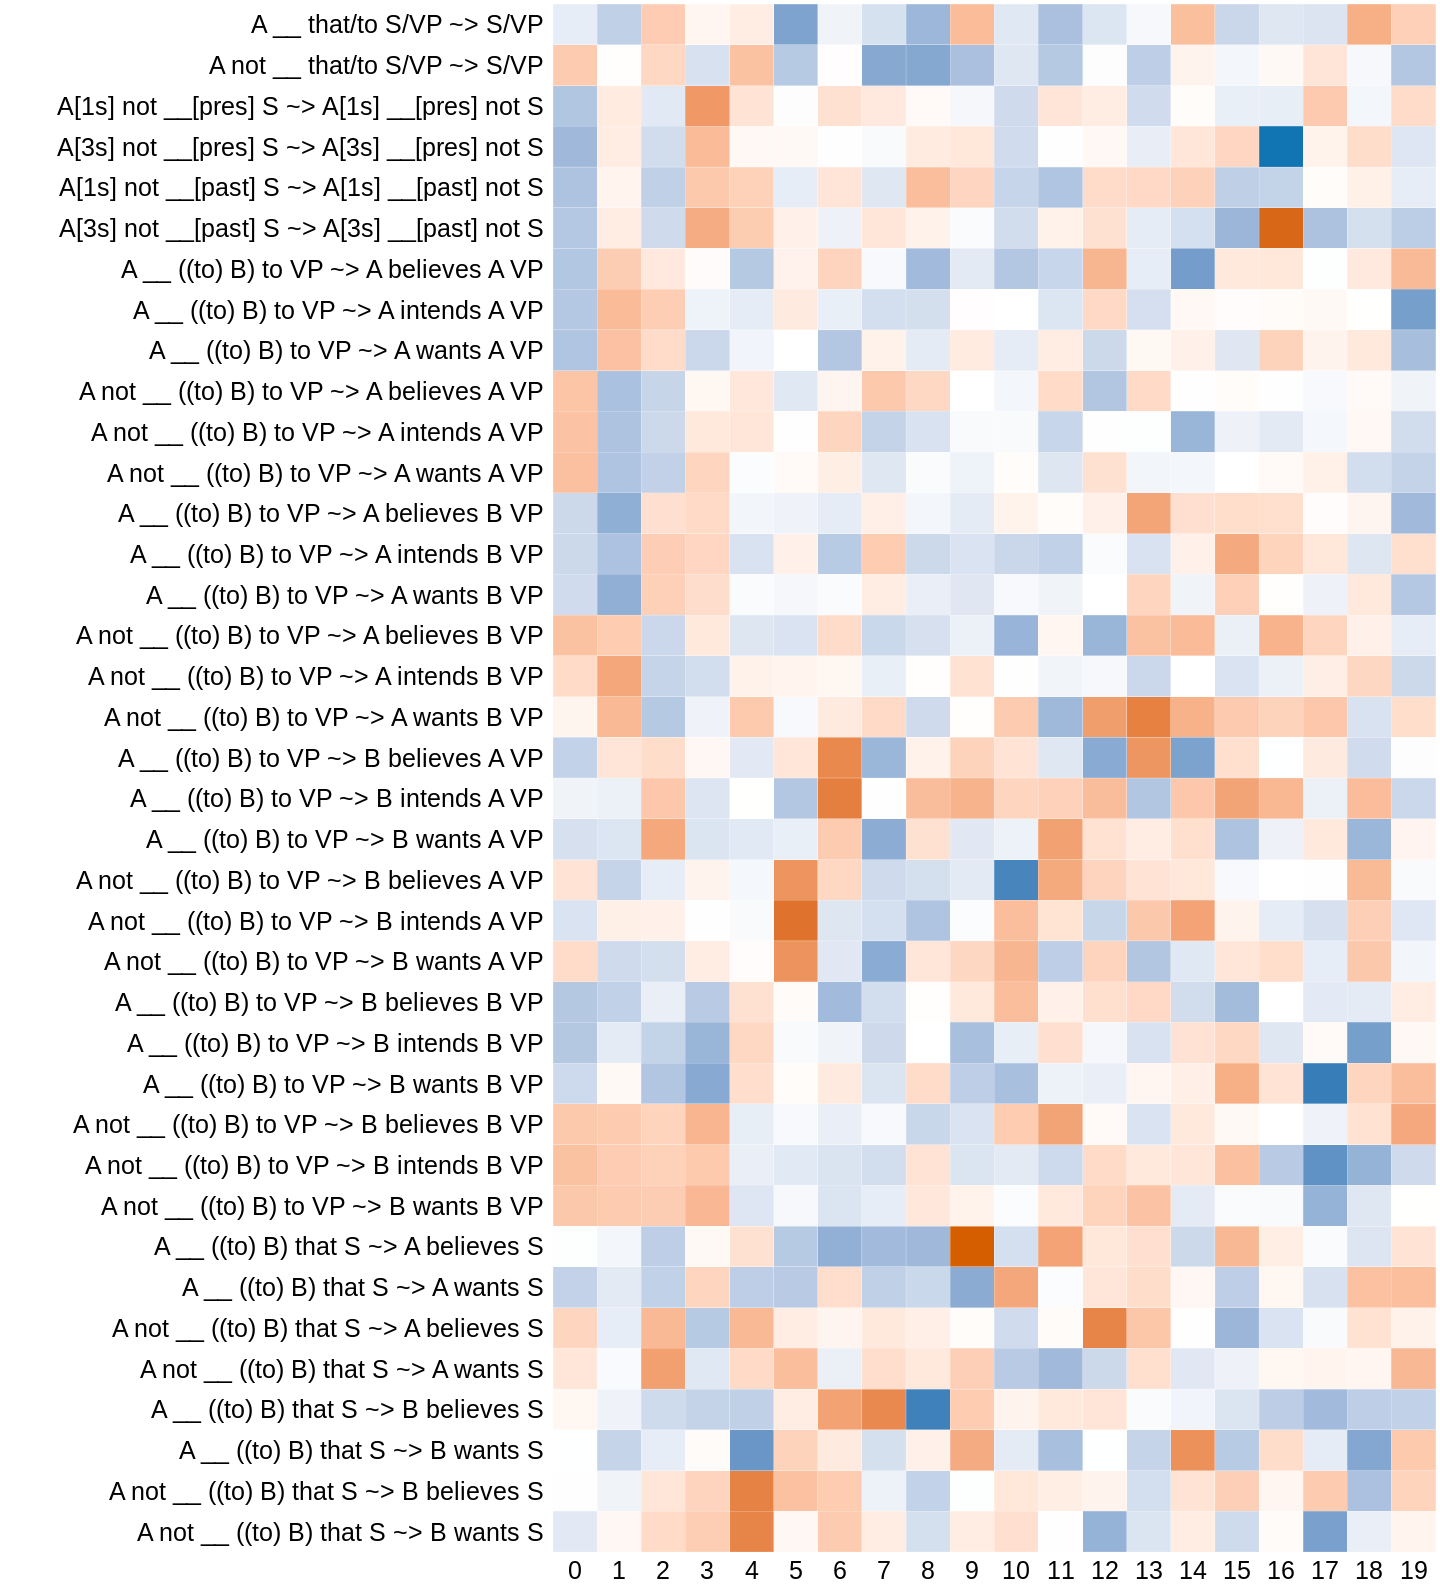

In [91]:
%%R -i pca_patterns_components_melt -w 20 -h 22 -u in

belief_desire_template_order = append(belief_desire_template_order_f, belief_desire_template_order_nf)
pca_patterns_components_melt$template = ordered(pca_patterns_components_melt$template,
                                      levels=c(belief_desire_template_order,
                                               negraising_template_order,
                                              veridicality_template_order))

g = ggplot(pca_patterns_components_melt, aes(y=template, x=as.factor(variable), fill=value)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00") +
theme(axis.text=element_text(size=25, color="black"),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      legend.position="none",
      panel.background=element_blank(),
      panel.border=element_blank(),
      panel.grid.major=element_blank(),
      panel.grid.minor=element_blank(),
      plot.background=element_blank(),
     strip.background=element_rect(fill="white", color="white"),
     strip.text=element_text(size=25, face="bold"),
     plot.margin=unit(c(0,0,0,2),"cm"))

ggsave('plots/pca-patterns-loadings-17.png', width=20, height=22)
ggsave('plots/pca-patterns-loadings-17.pdf', width=20, height=22)

g

In [92]:
all_locs_T = all_locs.apply(lambda x: (x-x.mean())/x.std(), axis=0).T
all_locs_T = all_locs_T.reindex(cluster_order, axis=1)
# all_locs_T.columns = all_locs_T.columns.astype(int)
all_locs_T.columns.name = None

pca_types = PCA().fit(all_locs_T)

pca_types_components = pd.DataFrame(pca_types.components_, columns=all_locs_T.columns)

pca_types_components_melt = pd.melt(pca_types_components.T.reset_index(), id_vars="index")

pca_types_components_melt

,index,variable,value
0,0,0,-0.317237
1,1,0,0.016498
2,2,0,-0.292350
3,3,0,-0.234808
4,4,0,0.080667
...,...,...,...
395,15,19,-0.223607
396,16,19,-0.223607
397,17,19,-0.223607
398,18,19,-0.223607


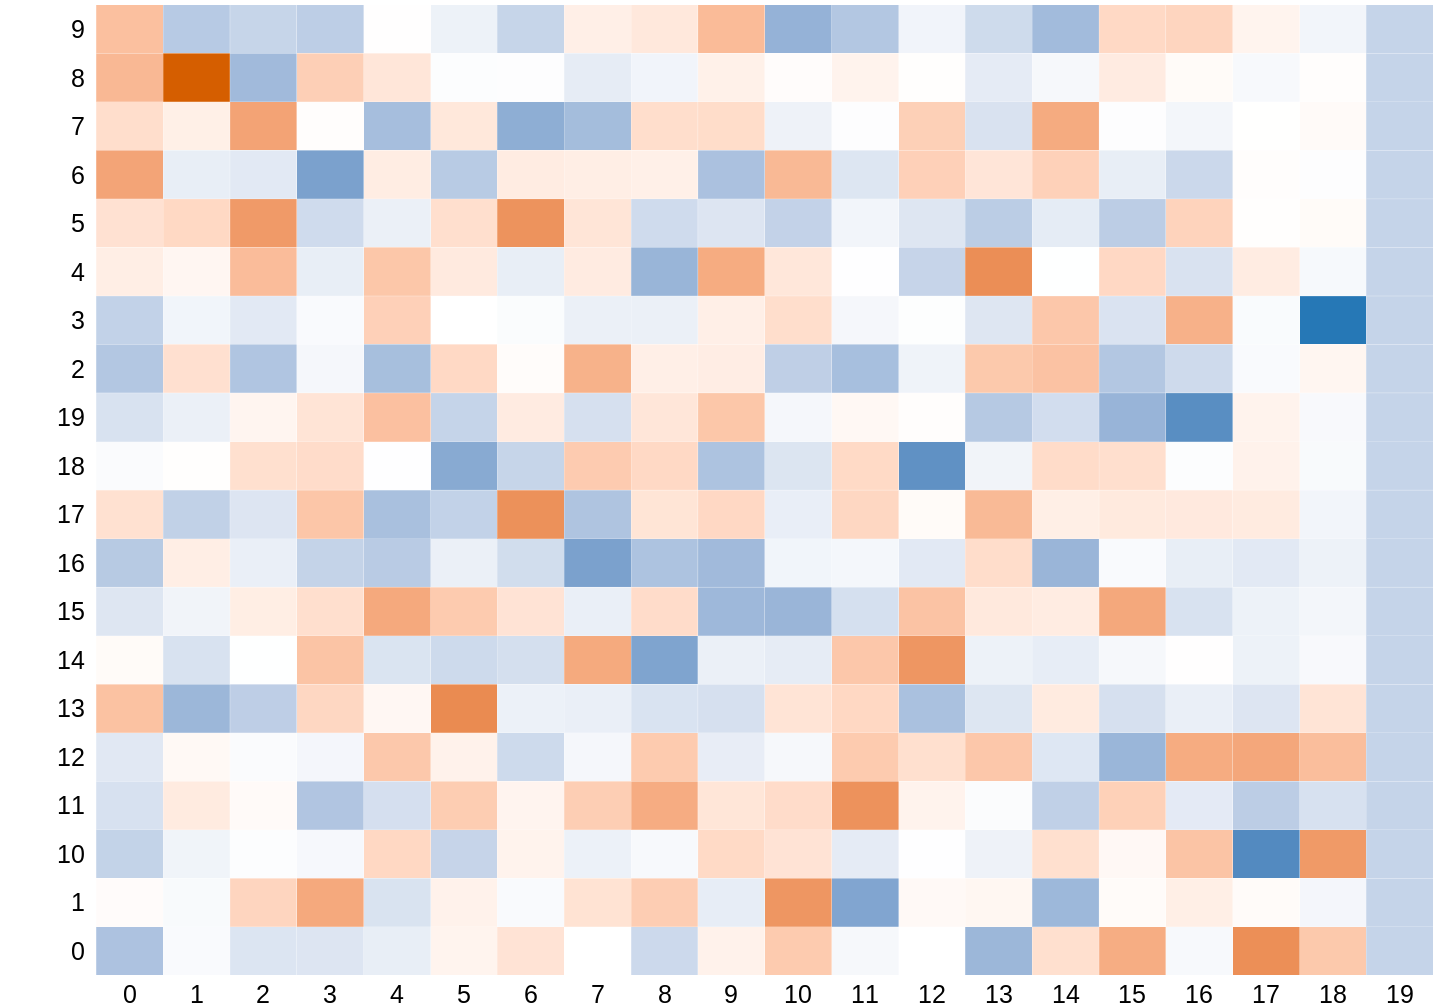

In [93]:
%%R -i pca_types_components_melt -w 20 -h 14 -u in

g = ggplot(pca_types_components_melt, aes(y=index, x=as.factor(variable), fill=value)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00") +
theme(axis.text=element_text(size=25, color="black"),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      legend.position="none",
      panel.background=element_blank(),
      panel.border=element_blank(),
      panel.grid.major=element_blank(),
      panel.grid.minor=element_blank(),
      plot.background=element_blank(),
     strip.background=element_rect(fill="white", color="white"),
     strip.text=element_text(size=25, face="bold"),
     plot.margin=unit(c(0,0,0,2),"cm"))

ggsave('plots/pca-types-loadings-17.png', width=20, height=14)
ggsave('plots/pca-types-loadings-17.pdf', width=20, height=14)

g

Finally, to visualize the relationship between each cluster and the syntax, we plot the coefficients of the best regression mapping clusters to syntax.

In [94]:
ma_cast_cats = pd.merge(ma_cast, best_model['component_probs_any'], 
                        left_index=True, right_index=True)

component_cols = list(range(best_n_components))

X = ma_cast_cats[component_cols]
Y = ma_cast_cats.drop(columns=component_cols)

best_regression = RidgeCV(alphas=[0.001, 0.1, 0.2, 0.5, 1., 2., 5., 10.], cv=5).fit(X, Y)

In [95]:
best_regression_coefs = pd.DataFrame(best_regression.coef_, 
                                     index=ma_cast.columns, 
                                     columns=best_model['component_probs_any'].columns)

best_regression_coefs_melt = pd.melt(best_regression_coefs.reset_index(), id_vars='frame')

best_regression_coefs_melt['label'] = best_regression_coefs_melt.variable.map(cluster_labels)

best_regression_coefs_melt

,frame,variable,value,label
0,NP Ved,0,-0.000012,0
1,NP Ved NP,0,0.113390,0
2,NP Ved NP VP,0,0.349064,0
3,NP Ved NP VPing,0,0.172290,0
4,NP Ved NP that S,0,0.140612,0
...,...,...,...,...
995,NP was Ved whether S[+future],19,0.065572,19
996,NP was Ved whether to VP,19,0.055342,19
997,NP was Ved whichNP S,19,0.122375,19
998,NP was Ved whichNP to VP,19,0.135235,19


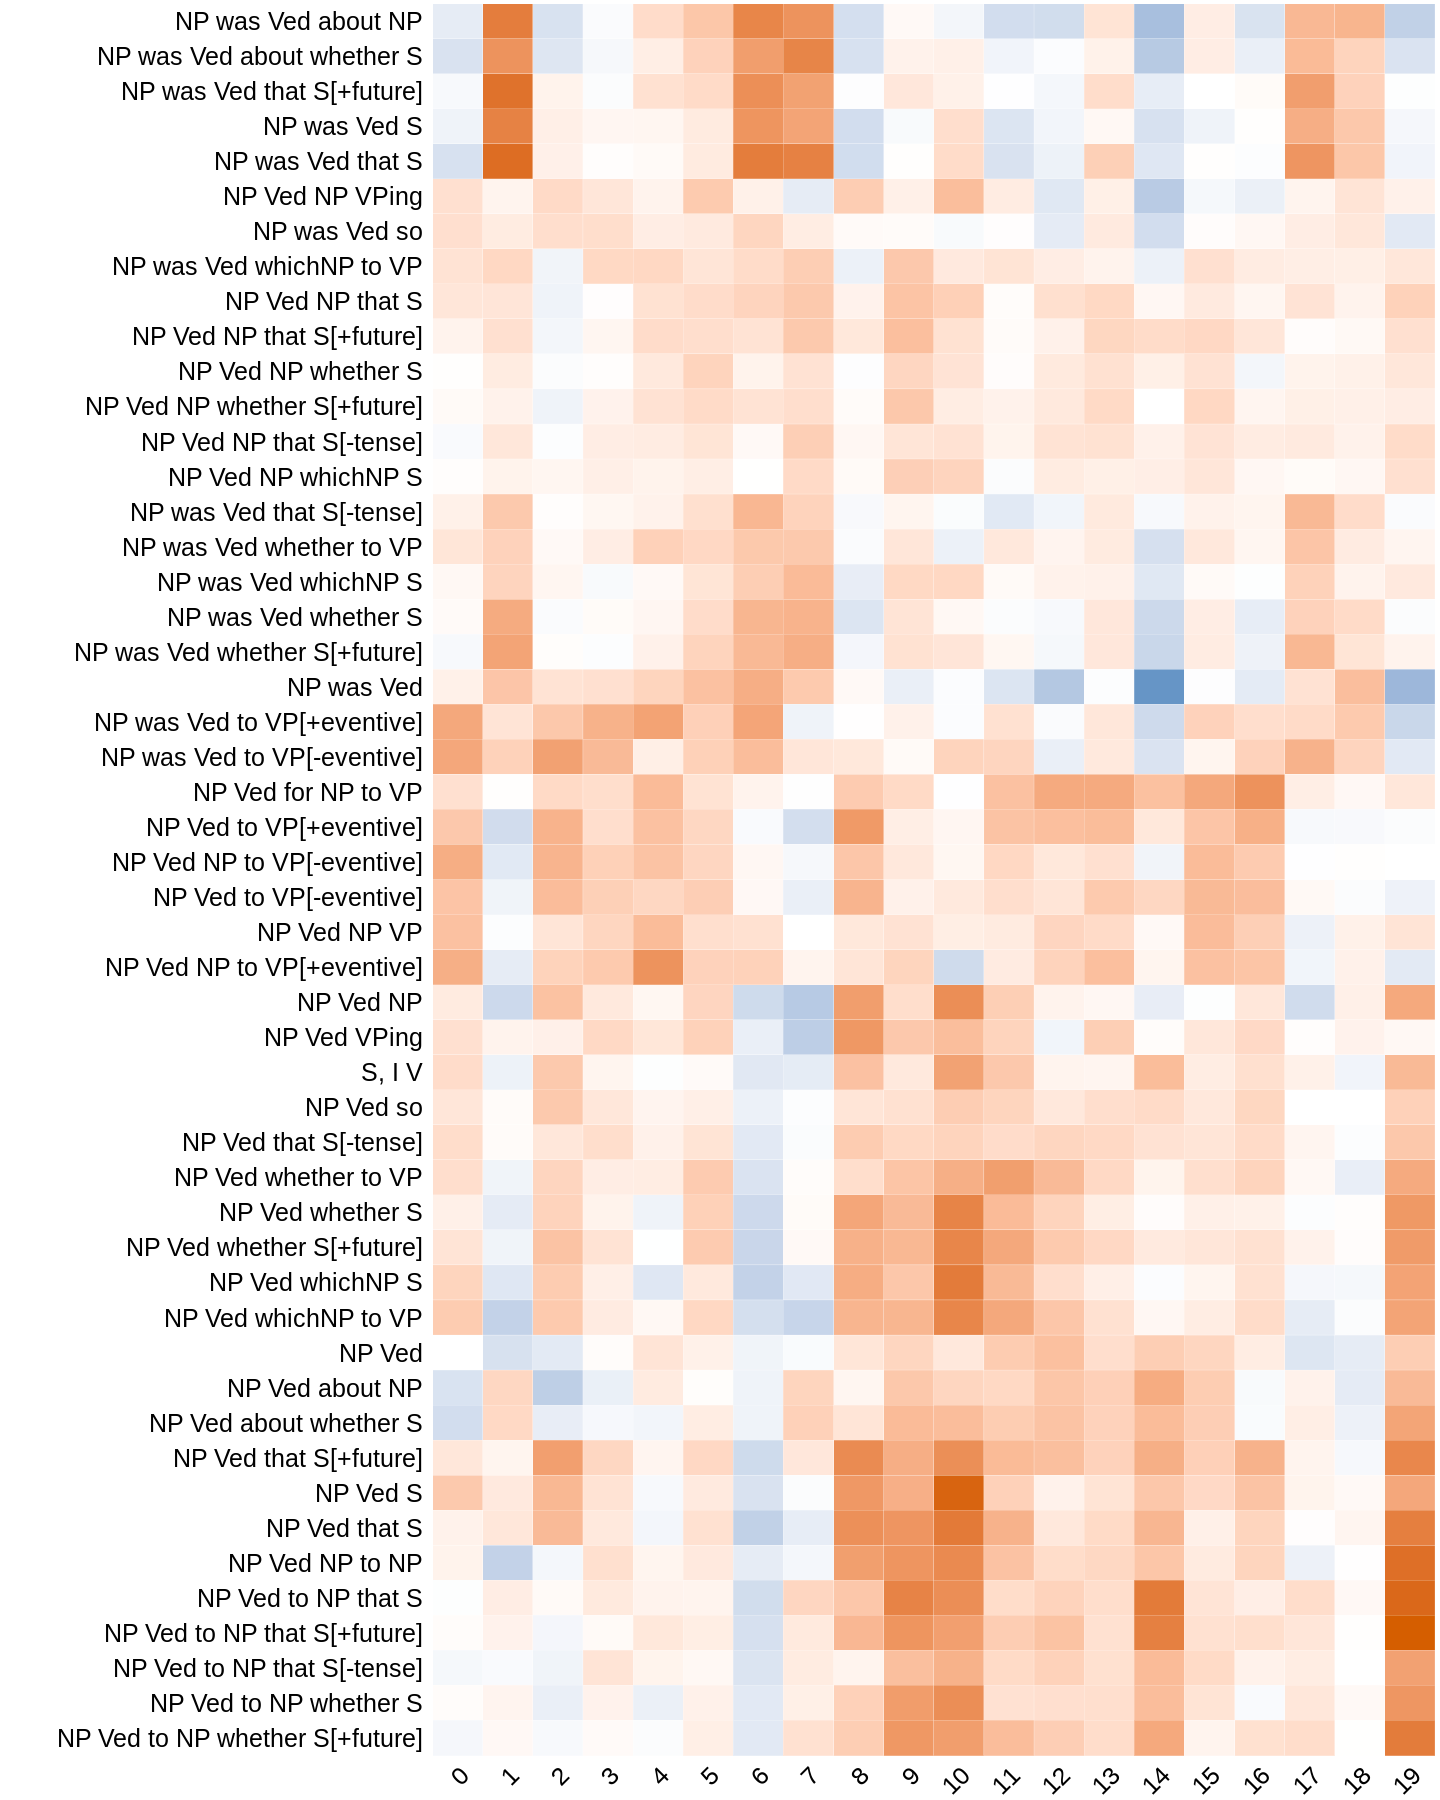

In [96]:
%%R -i best_regression_coefs -i best_regression_coefs_melt -i cluster_order -w 20 -h 25 -u in

best_regression_coefs_melt$label = ordered(best_regression_coefs_melt$label,
                                      levels=cluster_order)

frame_order = row.names(best_regression_coefs)[rev(hclust(dist(best_regression_coefs))$order)]

best_regression_coefs_melt$frame = ordered(best_regression_coefs_melt$frame,
                                      levels=frame_order)

g = ggplot(best_regression_coefs_melt, aes(y=frame, x=label, fill=value)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00") +
theme(axis.text=element_text(size=25, color="black"),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      axis.text.x=element_text(angle=45, hjust=1),
      legend.position="none",
      panel.background=element_blank(),
      panel.border=element_blank(),
      panel.grid.major=element_blank(),
      panel.grid.minor=element_blank(),
      plot.background=element_blank(),
     strip.background=element_rect(fill="white", color="white"),
     strip.text=element_text(size=25, face="bold"),
     plot.margin=unit(c(0,0,0,2),"cm"))

ggsave('plots/regression-coefs-15.png', width=20, height=25)
ggsave('plots/regression-coefs-15.pdf', width=20, height=25)

g

In our analysis, we focus on the relationship between underlying semantic components and syntactic features. To do this, we treat syntactic frames as individual observations, with a vector of syntactic features (e.g., "NP_subj", "whether to VP", etc.) for each observation (note that a particular frame may appear in multiple obligations, as some frames are associated with multiple possible parses).

Then, given the matrix of cluster (inference pattern) weights by frame, we "rotate" the matrix by the component x cluster matrix from the PCA to obtain a matrix relating the underlying semantic components to frames.

We try to learn a mapping from components to features (i.e., a matrix of component x feature weights) that predicts the syntactic features from the component weights for each observation.

In [97]:
from collections import OrderedDict

frame_to_constituents = OrderedDict({
    'NP was Ved whichNP to VP': {
        ("NP_subj", "NP_obj", "whichNP to VP"),
        ("NP_obj", "whichNP to VP")
    },
    'NP Ved for NP to VP': {
        ("NP_subj", "for NP to VP"),
        ("NP_subj", "PP_for", "to VP")
    },
    'NP Ved NP to VP[+eventive]': {
        ("NP_subj", "NP to VP[+eventive]"),
        ("NP_subj", "NP_obj", "to VP[+eventive]")
    },
    'NP was Ved whether to VP': {
        ("NP_subj", "NP_obj", "whether to VP"),
        ("NP_obj", "whether to VP")
    },
    'NP Ved to VP[+eventive]': {
        ("NP_subj", "to VP[+eventive]")
    },
    'NP Ved NP to NP': {
        ("NP_subj", "NP_obj", "NP_iobj")
    },
    'NP Ved NP that S': {
        ("NP_subj", "NP_obj", "that S")
    },
    'NP was Ved about NP': {
        ("NP_subj", "NP_obj", "about NP") ,
        ("NP_obj", "about NP")
    },
    'NP was Ved that S[-tense]': {
        ("NP_subj", "NP_obj", "S[-tense]") ,
        ("NP_obj", "S[-tense]")
    },
    'NP Ved to NP that S[+future]': {
        ("NP_subj", "NP_iobj", "that S[+future]")
    },
    'NP Ved whether to VP': {
        ("NP_subj", "whether to VP")
    },
    'NP Ved whichNP to VP': {
        ("NP_subj", "whichNP to VP")
    },
    'NP Ved about whether S': {
        ("NP_subj", "about whether S")
    },
    'NP Ved whichNP S': {
        ("NP_subj", "whichNP S")
    },
    'NP Ved that S[-tense]': {
        ("NP_subj", "that S[-tense]")
    },
    'NP Ved whether S[+future]': {
        ("NP_subj", "whether S[+future]")
    },
    'NP was Ved that S[+future]': {
        ("NP_subj", "NP_obj", "that S[+future]") ,
        ("NP_obj", "that S[+future]")
    },
    'NP Ved to NP whether S': {
        ("NP_subj", "NP_iobj", "whether S")
    },
    'NP Ved': {
        ("NP_subj",)
    },
    'NP Ved NP to VP[-eventive]': {
        ("NP_subj", "NP to VP[-eventive]"),
        ("NP_subj", "NP_obj", "to VP[-eventive]"),
        ("NP_subj", "NP to VP[-eventive]")
    },
    'NP was Ved so': {
        ("NP_obj", "so"),
        ("NP_subj", "NP_obj", "so")
    },
    'NP Ved so': {
        ("NP_subj", "so")
    },
    'NP Ved NP that S[+future]': {
        ("NP_subj", "NP_obj", "that S[+future]")
    },
    'NP Ved NP whether S[+future]': {
        ("NP_subj", "NP_obj", "whether S[+future]")
    },
    'NP Ved to NP whether S[+future]': {
        ("NP_subj", "NP_iobj", "whether S[+future]")
    },
    'NP was Ved that S': {
        ("NP_obj", "that S"),
        ("NP_subj", "NP_obj", "that S")
    },
    'NP Ved NP whether S': {
        ("NP_subj", "NP_obj", "whether S")
    },
    'NP was Ved whether S': {
        ("NP_obj", "whether S"),
        ("NP_subj", "NP_obj", "whether S")
    },
    'NP was Ved to VP[-eventive]': {
        ("NP_obj", "to VP[-eventive]"),
        ("NP_subj", "NP_obj", "to VP[-eventive]"),
        ("NP_subj", "NP to VP[-eventive]")
    },
    'NP Ved NP VP': {
        ("NP_subj", "NP_obj", "VP"),
        ("NP_subj", "NP VP")
    },
    'NP Ved VPing': {
        ("NP_subj", "VPing")
    },
    'NP was Ved to VP[+eventive]': {
        ("NP_obj", "to VP[+eventive]"),
        ("NP_subj", "NP_obj", "to VP[+eventive]"),
        ("NP_subj", "NP to VP[+eventive]")
    },
    'NP Ved NP that S[-tense]': {
        ("NP_subj", "NP_obj", "that S[-tense]")
    },
    'NP Ved that S': {
        ("NP_subj", "that S")
    },
    'NP was Ved': {
        ("NP_obj",),
        ("NP_subj", "NP_obj")
    },
    'NP Ved S': {
        ("NP_subj", "S")
    },
    'NP Ved that S[+future]': {
        ("NP_subj", "that S[+future]")
    },
    'NP was Ved about whether S': {
        ("NP_subj", "NP_obj", "about whether S") ,
        ("NP_obj", "about whether S")
    },
    'NP Ved NP': {
        ("NP_subj", "NP_obj")
    },
    'NP Ved NP VPing': {
        ("NP_subj", "NP_obj", "VPing"),
        ("NP_subj", "NP VPing")
    },
    'NP Ved NP whichNP S': {
        ("NP_subj", "NP_obj", "whichNP S")
    },
    'NP Ved about NP': {
        ("NP_subj", "about NP")
    },
    'NP was Ved S': {
        ("NP_subj", "NP_obj", "S") ,
        ("NP_obj", "S")
    },
    'NP Ved to NP that S': {
        ("NP_subj", "NP_iobj", "that S"),
    },
    'NP was Ved whether S[+future]': {
        ("NP_subj", "NP_obj", "whether S[+future]") ,
        ("NP_obj", "whether S[+future]")
    },
    'NP Ved whether S': {
        ("NP_subj", "whether S")
    },
    'NP was Ved whichNP S': {
        ("NP_subj", "NP_obj", "whichNP S") ,
        ("NP_obj", "whichNP S")
    },
    'NP Ved to NP that S[-tense]': {
        ("NP_subj", "NP_iobj", "that S[-tense]")
    },
    'NP Ved to VP[-eventive]': {
        ("NP_subj", "to VP[-eventive]")
    }
    # S, I V?
})

SYNTACTIC_FEATURES = []
for frame, constituents in frame_to_constituents.items():
    for parse in constituents:
        for x in parse:
            if x not in SYNTACTIC_FEATURES:
                SYNTACTIC_FEATURES.append(x)
                
SYNTACTIC_FEATURES

['NP_obj',
 'whichNP to VP',
 'NP_subj',
 'for NP to VP',
 'PP_for',
 'to VP',
 'to VP[+eventive]',
 'NP to VP[+eventive]',
 'whether to VP',
 'NP_iobj',
 'that S',
 'about NP',
 'S[-tense]',
 'that S[+future]',
 'about whether S',
 'whichNP S',
 'that S[-tense]',
 'whether S[+future]',
 'whether S',
 'to VP[-eventive]',
 'NP to VP[-eventive]',
 'so',
 'VP',
 'NP VP',
 'VPing',
 'S',
 'NP VPing']

In [98]:
best_regression_coefs_reordered = best_regression_coefs.rename(columns=cluster_labels).reindex(cluster_order, axis=1)

print(all_locs_T.columns)
print(best_regression_coefs_reordered.columns)

frame_component_weights = pd.DataFrame(pca_types.transform(best_regression_coefs_reordered),
                                       index=best_regression_coefs_reordered.index)

# best_regression_coefs_reordered.head()
frame_component_weights.head()

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19'],
      dtype='object')
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19'],
      dtype='object')


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
frame,,,,,,,,,,,,,,,,,,,,
NP Ved,0.278262,0.143866,-0.117079,0.022767,0.600164,0.013100,-0.316427,0.092326,-0.264680,0.075012,-0.490847,0.427710,0.354329,-0.171867,-0.453037,-0.033419,0.037354,-0.201264,0.088246,-0.399977
NP Ved NP,-0.052827,0.638173,-0.449603,-0.009077,0.603564,-0.204968,-0.019611,0.175201,-0.230649,0.312522,-0.488103,0.136513,-0.154152,-0.387421,-0.324304,-0.155516,0.008120,-0.548813,0.228149,-0.497096
NP Ved NP VP,0.164887,0.187657,-0.106067,-0.096967,0.540495,0.033157,-0.190943,0.055665,-0.367346,-0.096686,-0.339146,0.047036,0.089782,-0.038634,-0.166844,0.134200,-0.003824,0.008848,-0.017364,-0.717650
NP Ved NP VPing,0.312821,0.386888,-0.180115,0.010317,0.311763,-0.166219,0.148247,0.150698,-0.093404,0.139179,-0.196098,-0.078986,-0.212343,-0.251761,-0.031087,0.052082,0.133283,-0.324367,0.070659,-0.340700
NP Ved NP that S,0.546208,-0.010250,0.056466,0.053185,0.333056,-0.202309,-0.200552,-0.080424,-0.131884,0.107493,-0.289300,0.017793,0.181911,-0.205460,-0.182823,0.004934,0.062492,-0.133502,0.172736,-0.646008


In [99]:
frame_component_weights_melt = pd.melt(frame_component_weights.reset_index(), id_vars='frame')

frame_component_weights_melt['label'] = frame_component_weights_melt.variable.map(lambda x: str(x))
frame_component_weights_order = [str(i) for i in range(best_n_components)]

frame_component_weights_melt

,frame,variable,value,label
0,NP Ved,0,0.278262,0
1,NP Ved NP,0,-0.052827,0
2,NP Ved NP VP,0,0.164887,0
3,NP Ved NP VPing,0,0.312821,0
4,NP Ved NP that S,0,0.546208,0
...,...,...,...,...
995,NP was Ved whether S[+future],19,-0.545565,19
996,NP was Ved whether to VP,19,-0.541679,19
997,NP was Ved whichNP S,19,-0.442544,19
998,NP was Ved whichNP to VP,19,-0.568034,19


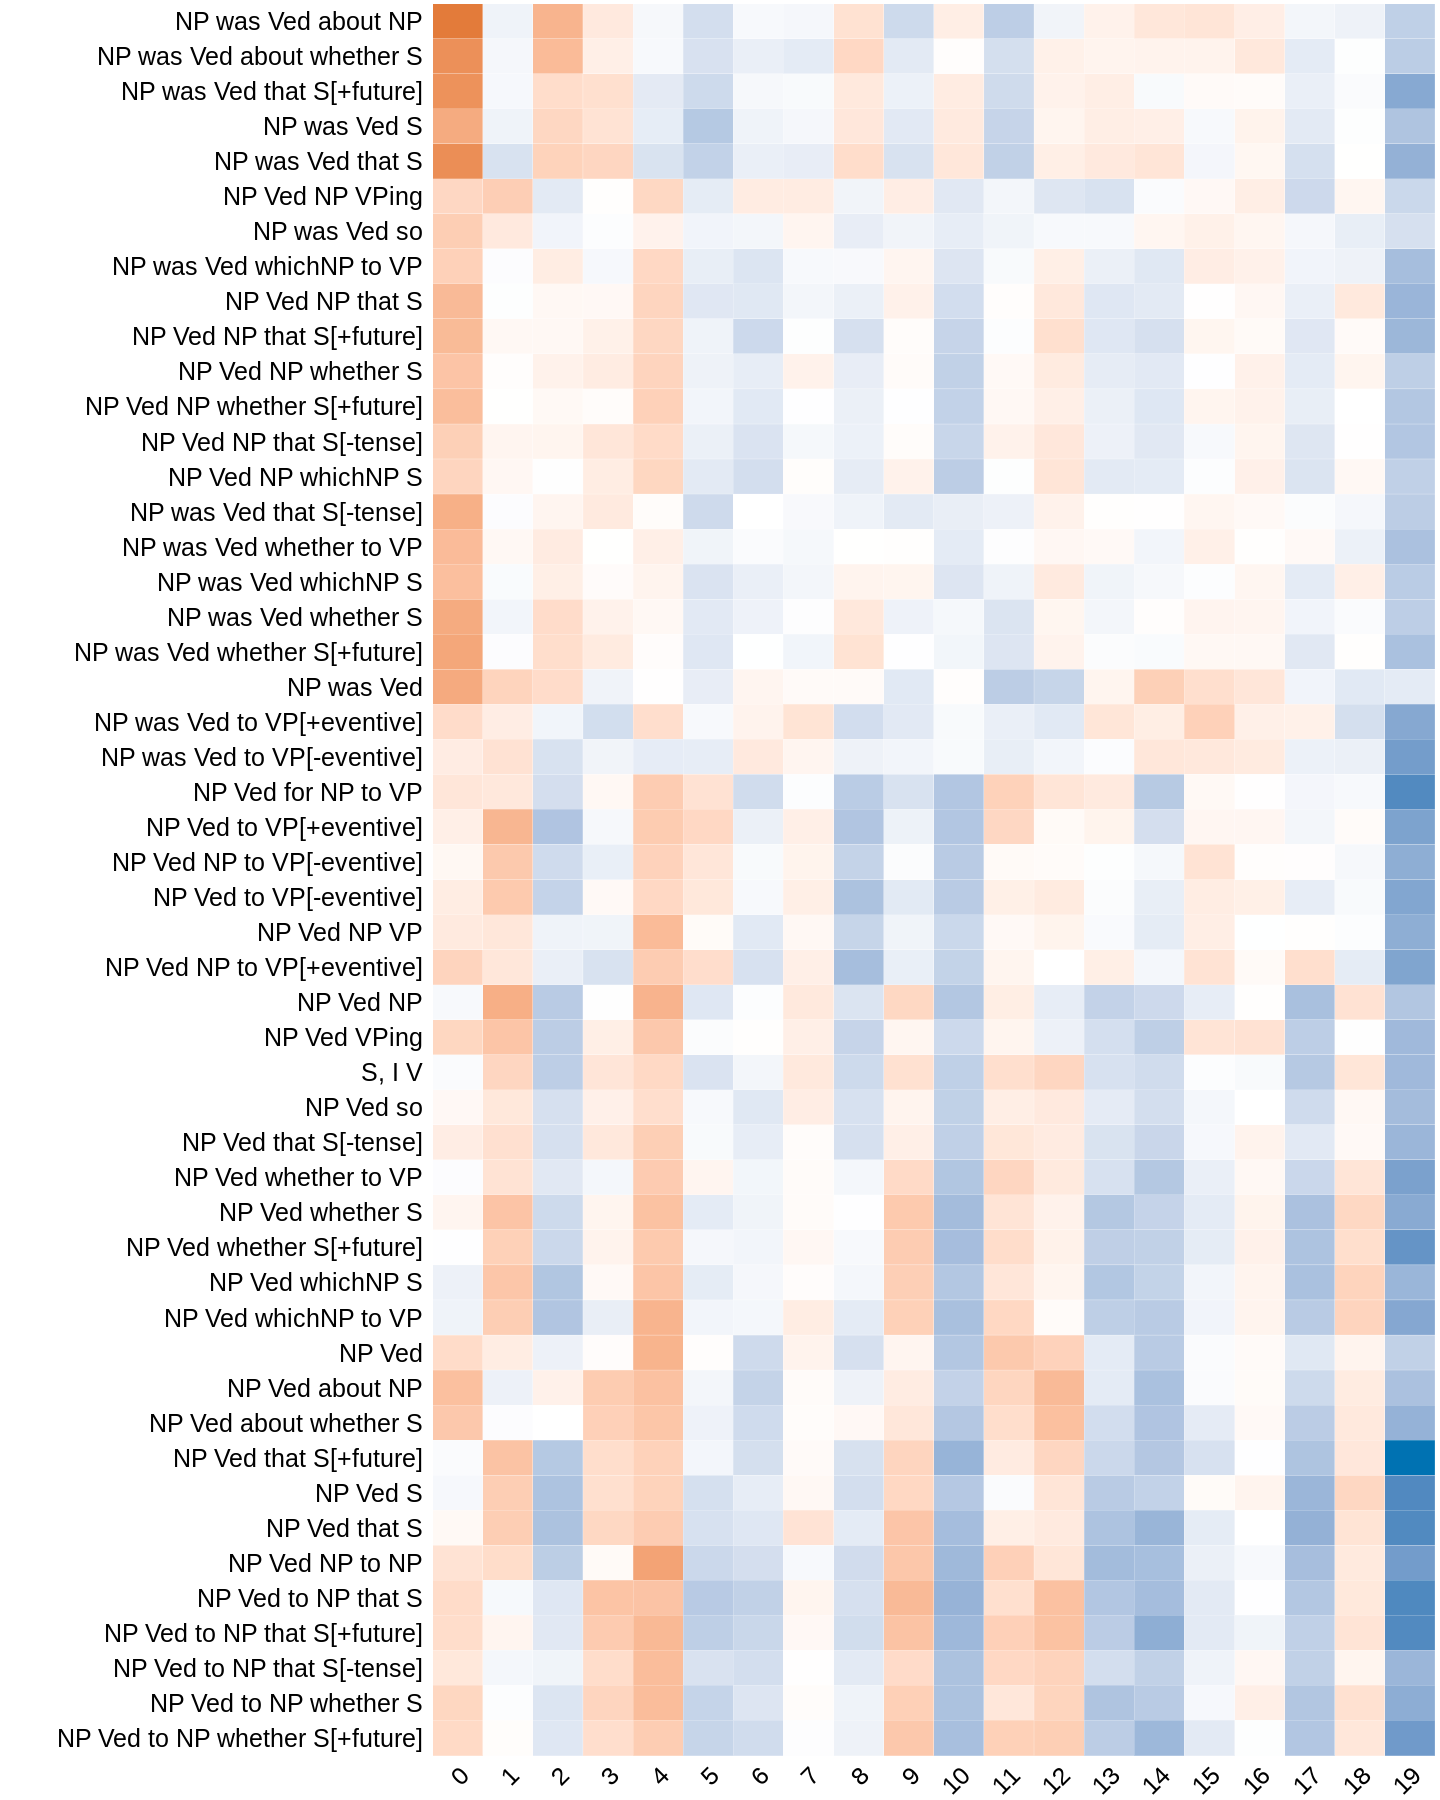

In [100]:
%%R -i frame_component_weights -i frame_component_weights_melt -i frame_component_weights_order -w 20 -h 25 -u in

frame_component_weights_melt$label = ordered(frame_component_weights_melt$label,
                                              levels=frame_component_weights_order)

frame_order = row.names(frame_component_weights)[rev(hclust(dist(frame_component_weights))$order)]

frame_component_weights_melt$frame = ordered(frame_component_weights_melt$frame,
                                      levels=frame_order)

g = ggplot(frame_component_weights_melt, aes(y=frame, x=label, fill=value)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00") +
theme(axis.text=element_text(size=25, color="black"),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      axis.text.x=element_text(angle=45, hjust=1),
      legend.position="none",
      panel.background=element_blank(),
      panel.border=element_blank(),
      panel.grid.major=element_blank(),
      panel.grid.minor=element_blank(),
      plot.background=element_blank(),
     strip.background=element_rect(fill="white", color="white"),
     strip.text=element_text(size=25, face="bold"),
     plot.margin=unit(c(0,0,0,2),"cm"))

ggsave('plots/frame-component-weights-17.png', width=20, height=25)
ggsave('plots/frame-component-weights-17.pdf', width=20, height=25)

g

In [101]:
frame_component_weights = frame_component_weights.reset_index()
frame_component_weights = frame_component_weights.rename(columns = {'index':'frame'})
frame_component_weights = frame_component_weights[frame_component_weights['frame'].isin(frame_to_constituents.keys())]

frame_component_weights.head()

,frame,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,NP Ved,0.278262,0.143866,-0.117079,0.022767,0.600164,0.013100,-0.316427,0.092326,-0.264680,...,-0.490847,0.427710,0.354329,-0.171867,-0.453037,-0.033419,0.037354,-0.201264,0.088246,-0.399977
1,NP Ved NP,-0.052827,0.638173,-0.449603,-0.009077,0.603564,-0.204968,-0.019611,0.175201,-0.230649,...,-0.488103,0.136513,-0.154152,-0.387421,-0.324304,-0.155516,0.008120,-0.548813,0.228149,-0.497096
2,NP Ved NP VP,0.164887,0.187657,-0.106067,-0.096967,0.540495,0.033157,-0.190943,0.055665,-0.367346,...,-0.339146,0.047036,0.089782,-0.038634,-0.166844,0.134200,-0.003824,0.008848,-0.017364,-0.717650
3,NP Ved NP VPing,0.312821,0.386888,-0.180115,0.010317,0.311763,-0.166219,0.148247,0.150698,-0.093404,...,-0.196098,-0.078986,-0.212343,-0.251761,-0.031087,0.052082,0.133283,-0.324367,0.070659,-0.340700
4,NP Ved NP that S,0.546208,-0.010250,0.056466,0.053185,0.333056,-0.202309,-0.200552,-0.080424,-0.131884,...,-0.289300,0.017793,0.181911,-0.205460,-0.182823,0.004934,0.062492,-0.133502,0.172736,-0.646008


In [102]:
component_syntax_data = []
for frame, constituents in frame_to_constituents.items():
    for parse in constituents:
        component_syntax_data.append({'frame':frame,
                                      'component_weights':np.array(frame_component_weights.query(f"frame=='{frame}'").iloc[0][1:].astype(float)),
                                      'syntactic_features':np.array([1 if x in parse else 0 for x in SYNTACTIC_FEATURES])
                                     })
        
component_syntax_data[0:3]

[{'frame': 'NP was Ved whichNP to VP',
  'component_weights': array([ 0.36516601, -0.02178708,  0.14223895, -0.05789171,  0.30511881,
         -0.14575755, -0.22518976, -0.04887198, -0.04711944,  0.0751456 ,
         -0.22053476, -0.04335316,  0.12987914, -0.12784344, -0.19758687,
          0.13976571,  0.10812224, -0.09014232, -0.1115161 , -0.5680337 ]),
  'syntactic_features': array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0])},
 {'frame': 'NP was Ved whichNP to VP',
  'component_weights': array([ 0.36516601, -0.02178708,  0.14223895, -0.05789171,  0.30511881,
         -0.14575755, -0.22518976, -0.04887198, -0.04711944,  0.0751456 ,
         -0.22053476, -0.04335316,  0.12987914, -0.12784344, -0.19758687,
          0.13976571,  0.10812224, -0.09014232, -0.1115161 , -0.5680337 ]),
  'syntactic_features': array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0])},
 {'frame': 'NP Ved for NP to VP',
  

In [103]:
class SyntacticFeaturePredictor():
    def __init__(self, data):
        self.data = data
        self.n_obs = len(data)
        self._prepare_data()
        
        self.mapping = nn.Linear(self.n_components, self.n_features, bias=False).double()
        
    def _prepare_data(self):
        self.X = torch.tensor([x['component_weights'] for x in self.data])
        self.Y = torch.tensor([x['syntactic_features'] for x in self.data]).double()
        self.n_components = self.X.shape[-1]
        self.n_features = self.Y.shape[-1]
        
    def fit(self, n_epoch=1000, lr=1e-1, verbosity=100):
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.SGD(self.mapping.parameters(), lr=lr)
        for epoch in range(n_epoch):
            optimizer.zero_grad()
            features = self.mapping(self.X)
            loss = criterion(features, self.Y)
            loss.backward()
            optimizer.step()
            if epoch % verbosity == 0:
                print('Loss: {:.3f}'.format(loss.item()))
                
    def pred(self):
        features = self.mapping(self.X)
        return (features>0.5).double()
        
    def weights(self):
        with torch.no_grad():
            return self.mapping.weight.detach().data.numpy()
    

syntactic_feature_pred = SyntacticFeaturePredictor(component_syntax_data)
syntactic_feature_pred.fit()
syntactic_feature_pred.pred()
# syntactic_feature_pred.Y

/tmp/ipykernel_106/4101554452.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  self.X = torch.tensor([x['component_weights'] for x in self.data])


Loss: 0.705
Loss: 0.645
Loss: 0.594
Loss: 0.551
Loss: 0.514
Loss: 0.482
Loss: 0.455
Loss: 0.432
Loss: 0.411
Loss: 0.393


tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]], dtype=torch.float64)